In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.sparse import rand
import scipy.stats as stats
from scipy.signal import savgol_filter as savgol
import dabest as db2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import smBaseFunctions3 as sbf
import smCofiringFunctions as scf
import vBaseFunctions3 as vbf
from my_mpl_defaults import *
import smdabest.dabest as db
import smDSanalysis3 as smd
##################################################
import networkx as nx
import smgpgGraph as ggg
##################################################

In [32]:
################################################################
fscale = 1
SMALL_SIZE = int(5*fscale)
MEDIUM_SIZE = int(6*fscale)
BIGGER_SIZE = int(10*fscale)

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"

col_paired = sns.color_palette('Paired',20)
LIGHTGREEN = col_paired[2]
################################################################
from IPython.core.display import display, HTML
import sys

display(HTML("<style>.container { width:75% !important; }</style>"))
!jt -r
sys.executable

Reset css and font defaults in:
/home/data/.jupyter/custom &
/home/data/.local/share/jupyter/nbextensions


'/Dupret_Lab/venv/venv0/bin/python3.10'

In [4]:
def show_mat(oMat,sess='test',cmap='binary'):
    '''
    
    '''
    print(sess)
    plt.imshow(oMat,aspect='auto',cmap=cmap)
    plt.xlabel('Trials or cycles')
    plt.ylabel('Cells')
    plt.show()
######################################################################################
def show_trk(idata,axes_off=True):
    '''
    
    '''
    rr,cc = 1,1
    wcm = 8 # should be 2
    hcm = 8 # should be 2
    fig, ax = plt.subplots(rr,cc,figsize = sbf.cm2inch(wcm,hcm),\
                           gridspec_kw = {'wspace':0,'hspace':0})
    
    ax.plot(idata[:,0],idata[:,1])
    if axes_off:
        ax.set_axis_off()

    return fig,ax
#############################################################################################################
def save_IFR_data(mpath,output_path,fname,odata):
    '''
    
    '''
    import os,datetime
    
    fullpath = mpath + output_path
    print(fullpath)
    os.chdir(fullpath)
    now = datetime.datetime.now()
    #########################################################################################################
    print('saving file {}'.format(fname))
    print ('Time saved: ' + now.strftime("%Y-%m-%d %H:%M:%S"))
    #########################################################################################################
    fHand = open(fname,'wb')
    np.save(fHand,odata)
    fHand.close()
#############################################################################################################
def generate_df_pulse(temp_times,lkey,width=100,pre_offset=0,post_offset=0,pulse_offset=0,spk_sr=20000,single_col=False):
    '''
    
    '''
    df_pulse = pd.DataFrame().reindex(columns=temp_times.columns)
    if (lkey == 'light') or (lkey == 'pulse'):
        df_pulse['begin'] = temp_times['begin'] - int((pulse_offset/1000)*spk_sr)
        df_pulse['end'] =     df_pulse['begin'] + int((width/1000)*spk_sr) # width in ms
    elif (lkey == 'nolight') or (lkey == 'prepulse'):
        df_pulse['begin'] = temp_times['begin'] - int((pre_offset/1000)*spk_sr) - int((width/1000)*spk_sr) # width in ms
        df_pulse['end'] =     df_pulse['begin'] + int((width/1000)*spk_sr)
    elif (lkey == 'postpulse'):
        df_pulse['begin'] = temp_times['begin'] + int((post_offset/1000)*spk_sr)
        df_pulse['end'] =     df_pulse['begin'] + int((width/1000)*spk_sr)
        
    return df_pulse
#############################################################################################################
def generate_2col_pulsetimes(idata,offset=[0.025,0.025],spk_sr=20000):
    '''
    
    '''
    df = pd.DataFrame(columns=['begin', 'end'])
    df['begin'] = (idata['begin'] - offset[0] * spk_sr).astype(int)
    df['end'] =   (idata['begin'] + offset[1] * spk_sr).astype(int)
    
    return df
#############################################################################################################
def get_matrix_density(iMat,nonzero=False):
    if nonzero:
        return np.size(iMat[iMat>0]) / np.prod(iMat.shape)
    else:
        return np.nansum(iMat) / np.prod(iMat.shape)
###################################################################################    
def generate_surr_matrix(iMat,density_adj=0,nonzero=False):
    
    density = get_matrix_density(iMat,nonzero=nonzero)
    print(density)
    m,n = iMat.shape
    surrmat = rand(m,n,density=density+density_adj,format='csr')
    surrmat.data[:] = 1 

    return surrmat.A
#############################################################################################################
def generate_shuffled_matrix(iMat):
    return iMat[np.random.permutation(iMat.shape[0]),:]
#############################################################################################################
def generate_denser_matrix(iMat,density=0.01):
    
    m,n = iMat.shape
    surrmat = rand(m,n,density=density,format='csr')
    surrmat.data[:] = 1
    
    return iMat + surrmat.A
#############################################################################################################
def generate_alter_nonzero(iMat,prop=0.2,value_to_add=1):
    '''
    
    '''
    oMat = np.copy(iMat)
    i,j = np.nonzero(oMat)
    ix = np.random.choice(len(i), int(np.floor(prop * len(i))), replace=False)
    oMat[i[ix], j[ix]] += value_to_add
    
    return oMat
############################################################################################################
def generate_df_idx(df,col_groups):
    '''
    
    '''
    plot_grps = df.Group_sess.unique()
    number_of_groups = df.Cell_Type.nunique()

    df_idx = [plot_grps[i:i+number_of_groups].tolist() 
              for i in range(0, len(plot_grps), number_of_groups) 
             ]
    
    return df_idx
############################################################################################################
def concat_sessions(iDict,default_key='sess0'):
    '''
    
    '''
    try:
        nCells = iDict[default_key].shape[0]
    except:
        print('problem')
        return None

    tempmat = np.array([]).reshape(nCells,0)
    for key,val in iDict.items():
        tempmat = np.concatenate((tempmat,iDict[key]),axis=1)
    
    return tempmat
###############################################################################################################
def calculate_all_IFR(mouseID,
                      alldesen,
                      allBaseblock,
                      origIDs,
                      ref_ext,
                      width=100,
                      pulse_offset=25,
                      pre_offset=0,
                      post_offset=0,
                      celltype=['pdg','p3','p1'],
                      min_events=100,
                      sleepbox=True,
                      sleeponly=True,
                      cond_list=['nolight','light'],
                      spk_sr=20000,
                      single_col=False,
                      use_sess_key=False):
    '''
    
    '''
    ###########################################################################################################
    offset = ((width / 2)/1000,(width / 2)/1000) 
    print('width:{0:}ms, offset:{1:}ms'.format(width,offset[0]*1000))
    print()
    ############################################################################################################
    IFRAllMice = []
    for mindx,mouse in enumerate(mouseID):
        desen,baseblock,ipath,bsnm = sbf.get_mouse_info(alldesen,allBaseblock,mindx)
        os.chdir(ipath)
        cluID_list = sbf.multi_ctype_IDs(celltype,origIDs,mindx)
        print('{0:} {1:} has {2:} {3:} cells'.format(mindx,bsnm.rsplit('/', 1)[-1],len(cluID_list),'allp'))
        sessions = sbf.get_sessions(desen,sleepbox=sleepbox,sleeponly=sleeponly)
        print(sessions)
        print()
        ########################################################################################
        all_fname = []
        all_sindx = []
        all_tmarkers = []
        t_marker = 0
        #########################################################################################
        for sindx,sess in enumerate(sessions):
            session = sbf.get_descode(desen,sess)
            fname = session.iloc[0]['filebase']
            #print(sess,fname)
            try:
                count = len(open(fname+ref_ext).readlines())
            except FileNotFoundError:
                count = 0
            if count > min_events: # and sess.startswith('n'):
                t_marker += count
                all_fname.append(fname)
                all_sindx.append(fname.rsplit('_', 1))
                all_tmarkers.append(t_marker)
        ##########################################################################################
        allDat = {}
        for lindx,lkey in enumerate(cond_list):
            allSess = {}
            for fsess_ind,fsess in enumerate(all_fname):
                if use_sess_key:
                    okey = sbf.get_sess_key_from_filebase(desen,fsess)
                else:
                    okey = 'sess' + str(fsess_ind)
                print('okey:', okey)
                temp_times = sbf.get_pulsetimes_one_sess(fsess,ref_ext,one_col=False)
                df_pulse = generate_df_pulse(temp_times,
                                             lkey,
                                             width=width,
                                             pulse_offset=pulse_offset,
                                             pre_offset=pre_offset,
                                             post_offset=post_offset,
                                             spk_sr=spk_sr,
                                             single_col=single_col
                                            )
                ##################################################################################
                nTrials = temp_times.shape[0]
                res,clu = vbf.LoadSpikeTimes(fsess,trode=None,MinCluId=2,res2eeg=1)
                allSess[okey] = sbf.calc_spk_counts(res,clu,cluID_list,df_pulse,nTrials)[:,1,:]
            allDat[lkey] = allSess
        IFRAllMice.append(allDat)

    return IFRAllMice
######################################################################################################################
def create_bool_dict(iDict,mouseID):
    '''
    print('{0:} {1:} {2:} {3:} {4:.2f} {5:.2f}'.format(key,mindx,key2,val2.shape,val2.mean(),temp_dict[key2].mean()))
    '''
    bool_IFR_dict = {}
    for key,val in iDict.items():
        #print(key)
        temp_list = []
        for mindx,mouse in enumerate(mouseID):
            temp_dict = {}
            for key2,val2 in val[mindx].items():
                temp_dict[key2] = val2.astype(bool)
                
            temp_list.append(temp_dict)
        bool_IFR_dict[key] = temp_list
        
    return bool_IFR_dict           

In [5]:
######################################################################################
def percent_active_neurons(idata):
    '''
    '''
    return 100 * (np.nansum(np.sign(idata),axis=0) / idata.shape[0])
######################################################################################
def calc_all_percent_active(IFRAllMice,cond_list=['nolight','light']):
    '''
    '''
    all_pc_active = {}
    nMice = len(IFRAllMice)
    for lindx,lcond in enumerate(cond_list):
        pc_active = []
        for mindx in np.arange(nMice):
            tempDict = IFRAllMice[mindx][lcond]    
            pc_active.extend(percent_active_neurons(tempDict))
        all_pc_active[lcond] = np.array(pc_active)

    return all_pc_active
######################################################################################
def calc_all_percent_active_per_session(IFRAllMice,cond_list=['nolight','light']):
    '''
    '''
    all_pc_active = {}
    nMice = len(IFRAllMice)
    for lindx,lcond in enumerate(cond_list):
        pc_active = []
        for mindx in np.arange(nMice):
            tempDict = IFRAllMice[mindx][lcond]
            pc_active.append(np.nanmean(percent_active_neurons(tempDict)))
        all_pc_active[lcond] = np.array(pc_active)

    return all_pc_active
#########################################################################################
def calc_all_percent_active_each_mouse(IFRAllMice,cond_list=['nolight','light']):
    '''
    
    '''
    all_pc_active = {}
    nMice = len(IFRAllMice)
    for lindx,lcond in enumerate(cond_list):
        pc_active = []
        for mindx in np.arange(nMice):
            tempDict = IFRAllMice[mindx][lcond]
            pc_active.append(percent_active_neurons(tempDict))
        all_pc_active[lcond] = pc_active

    return all_pc_active
#########################################################################################
def calc_mean_per_session(IFRAllMice,cond_list=['nolight','light']):
    '''
    '''
    all_mean = {}
    nMice = len(IFRAllMice)
    for lindx,lcond in enumerate(cond_list):
        temp_mean = []
        for mindx in np.arange(nMice):
            tempDict = IFRAllMice[mindx][lcond]
            temp_mean.append(np.nanmean(tempDict))
        all_mean[lcond] = np.array(temp_mean)

    return all_mean
############################################################################################
def generate_gini_from_IFR(IFRAllMice,lcond_list,mouseID,sess='sess0'):
    '''
    
    '''
    nMice = len(IFRAllMice)
    odata = {}
    for lindx,lcond in enumerate(lcond_list):
        tempDat = []
        for mindx in np.arange(nMice):
            try:
                idata = IFRAllMice[mindx][lcond][sess]
                for trial in range(idata.shape[1]):
                    tempDat.append(scf.gini(IFRAllMice[mindx][lcond][sess][:,trial]))
            except KeyError:
                tempDat.append(np.nan)
        odata[lcond] = np.array(tempDat)

    return odata
############################################################################################
def generate_mean_gini_from_IFR(IFRAllMice,lcond_list,mouseID):
    '''
    
    '''
    nMice = len(IFRAllMice)
    odata = {}
    for lindx,lcond in enumerate(lcond_list):
        meanDat = []
        for mindx in np.arange(nMice):
            idata = IFRAllMice[mindx][lcond]
            tempDat = []
            for trial in range(idata.shape[1]):
                if np.sum(idata[:,trial]) > 0:
                    tempDat.append(scf.gini(idata[:,trial]))
                else:
                    print(lcond,mindx,trial,'no spikes in this array')
                    tempDat.append(np.nan)
            meanDat.append(np.nanmean(tempDat))
        odata[lcond] = np.array(meanDat)

    return odata
############################################################################################
def generate_mean_hoyer_from_IFR(IFRAllMice,lcond_list,mouseID):
    '''
    
    '''
    nMice = len(IFRAllMice)
    odata = {}
    for lindx,lcond in enumerate(lcond_list):
        meanDat = []
        for mindx in np.arange(nMice):
            #for sess_key,val in IFRAllMice[mindx][lcond].items():
            idata = IFRAllMice[mindx][lcond]#[sess_key]
            tempDat = []
            for trial in range(idata.shape[1]):
                if np.sum(idata[:,trial]) > 0:
                    tempDat.append(scf.hoyer(idata[:,trial]))
                else:
                    print(lcond,mindx,trial,'no spikes in this array')
                    tempDat.append(np.nan)
                #print(len(tempDat))
            meanDat.append(np.nanmean(tempDat))
        odata[lcond] = np.array(meanDat)

    return odata
############################################################################################
def element_subtract_list(X,Y):
    '''
    
    '''
    return [(x-y) for x,y in zip(X,Y)]
############################################################################################
def get_dabest_params(day_type,group_type='chr2'):
    
    if (day_type == 'cfos' and group_type == 'chr2'):
        swarm_ylim = (.6,1)
        contrast_ylim = (-.2,0.1)
        maj_loc = (.2,.1)
    elif (day_type == 'cfos' and group_type == 'archT'):
        swarm_ylim = (.2,1)
        contrast_ylim = (-.04,0.02)
        maj_loc = (.2,.02)
    elif (day_type == 'sparsity_all' and group_type == 'chr2'):
        swarm_ylim = (.6,1)
        contrast_ylim = (-.005,.02) 
        maj_loc = (.2,.01)
    elif (day_type == 'path_all' and group_type == 'archT'):
        swarm_ylim = (.2,1)
        contrast_ylim = (-.03,0.03)
        maj_loc = (.2,.03)
    elif (day_type == 'sparsity_all' and group_type == 'archT'):
        swarm_ylim = (.2,1)
        contrast_ylim = (-.02,0.02)
        maj_loc = (.2,.02)
    elif (day_type == 'aged' and group_type == 'archT'):
        swarm_ylim = (.2,1)
        contrast_ylim = (-.02,0.02)
        maj_loc = (.2,.02)
    elif (day_type == 'aged' and group_type == 'chr2'):
        swarm_ylim = (.6,1)
        contrast_ylim = (-.01,0.01)
        maj_loc = (.2,.01)
    elif (group_type == 'gfp'):
        swarm_ylim = (.2,1.0)
        contrast_ylim = (-.02,0.02)
        maj_loc = (.2,.02)
    elif (day_type == 'sparsity_all' and group_type == 'chr2_archT'):
        swarm_ylim = (.6,1)
        contrast_ylim = (-.1,.05)
        maj_loc = (.2,.05)
    else:
        swarm_ylim = (.2,1)
        contrast_ylim = (-.03,0.03)
        maj_loc = (.2,.03)

    return swarm_ylim,contrast_ylim,maj_loc
#################################################################################
def print_info(day_type,group_type,database):
    print(day_type,group_type)
    print('There are {} recording days'.format(len(database)))
    print('\n'.join([x for x in database]))
#################################################################################
def count_vector_length(mouseID,idata,lcond='nolight',sess='sess0'):
    '''
    '''
    odata = []
    valid_sess = 0
    for mindx,mouse in enumerate(mouseID):
        try:
            nCells = idata[mindx][lcond][sess].shape[0]
            valid_sess += 1
            print(mindx,valid_sess,mouse,nCells)
        except KeyError:
            nCells = np.nan
        odata.append(nCells)

    return np.array(odata)
######################################################################################
def generate_labels(df,label_key='event',pre_text='pre\n'):
    '''
    
    ''' 
    labs = df[label_key]
    _,inds = np.unique(df[label_key],return_index=True)
    event_type_list = labs[sorted(inds)].values
    print(event_type_list)
    
    lab_list = []
    for ev_indx,event in enumerate(event_type_list):
        lab_list.append([pre_text+event,event])
        
    return sbf.flatten(lab_list)
############################################################################################################
def select_random_subset(arr,max_bin,axis=1,nprs=100):
    '''
    number_of_rows = arr.shape[0]
    number_of_cols = arr.shape[1]
    '''
    np.random.seed(nprs)
    
    number_of_ = arr.shape[axis]
    random_indices = np.random.choice(number_of_, size=max_bin, replace=True)
    
    if axis == 1:
        return arr[:,random_indices]
    else:
        return arr[random_indices,:]
##############################################################################################################
def get_clust_coactive_pop(actmat,weight='weight'):
    '''

    '''
    G_pair,G_pop = ggg.GLMgraph_lin(actmat, symm=0) # obtain graphs

    # obtain clustering of the pairwise graph
    graph = nx.Graph(G_pair) # nx object
    clustering = list(ggg.clustering(graph, weight=weight).values())

    return np.array(clustering),np.nanmean(G_pair,axis=0),np.nanmean(G_pop,axis=1)
##############################################################################################################
def get_graph_object(actmat):
    '''
    
    '''
    G_pair,G_pop = ggg.GLMgraph_lin(actmat, symm=0) # obtain graphs

    # obtain clustering of the pairwise graph
    graph = nx.Graph(G_pair) # nx object
    
    return graph
###############################################################################################################
def get_clustering(actmat,weight=None):
    '''
    
    '''
    G_pair,G_pop = ggg.GLMgraph_lin(actmat, symm=0) # obtain graphs

    # obtain clustering of the pairwise graph
    graph = nx.Graph(G_pair) # nx object
    clustering = list(ggg.clustering(graph, weight='weight').values())

    return np.array(clustering)
##############################################################################################################-
def get_pair_coactivity_coupling(actmat):

    G_pair,G_pop = ggg.GLMgraph_lin(actmat, symm=0) # obtain graphs

    return np.nanmean(G_pair,axis=0) # raw pairwise coactivity
##############################################################################################################
def pop_coupling(actmat, ID=None):
    # actmat is population activity matrix [Time,Ncells]
    # set ID is the cell index to calculate the popCoupling for just that cell
    # output is the popCoupling (pc) of all cells or just one (pearson r)
    if ID: # one cell
        x = actmat[:,ID]
        sel = np.ones(actmat.shape[1],dtype=bool); sel[ID] = 0
        xpop = actmat[:,sel].sum(1)
        pc = np.corrcoef(x,xpop)[0,1]
    else: # all cells
        pc = np.zeros(actmat.shape[1])
        for id_ in range(actmat.shape[1]):
            x = actmat[:,id_]
            sel = np.ones(actmat.shape[1],dtype=bool); sel[id_] = 0
            xpop = actmat[:,sel].sum(1)
            pc[id_] = pearson(x,xpop)
    return pc
##############################################################################################################
def get_event_clust_merged_sess(iDict,mouseID,event_list=['ds','swr'],cond='pulse',get_max_bin=True,measure='cluster'):
    '''
    will calculate the clustering coefficient or coactivity
    use measure='cluster' or measure='coactive' to specify
    '''
    all_mice_clust = []
    for mindx,mouse in enumerate(mouseID):
        print(mindx,mouse)
        if get_max_bin:
            max_bin = find_max_bin_1d(iDict,
                                      mindx,
                                      event_list,
                                      cond=cond)
        else:
            max_bin = -1
        #####################################################
        odata = {}
        for ev_indx,event in enumerate(event_list):
            actmat = select_random_subset(iDict[event][mindx][cond],max_bin,axis=1)
            
            if measure == 'cluster':
                odata[event] = get_clustering(actmat.T)
            elif measure == 'coactive':
                odata[event] = get_pair_coactivity_coupling(actmat.T)
            elif measure == 'pop_couple':
                odata[event] = pop_coupling(actmat.T)
                
        all_mice_clust.append(odata)
        
    return all_mice_clust
##########################################################################################################
def get_event_metrics_merged_sess(iDict,mouseID,event_list=['ds','swr'],cond='pulse',get_max_bin=True,weight=None):
    '''
    will calculate the clustering coefficient or coactivity
    use measure='cluster' or measure='coactive' to specify
    '''
    all_mice_clust = []
    all_mice_coactive = []
    all_mice_pop = []
    
    for mindx,mouse in enumerate(mouseID):
        print(mindx,mouse)
        if get_max_bin:
            max_bin = find_max_bin_1d(iDict,
                                      mindx,
                                      event_list,
                                      cond=cond)
        else:
            max_bin = -1
        #####################################################
        odata_clust = {}
        odata_coactive = {}
        odata_pop = {}
        for ev_indx,event in enumerate(event_list):
            actmat = select_random_subset(iDict[event][mindx][cond],max_bin,axis=1)
            odata_clust[event],odata_coactive[event],odata_pop[event] = get_clust_coactive_pop(actmat.T,weight=weight)

        all_mice_clust.append(odata_clust)
        all_mice_coactive.append(odata_coactive)
        all_mice_pop.append(odata_pop)
        
    return all_mice_clust,all_mice_coactive,all_mice_pop
##########################################################################################################################
def find_max_bin_1d(iDict,mindx,event_list,cond='pulse',axis=1):
    '''
    
    '''
    max_bin = 10e20
    for ev_indx,event in enumerate(event_list):
        idata = iDict[event][mindx][cond].shape[axis]
        max_bin = np.nanmin([max_bin,idata])
        
    return int(max_bin)
##########################################################################################################
def reorder_keys(iDict,mouseID,event_list=['ds','swr'],cond_list=['prepulse','pulse']):
    '''

    '''
    oDict = {}
    for ev_indx,event in enumerate(event_list):
        temp_dict = {}
        for cond_indx,cond in enumerate(cond_list):
            temp_dat = []
            for mindx,mouse in enumerate(mouseID):
                temp_dat.extend(iDict[cond][mindx][event])
            temp_dict[cond] = np.array(temp_dat)
        oDict[event] = temp_dict

    return oDict
##########################################################################################################
def concat_2_level_dict_sessions(iDict,event_list=['ds','swr'],cond_list=['prepulse','pulse']):
    '''
    
    '''
    allMiceConcat = {}
    for ev_indx,event in enumerate(event_list):
        temp_allm = []
        for mindx,mouse in enumerate(mouseID):
            concat_sess = {}
            for cond_indx,cond in enumerate(cond_list):
                temp_dict = iDict[event][mindx][cond]
                concat_sess[cond] = concat_sessions(temp_dict)
            temp_allm.append(concat_sess)
        allMiceConcat[event] = temp_allm

    return allMiceConcat
#########################################################################################
def generate_mean_sparsity_from_IFR(IFR_data,lcond_list,mouseID,method=scf.gini):
    '''
    
    '''
    nMice = len(IFR_data)
    odata = {}
    for lindx,lcond in enumerate(lcond_list):
        mean_sparsity = []
        for mindx in np.arange(nMice):
            idata = IFR_data[mindx][lcond]
            temp_data = []
            for trial in np.arange(idata.shape[1]):
                if np.nansum(idata[:,trial]) > 0:
                    temp_data.append(method(idata[:,trial]))
                else:
                    #print(lcond,mindx,trial,'no spikes in this array')
                    temp_data.append(np.nan)
            mean_sparsity.append(np.nanmean(temp_data))
        odata[lcond] = np.array(mean_sparsity)

    return odata
############################################################################################
def jaccard_similarity(set1, set2):
    intersection = np.sum(np.logical_and(set1, set2))
    union = np.sum(np.logical_or(set1, set2))
    similarity = intersection / union
    return similarity
#############################################################################################
def load_IFR_from_disk(day_type,group_type,celltype):
    mpath = '/Dupret_Lab/analysis/smchugh_analysis'
    output_path = '/SF_analysis/IFR/' + day_type + '/' + group_type
    fname = 'IFR_all_mice_' + '_'.join(celltype)  + '.npy'
    #fname = 'IFR_all_mice'  + '.npy'

    full_path = mpath + output_path + '/' + fname
    IFR_all_mice = np.load(full_path,allow_pickle=True).item()
    
    return IFR_all_mice
############################################################################################
def generate_dabest_xtlabs(df_idx,max_char=4,str_indx=0):
    '''
    
    '''
    sw_xtlabs = []
    con_xtlabs = []
    
    for each_ in df_idx:
        n_groups = len(each_)
        
        each_list = [x.split('_',3)[str_indx][:max_char].upper() for x in each_]
        sw_xtlabs.append(each_list)
        ####################################################################
        ostr = ['']
        for group in range(1,n_groups):
            ostr.append("\nminus\n".join([each_list[group],
                                          each_list[0]])
                       )
        con_xtlabs.append(ostr)
        ####################################################################  
    return sbf.flatten(sw_xtlabs),sbf.flatten(con_xtlabs)
##############################################################################################
def get_event_palette(df_idx):
    
    all_cols = sbf.flatten(df_idx)
    ev_pal = {'baseline_pulse':gray2,
              'Baseline_pulse':gray2,
              'BASE':gray2,
              'BASE_pulse':gray2,
            'ds_pulse':BLUE,
            'DS_pulse':BLUE,
            'DS_DS':BLUE,
              'DS':BLUE,
            'ds1_pulse':GREEN,
              'DS1_pulse':GREEN,
              'DS1':GREEN,
              'DS1_DS1': GREEN,
            'ds2_pulse':PURPLE,
              'DS2_pulse':PURPLE,
              'DS2':PURPLE,
              'DS2_DS2':PURPLE,
            'swr_pulse':ORNG,
              'SWR_pulse':ORNG,
              'SWR':ORNG,
             'SWR_SWR':ORNG,
             'DS2_SWR':LIGHTPURPLE}

    return [ev_pal[x] for x in all_cols]

In [6]:
day_list = {1:'path_all',
            2:'novfam',
            3:'novfam_all',
            4:'obj',
            5:'obj2',
            6:'sparsity_all',
            7:'cfos',
            8:'aged',
            9:'mmlv_all',
           10:'path_select',
           11:'reactivate',
           12:'obj_nostim',
           13:'sparsity_select'}
group_list = {1:'chr2',
              2:'archT',
              3:'gfp',
              4:'grm',
              5:'aged',
              6:'chr2_archT'}
########################################################################
day_type = day_list[6]
group_type = group_list[6]
print(day_type,group_type)
old_mpath = '/mnt/smchugh/lfpd4/SF/'
########################################################################
database = sbf.get_database_dl(day_type,group_type,old_mpath=old_mpath)
########################################################################

sparsity_all chr2_archT
database rootdir is /Dupret_Lab/analysis/smchugh_analysis/databases
/Dupret_Lab//analysis/smchugh_analysis/databases/sparsity_all_chr2_archT.db

0 /Dupret_Lab/merged/smchugh_merged/msm04-160720
1 /Dupret_Lab/merged/smchugh_merged/msm04-160721
2 /Dupret_Lab/merged/smchugh_merged/msm04-160722
3 /Dupret_Lab/merged/smchugh_merged/msm04-160723
4 /Dupret_Lab/merged/smchugh_merged/msm06-161024
5 /Dupret_Lab/merged/smchugh_merged/msm06-161102
6 /Dupret_Lab/merged/smchugh_merged/msm08-170322
7 /Dupret_Lab/merged/smchugh_merged/msm08-170323
8 /Dupret_Lab/merged/smchugh_merged/msm08-170324
9 /Dupret_Lab/merged/smchugh_merged/msm09-170531
10 /Dupret_Lab/merged/smchugh_merged/msm09-170605
11 /Dupret_Lab/merged/smchugh_merged/msm10-170829
12 /Dupret_Lab/merged/smchugh_merged/msm10-170830
13 /Dupret_Lab/merged/smchugh_merged/msm10-170831
14 /Dupret_Lab/merged/smchugh_merged/msm10-170901
15 /Dupret_Lab/merged/smchugh_merged/msm10-170902
16 /Dupret_Lab/merged/smchugh_merged/msm1

In [7]:
tconv = sbf.get_tconv()
tconv

{'lfp_spk': 16.0,
 'lfp_trk': 0.03125,
 'lfp_lfp': 1.0,
 'trk_spk': 512.0,
 'trk_lfp': 32.0,
 'spk_lfp': 0.0625,
 'spk_trk': 0.001953125,
 'spk_spk': 1.0,
 'spk_ms': 0.05,
 'ms_spk': 20.0,
 'spk_sr': 20000,
 'lfp_sr': 1250,
 'trk_sr': 39.0625}

In [8]:
mouseID,allBaseblock,allPar,alldesen,units = sbf.get_all_mouse_db_info(database,SF=True)
indIDs,origIDs = sbf.get_all_cell_inds(database,units,pprint=True,thresh1=100,exact=True)

p1 806
0 /Dupret_Lab/merged/smchugh_merged/msm04-160720 [7, 8, 10, 12, 13, 14, 20, 23, 25, 27, 28, 30, 31, 32, 33, 34, 35, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75] 44
1 /Dupret_Lab/merged/smchugh_merged/msm04-160721 [2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 72, 73, 74, 75, 76, 77, 78, 81, 83, 85] 63
2 /Dupret_Lab/merged/smchugh_merged/msm04-160722 [2, 4, 5, 6, 8, 10, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29, 30, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65] 29
3 /Dupret_Lab/merged/smchugh_merged/msm04-160723 [2, 3, 4, 6, 7, 12, 13, 14, 15, 16, 17, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35] 21
4 /Dupret_Lab/merged/smchugh_merged/msm06-161024 [2, 6, 7, 8, 9, 10, 11, 14, 15, 16, 44, 53] 12
5 /Dupret_Lab/merged/smchugh_merged/msm06-161102 [5, 7, 8, 9, 12, 14, 15, 16,

In [9]:
###############################################################################################
ref_ext_list = ['.noevent_pulse',
                '.ds_all_no_swr',
                '.ds1_pulse',
                '.ds2_pulse',
                '.swr_all_no_ds']
cond_list =    ['prepulse','pulse']
celltype =     ['pdg','p3','p1']
#celltype =     ['p3_p1']
###############################################################################################
min_events = 10
width = 50 # total width in milliseconds (e.g. 50 = 25 ms either side of event peak)
pulse_offset = 25
pre_offset = 200
post_offset = 200
###############################################################################################

In [10]:
###################################################################################
load_from_disk = True
save_to_disk = False
###################################################################################
if load_from_disk:
    IFR_all_mice = load_IFR_from_disk(day_type,group_type,celltype)
else:
    temp_IFR_all_mice = {}
    ###############################################################################
    for ext_indx,ref_ext in enumerate(ref_ext_list):
        if '_and_' in ref_ext:
            okey = 'both'
        else:
            okey = ref_ext[1:].split('_',3)[0]
        print(okey)
        temp_IFR_all_mice[okey] =  calculate_all_IFR(mouseID,
                                                     alldesen,
                                                     allBaseblock,
                                                     origIDs,
                                                     ref_ext,
                                                     width=width,
                                                     pulse_offset=pulse_offset,
                                                     pre_offset=pre_offset,
                                                     post_offset=post_offset,
                                                     celltype=celltype,
                                                     min_events=min_events,
                                                     sleepbox=True,
                                                     sleeponly=True,
                                                     cond_list=cond_list,
                                                     spk_sr=tconv['spk_sr'])
    #############################################################################
    event_list = ['noevent','ds','ds1','ds2','swr']
    #############################################################################
    IFR_all_mice = concat_2_level_dict_sessions(temp_IFR_all_mice,
                                                event_list=event_list,
                                                cond_list=cond_list
                                               )
    #############################################################################
    if save_to_disk:
        mpath = '/Dupret_Lab/analysis/smchugh_analysis'
        odata = IFR_all_mice
        output_path = '/SF_analysis/IFR/' + day_type + '/' + group_type
        fname = 'IFR_all_mice_' + '_'.join(celltype)  + '.npy'
        sbf.save_IFR_data(mpath,output_path,fname,odata)
    #############################################################################

In [11]:
IFR_all_mice['noevent'][1]['postpulse'].shape

(68, 6002)

In [12]:
##################################################################################
## Subset the data to use only sessions with 20+ neurons and 100+ ds and 100+ swr
##################################################################################
event_list = ['noevent','ds','ds1','ds2','swr']
ref_event_1 = 'ds1'
ref_event_2 = 'ds2'
n_mice = len(IFR_all_mice[ref_event_1])
print('Total recording days:', n_mice)
####################################################################
key = 'pulse' # just used to count cells and events
min_cells = 20
min_events = 100
####################################################################
new_IFR_dict = {}
for ev in event_list:
    new_IFR_dict[ev] = []
####################################################################
new_mouseID = []
new_database = []
####################################################################
for mindx,mouse in enumerate(mouseID):
    ################################################################
    iDict_1 = IFR_all_mice[ref_event_1][mindx]
    iDict_2 = IFR_all_mice[ref_event_2][mindx]
    ################################################################
    cell_count = iDict_1[key].shape[0]
    event_1_count = iDict_1[key].shape[1]
    event_2_count = iDict_2[key].shape[1]
    if (cell_count > min_cells) and (event_1_count > min_events) and (event_2_count > min_events):
        new_mouseID.append(mouseID[mindx])
        new_database.append(database[mindx])
        for ev_indx,event in enumerate(event_list):
            new_IFR_dict[event].append(IFR_all_mice[event][mindx])
        print(mindx,mouseID[mindx],'cell_count=',cell_count,ref_event_1,event_1_count,ref_event_2,event_2_count)
######################################################################################################################
print()
print(len(new_IFR_dict[ref_event_1]),'recording days meet the criteria')
######################################################################################################################

Total recording days: 59
3 msm04-160723 cell_count= 45 ds1 122 ds2 333
8 msm08-170324 cell_count= 25 ds1 240 ds2 352
11 msm10-170829 cell_count= 43 ds1 115 ds2 135
12 msm10-170830 cell_count= 30 ds1 152 ds2 225
13 msm10-170831 cell_count= 37 ds1 147 ds2 303
14 msm10-170901 cell_count= 28 ds1 296 ds2 565
15 msm10-170902 cell_count= 24 ds1 165 ds2 338
16 msm10-170904 cell_count= 28 ds1 152 ds2 366
17 msm10-170906 cell_count= 30 ds1 154 ds2 393
18 msm10-170907 cell_count= 37 ds1 391 ds2 868
19 msm11-171012 cell_count= 24 ds1 156 ds2 374
21 msm11-171018 cell_count= 23 ds1 194 ds2 368
22 msm11-171019 cell_count= 38 ds1 327 ds2 571
23 msm11-171020 cell_count= 48 ds1 167 ds2 345
24 msm11-171025 cell_count= 46 ds1 314 ds2 741
25 msm11-171026 cell_count= 55 ds1 244 ds2 576
26 msm11-171027 cell_count= 23 ds1 318 ds2 556
27 msm12-180205 cell_count= 28 ds1 107 ds2 169
28 msm12-180206 cell_count= 42 ds1 265 ds2 500
29 msm12-180207 cell_count= 46 ds1 183 ds2 357
30 msm12-180208 cell_count= 38 ds1 16

In [13]:
bool_IFR_dict = create_bool_dict(new_IFR_dict,new_mouseID)

In [14]:
ikey = 'swr'
mindx = 0
okey = 'pulse'

idict = new_IFR_dict
ikey_list = ['noevent','ds','ds1','ds2','swr']
print(new_mouseID[mindx])
for indx,ikey in enumerate(ikey_list):
    idata = idict[ikey][mindx][okey]
    print(indx,ikey,okey,idata.shape)

msm04-160723
0 noevent pulse (45, 6304)
1 ds pulse (45, 424)
2 ds1 pulse (45, 122)
3 ds2 pulse (45, 333)
4 swr pulse (45, 1312)


In [15]:
idata = new_IFR_dict
innerkey = sbf.keys_to_list(idata)
cond_list = ['prepulse','pulse','postpulse']
method = np.nanmean

all_pc_active = {}
for intv_indx,intv_type in enumerate(innerkey):
    all_pc_active[intv_type] = calc_all_percent_active(idata[intv_type],cond_list=cond_list)
    nEvents = len(all_pc_active[intv_type]['prepulse'])
    print('{0:} {1:} {2:.1f} {3:.1f} {4:.1f}'.format(intv_type,
                                            nEvents,
                                            method(all_pc_active[intv_type]['prepulse']),
                                            method(all_pc_active[intv_type]['pulse']),
                                            method(all_pc_active[intv_type]['postpulse'])
                                            )
         )
print()
all_pc_active_per_session = {}
for intv_indx,intv_type in enumerate(innerkey):
    all_pc_active_per_session[intv_type] = calc_all_percent_active_per_session(idata[intv_type],cond_list=cond_list)
    nEvents = len(all_pc_active_per_session[intv_type]['prepulse'])
    print('{0:} {1:} {2:.1f} {3:.1f} {4:.1f}'.format(intv_type,
                                            nEvents,
                                            method(all_pc_active_per_session[intv_type]['prepulse']),
                                            method(all_pc_active_per_session[intv_type]['pulse']),
                                            method(all_pc_active_per_session[intv_type]['postpulse'])
                                           )
         )
print()    
all_mean_per_session = {}
for intv_indx,intv_type in enumerate(innerkey):
    all_mean_per_session[intv_type] = calc_mean_per_session(idata[intv_type],cond_list=cond_list)
    nEvents = len(all_mean_per_session[intv_type]['prepulse'])
    print('{0:} {1:} {2:.3f} {3:.3f} {4:.3f}'.format(intv_type,
                                            nEvents,
                                            method(all_mean_per_session[intv_type]['prepulse']),
                                            method(all_mean_per_session[intv_type]['pulse']),
                                            method(all_mean_per_session[intv_type]['postpulse'])
                                           )
         )
print()

idata = bool_IFR_dict
all_mean_per_session = {}
for intv_indx,intv_type in enumerate(innerkey):
    all_mean_per_session[intv_type] = calc_mean_per_session(idata[intv_type],cond_list=cond_list)
    nEvents = len(all_mean_per_session[intv_type]['prepulse'])
    print('{0:} {1:} {2:.3f} {3:.3f} {4:.3f}'.format(intv_type,
                                            nEvents,
                                            method(all_mean_per_session[intv_type]['prepulse']),
                                            method(all_mean_per_session[intv_type]['pulse']),
                                            method(all_mean_per_session[intv_type]['postpulse'])
                                           )
         )


noevent 164966 4.9 4.8 5.0
ds 18401 7.0 15.6 6.7
ds1 6966 7.6 13.4 6.8
ds2 13167 6.7 18.0 6.7
swr 34637 7.5 21.0 7.1

noevent 34 4.9 4.7 5.0
ds 34 7.1 15.9 6.8
ds1 34 7.7 13.8 6.9
ds2 34 6.8 18.4 6.7
swr 34 7.2 19.4 6.8

noevent 34 0.066 0.064 0.069
ds 34 0.100 0.244 0.097
ds1 34 0.111 0.212 0.098
ds2 34 0.096 0.291 0.095
swr 34 0.101 0.319 0.097

noevent 34 0.049 0.047 0.050
ds 34 0.071 0.159 0.068
ds1 34 0.077 0.138 0.069
ds2 34 0.068 0.184 0.067
swr 34 0.072 0.194 0.068


In [16]:
idata = all_pc_active_per_session

innerkey = sbf.keys_to_list(idata)
outerkey = ['prepulse','pulse','postpulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'ds',
              'swr':'swr',
              'noevent':'noevent',
              'both':'both',
              'ds1':'ds1',
              'ds2':'ds2',
             }

df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)

noevent_prepulse
noevent_pulse
noevent_postpulse
ds_prepulse
ds_pulse
ds_postpulse
ds1_prepulse
ds1_pulse
ds1_postpulse
ds2_prepulse
ds2_pulse
ds2_postpulse
swr_prepulse
swr_pulse
swr_postpulse
510
510


In [17]:
event_list = sbf.keys_to_list(all_pc_active_per_session)
print(event_list)
cond_list = outerkey

temp_list = []
for ev_indx,event in enumerate(event_list):
    for cond_indx,cond in enumerate(cond_list):
        for mid in new_mouseID:
            temp_list.append(mid[:5])

len(temp_list)

['noevent', 'ds', 'ds1', 'ds2', 'swr']


510

In [18]:
df['mid'] = temp_list

In [19]:
df

,id,Event_Type,Sess_Type,Data,Group_sess,mid
0,0,noevent,prepulse,4.956641,noevent_prepulse,msm04
1,1,noevent,prepulse,4.155834,noevent_prepulse,msm08
2,2,noevent,prepulse,4.578352,noevent_prepulse,msm10
3,3,noevent,prepulse,4.679313,noevent_prepulse,msm10
4,4,noevent,prepulse,4.446884,noevent_prepulse,msm10
...,...,...,...,...,...,...
505,29,swr,postpulse,7.514881,swr_postpulse,msm13
506,30,swr,postpulse,8.671380,swr_postpulse,msm13
507,31,swr,postpulse,6.631382,swr_postpulse,msm13
508,32,swr,postpulse,7.243220,swr_postpulse,msm16


In [ ]:
def my_reg_model(data,formula):
    '''
    
    '''
    import statsmodels.api as sm
    import statsmodels.graphics as smg
    import statsmodels.formula.api as smf 
    # first we run this line to tell statsmodels where to find the data and the explanatory variables
    reg_formula = sm.regression.linear_model.OLS.from_formula(data = data, formula = formula)

    # then we run this line to fit the regression (work out the values of intercept and slope)
    # the output is a structure which we will call reg_results
    reg_results = reg_formula.fit()

    return reg_results

In [ ]:
data = df
formula = 'Data ~ C(Event_Type, Treatment(reference="noevent")) + mid'
reg_results = my_reg_model(data,formula)

reg_results.summary()

In [ ]:
sns.set_theme()

fwd,fht = 30,10
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
ax = sns.barplot(
    x="Group_sess", 
    y="Data", 
    data=df, 
    ci="sd", 
    edgecolor=None,
    errcolor="black",
    errwidth=1.0,
    capsize = 0.1,
    alpha=.6
)

sns.stripplot(
    x="Group_sess", 
    y="Data",  
    data=df,
    size=5,
    edgecolor='k',
    dodge=True, 
    alpha=.8,
    #hue='Group_sess',
    ax=ax
)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[2:], labels[2:], title='Smoker', bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [ ]:
# Apply the default theme
sns.set_theme()

# Load an example dataset
g = sns.catplot(data=df, kind="swarm", x="Group_sess", y="Data",hue='Group_sess')
plt.show()

In [ ]:
################################################################################
sns.reset_orig()
################################################################################
figsize = (len(np.unique(df.Group_sess))*1,4)
mean_lw = 1.5
lw = 0.5
ls = '-'
l_offset = .4
msize = 1.5
alpha = 0.75
ylim = (0,40)
xlab = ''
ylab = 'Cells active per event (%)'
tfsize = 7
pad = 1.5

col_paired = sns.color_palette('Paired',20)
LIGHTGREEN = col_paired[2]
#palette = [LIGHTGREEN,GREEN,LIGHTPURPLE,PURPLE,LIGHTORNG2,ORNG]

palette = [LIGHTBLUE,BLUE,LIGHTORNG2,ORNG]
#################################################################################
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(figsize))

## Create scatterplot
ax = sns.swarmplot(data=df,
                   x="Group_sess",
                   y="Data",
                   alpha=alpha,
                   size=msize,
                   palette=palette)
## Plot means
df_mean = df.groupby('Group_sess', sort=False)['Data'].mean()
_ = [ax.hlines(y, i-l_offset, i+l_offset, zorder=10, color='k',linewidth=mean_lw, 
               linestyle=ls,alpha=.5) for i, y in df_mean.reset_index()['Data'].items()]

ax.set_ylim(ylim)

# Set x and y ticklabels fontsize
ax.tick_params(axis='both', 
               which='major',
               labelsize=tfsize)

# set axis bounds
xlim = (0,len(np.unique(df.Group_sess))-1)
ax = sbf.set_axis_bounds(ax,xlim,ylim,sp_len=3)
# adjust plot
ax = sbf.adjust_plot_pub(ax,
                        xlab=xlab,
                        ylab=ylab,
                        lw=lw,
                        raster=False,
                        nms=[80,80],
                        binwidth=2,
                        xtwidth=20,
                        xscale=1,
                        yscale=1,
                        xt_fmt='.0f',
                        yt_fmt='.0f',
                        fscale=[6,7],
                        grid=False,
                        pad=pad)

## replace x-axis labels
lab_list = generate_labels(df,label_key='Event_Type',pre_text='pre\n')
lab_list = [x.upper() for x in lab_list]
ax.set_xticklabels(lab_list, minor=False)

plt.show()

In [ ]:
######Save the figure##########################################################################################
savefig = True
#intv_type = first_part
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/Sparsity/' + group_type + '/' + day_type + '/'
cell_str = '_'.join(celltype)
str_figsize = 'x'.join((str(int(figsize[0])),str(figsize[1])))
ftitle = '_'.join(('Percent_activated_',
                   day_type,
                   group_type,
                   cell_str,
                   str(width) + 'ms',
                   str_figsize))
###############################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
###############################################################################################################

In [20]:
event_list = sbf.keys_to_list(all_pc_active_per_session)

for event in event_list:
    print(event,np.nanmean(all_pc_active_per_session[event]['pulse']),
          all_pc_active_per_session[event]['pulse'].shape)

noevent 4.728824507065772 (34,)
ds 15.909512605179446 (34,)
ds1 13.840570364288093 (34,)
ds2 18.44350059199012 (34,)
swr 19.360761989175668 (34,)


In [ ]:
###################################################################################################
idata = all_pc_active_per_session
###################################################################################################
innerkey = sbf.keys_to_list(idata)
print(innerkey)

outerkey = ['prepulse','pulse','postpulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'DS',
              'swr':'SWR',
              'noevent':'Baseline',
              'both':'both',
              'ds1':'DS1',
              'ds2':'DS2',
             }
####################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['ds_prepulse','swr_prepulse'],
            ['ds_pulse','swr_pulse'],
         ]

df_idx = [
            ['Baseline_pulse','DS_pulse','DS1_pulse','DS2_pulse','SWR_pulse'],
         ]

'''df_idx = [
            ['SWR_pulse','DS2_pulse'],
         ]'''
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 1.25*len(sbf.flatten(df_idx)),4
fwd,fht = 5.5,4
diff_type = 'mean'
swlab = 'Coactive cells (%)'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
my_color_palette = get_event_palette(df_idx) # [PURPLE,ORNG] #
#my_color_palette = [PURPLE,ORNG] #
#######################################################################################################
size_scale = 2
swarm_ylim = (-5,40)
contrast_ylim = (-2,20) # (-5,5)#(-2,20) #
swarm_maj_loc = 20
contrast_maj_loc = 5 #10 #10
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = sbf.generate_dabest_xtlabs(df_idx,max_char=8,upper_case=False)
print(sw_xtlabs,con_xtlabs)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
######Save the figure##########################################################################################
savefig = True
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/Sparsity/' + group_type + '/' + day_type + '/'
###############################################################################################################
cell_str = '_'.join(celltype)
event_str = '_'.join(sw_xtlabs)
figsize_str = 'x'.join((str(fwd),str(fht)))
###############################################################################################################
ftitle = '_'.join(('Dabest_Percent_activated_only',
                   day_type,
                   group_type,
                   event_str,
                   cell_str,
                   str(width) + 'ms',
                   figsize_str))
###############################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
###############################################################################################################

In [ ]:
mindx = 13
IFR_data = new_IFR_dict
print(new_mouseID[mindx])

event_list = ['ds2','swr']
print(event_list)
min_bin_list = [0,0]
bins_to_add = 173

cmap = 'binary'
vmin,vmax = 0,2
cond_list = ['prepulse','pulse']

for cond_indx,cond in enumerate(cond_list):
    dat_list = []
    for event in event_list:
        dat_list.append(IFR_data[event][mindx][cond])

    fwd,fht = 6*len(dat_list),8

    fig,ax = plt.subplots(2,len(dat_list),figsize=sbf.cm2inch(fwd,fht),sharex=True)
    max_y = 0
    for indx,idata in enumerate(dat_list):

        min_bin = min_bin_list[indx]
        max_bin = min_bin + bins_to_add
        print(event_list[indx],idata.shape)
        ax[0,indx].imshow(idata[:,min_bin:max_bin],cmap=cmap,aspect='auto',vmin=vmin,vmax=vmax)
        ncells = idata.shape[0]
        ax[1,indx].plot(np.nansum(idata,axis=0)[min_bin:max_bin])
        max_y = np.max([np.nanmax(np.nanmean(idata,axis=0)),
                        max_y])
        print(np.nanmean(idata))
        ylim = (0,ncells)
        ax[0,indx].set_title(event_list[indx].upper())
        ax[0,indx].set_ylim(ylim)
    
    for ax_ind in np.arange(len(event_list)):
        ax[1,ax_ind].set_ylim(0,1.2*max_y)
        ax[1,ax_ind].set_ylim(0,50)
    ax[0,0].set_ylabel('Cell #',fontsize=12)
    ax[1,0].set_ylabel('# spikes',fontsize=12)
    ax[1,0].set_xlabel('Event #',fontsize=12)
    ax[1,1].set_xlabel('Event #',fontsize=12)
    plt.show()

In [21]:
IFR_data = new_IFR_dict #bool_IFR_dict

event_list = sbf.keys_to_list(IFR_data)
lcond_list = ['prepulse','pulse']
sparsity_type = 'gini'
method = scf.gini

sparsity_all = {}
for ev_indx,event in enumerate(event_list):
    print(ev_indx,event)
    sparsity_all[event] = generate_mean_sparsity_from_IFR(IFR_data[event],
                                                          lcond_list,
                                                          new_mouseID,
                                                          method=method)

0 noevent



KeyboardInterrupt



In [ ]:
odata = sparsity_all

ikey_list = sbf.keys_to_list(odata)

for i_indx,ikey in enumerate(ikey_list):
    print(ikey)
    for lindx,lcond in enumerate(lcond_list):
        plt_dat = odata[ikey][lcond]
        sns.histplot(plt_dat,binwidth=0.02)
        plt.xlim(.6,1)
        #plt.ylim(0,2750)
        plt.show()
        print(np.array(odata[ikey][lcond]).shape)
        print(lcond,
              np.nanmean(odata[ikey][lcond]),
              scf.stdErr(odata[ikey][lcond]))
    print()

In [ ]:
ikey_list = event_list

for indx,ikey in enumerate(ikey_list):
    sparsity_all[ikey] = sbf.drop_nan_for_df(sparsity_all[ikey],
                                             lcond_list)

In [ ]:
###################################################################################################
idata = sparsity_all
###################################################################################################
innerkey = sbf.keys_to_list(idata)
print(innerkey)

outerkey = ['prepulse','pulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'DS',
              'swr':'SWR',
              'noevent':'Baseline',
              'both':'both',
              'ds1':'DS1',
              'ds2':'DS2',
             }
####################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['ds_prepulse','swr_prepulse'],
            ['ds_pulse','swr_pulse'],
         ]

df_idx = [
            ['Baseline_pulse','DS_pulse','DS1_pulse','DS2_pulse','SWR_pulse'],
         ]

df_idx = [
            ['DS2_pulse','SWR_pulse'],
         ]
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 1.25*len(sbf.flatten(df_idx)),4
#fwd,fht = 2*len(sbf.flatten(df_idx)),4
diff_type = 'mean'
swlab = 'Population sparsity\n(Gini index)'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
my_color_palette = get_event_palette(df_idx)
#######################################################################################################
size_scale = 3
swarm_ylim = (.6,1)
contrast_ylim = (-.05,0.05) # (-.2,.05) # (-.2,.05)
swarm_maj_loc = .2
contrast_maj_loc = 0.05 #.1
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = sbf.generate_dabest_xtlabs(df_idx,max_char=8,str_indx=0,upper_case=False)
print(sw_xtlabs,con_xtlabs)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
######Save the figure###################################################################################
savefig = True
event_str = '_'.join(sw_xtlabs)
cell_str = '_'.join(celltype)
opath = '/'.join(('/Dupret_Lab/analysis/smchugh_analysis/figures/Sparsity',
                  group_type,
                  day_type)) + '/' 
########################################################################################################
print(opath)
ftitle = '_'.join(('Dabest',
                   sparsity_type,
                   event_str,
                   day_type,
                   group_type,
                   cell_str,
                   str(width) + 'ms',
                   str(fwd) + 'x' + str(fht)
                  ))
########################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
########################################################################################################

In [22]:
def get_cofiring_merged_sess(iDict,mouseID,event_list=['ds','swr'],cond='pulse',get_max_bin=True):
    '''
    
    '''
    all_mice_cofire = []
    for mindx,mouse in enumerate(mouseID):
        print(mindx,mouse)
        if get_max_bin:
            max_bin = find_max_bin_1d(iDict,
                                      mindx,
                                      event_list,
                                      cond=cond)
        else:
            max_bin = -1
        #####################################################
        odata_cofire = {}
        for ev_indx,event in enumerate(event_list):
            actmat = select_random_subset(iDict[event][mindx][cond],max_bin,axis=1)
            
            temp_dat = scf.calc_cofiring_matrix(actmat,simType='pear')
            odata_cofire[event],mean_temp = scf.gen_upper_tri(temp_dat)
            
        all_mice_cofire.append(odata_cofire)
    
    return all_mice_cofire

In [ ]:
########################################################################
## Co-firing
########################################################################
iDict = bool_IFR_dict #new_IFR_dict
event_list = sbf.keys_to_list(iDict)
cond_list = ['prepulse','pulse']
get_max_bin = True
########################################################################
all_cond_cofire = {}
for cond_indx,cond in enumerate(cond_list):
    print(cond)
    ##################################################################################################################################
    all_cond_cofire[cond] = get_cofiring_merged_sess(iDict,new_mouseID,event_list=event_list,cond=cond,get_max_bin=get_max_bin)
######################################################################################################################################
all_mice_cofire = reorder_keys(all_cond_cofire,
                               new_mouseID,
                               event_list=event_list,
                               cond_list=cond_list)
######################################################################################################################################

In [ ]:
idata = all_mice_cofire

innerkey = sbf.keys_to_list(idata)
outerkey = ['pulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'ds',
              'swr':'swr',
              'noevent':'baseline',
              'both':'both',
              'ds1':'ds1',
              'ds2':'ds2',
             }

df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)

In [ ]:
display(df)
df.groupby('Event_Type', sort=False)['Data'].mean()

In [ ]:
sns.reset_orig()
strip_p = False
ci = 95
errbar = False
plt_type = sns.barplot
bar_width = 0.6
ylim = (0,.08)
#ylim = (0,.3)
ytick_width = .04

order_list = ['baseline_pulse','ds_pulse','swr_pulse']
order_list = ['baseline_pulse','ds_pulse','ds1_pulse','ds2_pulse','swr_pulse']

fwd,fht = (.5)* len(order_list),4
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))

my_color_palette = get_event_palette([order_list])

ax = plt_type(
    x="Group_sess", 
    y="Data", 
    data=df, 
    ci=ci,
    order=order_list,
    palette = my_color_palette,
    #width=bar_width,
    edgecolor=None,
    errcolor="black",
    errwidth=0.5,
    capsize = 0.2,
    alpha=1.0,
    saturation=1
)

if strip_p:
    sns.stripplot(
        x="Group_sess", 
        y="Data",  
        data=df,
        size=.5,
        edgecolor='k',
        dodge=True, 
        alpha=.2, 
        ax=ax
    )

yerr = []
for ev_indx,event in enumerate(innerkey):
    yerr.append(sbf.stdErr(idata[event][cond]))

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
if errbar:
    ax.errorbar(x=x_coords, y=y_coords, yerr=yerr, fmt="none", c="k", capsize=3, capthick=lw)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()

ax.set_ylim(ylim)
ax.yaxis.set_major_locator(Ticker.MultipleLocator(ytick_width))

ax = sbf.adjust_plot_pub(ax,grid=False,yt_fmt='.2f')
xtlabs = ['BASE','DS','DS1','DS2','SWR']
#xtlabs,_ = generate_dabest_xtlabs(order_list)
ax.xaxis.set_ticklabels(xtlabs,fontsize=6)

ax.set_xlabel('')
ax.set_ylabel('Co-firing pairs (r)',fontsize=7)
plt.show()

In [ ]:
######Save the figure##########################################################################################
savefig = True
event_str = '_'.join(xtlabs)
cell_str = '_'.join(celltype)
opath = '/'.join(('/Dupret_Lab/analysis/smchugh_analysis/figures/Cofiring',
                  group_type,
                  day_type)) + '/' 

print(opath)
ftitle = '_'.join(('Dabest_bool',
                   event_str,
                   day_type,
                   group_type,
                   cell_str,
                   str(width) + 'ms',
                   str(fwd) + 'x' + str(fht)
                  ))
###############################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
###############################################################################################################

In [ ]:
########################################################################
# Collect clustering data across all mice
########################################################################
iDict = new_IFR_dict
cond_list = ['prepulse','pulse']
event_list = sbf.keys_to_list(iDict)
get_max_bin = True
weight = 'weight'
########################################################################
all_cond_clust = {}
all_cond_coactive = {}
all_cond_pop = {}
########################################################################
for cond_indx,cond in enumerate(cond_list):
    print(cond)
    ##################################################################################################################################
    all_cond_clust[cond],all_cond_coactive[cond],all_cond_pop[cond] = get_event_metrics_merged_sess(iDict,
                                                                                                    new_mouseID,
                                                                                                    event_list=event_list,
                                                                                                    cond=cond,
                                                                                                    get_max_bin=get_max_bin,
                                                                                                    weight=weight)
    
    #all_cond_clust[cond] = get_event_clust_merged_sess(iDict,new_mouseID,event_list=event_list,cond=cond,get_max_bin=get_max_bin,measure='cluster')
######################################################################################################################################
all_mice_clust = reorder_keys(all_cond_clust,
                              new_mouseID,
                              event_list=event_list,
                              cond_list=cond_list)
###############################################################################################################
all_mice_coactive = reorder_keys(all_cond_coactive,
                                 new_mouseID,
                                 event_list=event_list,
                                 cond_list=cond_list)
###############################################################################################################
all_mice_pop = reorder_keys(all_cond_pop,
                            new_mouseID,
                            event_list=event_list,
                            cond_list=cond_list)
###############################################################################################################

In [ ]:
## save clust, coactive, pop
save_to_disk = False
mpath = '/Dupret_Lab/analysis/smchugh_analysis'
output_path = '/SF_analysis/ClusterCoeff/' + day_type + '/' + group_type

fname_list = ['clust_all_mice.npy'] #,'coactive_all_mice.npy','pop_all_mice.npy']
odata_list = [all_mice_clust] #,all_mice_coactive,all_mice_pop]

for indx,(fname,odata) in enumerate(zip(fname_list,odata_list)):
    print(mpath+output_path,fname)
    if save_to_disk:
        sbf.save_IFR_data(mpath,output_path,fname,odata)
    else:
        print('Did not save')

In [23]:
## load clust or coactive from disk
load_from_disk = True
###################################################################################
mpath = '/Dupret_Lab/analysis/smchugh_analysis'
output_path = '/SF_analysis/ClusterCoeff/' + day_type + '/' + group_type
###################################################################################
fname = 'clust_all_mice.npy'
full_path = mpath + output_path + '/' + fname
###################################################################################
if load_from_disk:
    all_mice_clust = np.load(full_path,allow_pickle=True).item()
    
    
    fname = 'coactive_all_mice.npy'
    full_path = mpath + output_path + '/' + fname
    all_mice_coactive = np.load(full_path,allow_pickle=True).item()
    

In [24]:
iDict = all_mice_coactive

for key,val in iDict.items():
    for key2,val2 in val.items():
        print(key,key2,val2.shape)

noevent prepulse (1265,)
noevent pulse (1265,)
ds prepulse (1265,)
ds pulse (1265,)
ds1 prepulse (1265,)
ds1 pulse (1265,)
ds2 prepulse (1265,)
ds2 pulse (1265,)
swr prepulse (1265,)
swr pulse (1265,)


In [ ]:
idata_1 = all_mice_coactive['swr']['pulse']
idata_2 = all_mice_clust['swr']['pulse']

stats.pearsonr(idata_1,idata_2)

In [ ]:
###################################################################################################
idata = all_mice_clust
###################################################################################################
innerkey = ['noevent','swr','ds','ds1','ds2']
outerkey = ['prepulse','pulse']
###################################################################################################
col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'DS',
              'swr':'SWR',
              'noevent':'BASE',
              'ds1':'DS1',
              'ds2':'DS2',
             }
###################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
###################################################################################################
df_idx = [
            ['ds_prepulse','ds_pulse'],
            ['swr_prepulse','swr_pulse'],
         ]

df_idx = [
            ['BASE_pulse','SWR_pulse','DS_pulse'],
         ]

df_idx = [
            ['SWR_pulse','DS1_pulse','DS2_pulse'],
         ]
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
######################################################################################################
show_pairs = False
######################################################################################################

In [ ]:
df

In [ ]:
iDict = all_mice_clust

event_1 = 'DS2'
event_2 = 'DS1'

temp_df = df[df['Event_Type']==event_1]
display(temp_df)
sns.kdeplot(data=temp_df['Data'],hue=Group_sess,alpha=0.2,fill=True,legend=True)
#sns.displot(dat_2,color=RED, alpha=0.2,kind='kde',fill=True)
#plt.legend([cond_1,cond_2])

plt.show()

In [ ]:
fwd,fht = 1.25*len(sbf.flatten(df_idx)),4
diff_type = 'mean'
swlab = 'Clustering\ncoefficient'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
try:
    my_color_palette = get_event_palette(df_idx)
except KeyError:
    my_color_palette = [gray2,ORNG,BLUE,PURPLE,GREEN]
#######################################################################################################
size_scale = .5
swarm_ylim = (-.05,.2)
contrast_ylim =(-.01,.02)
swarm_maj_loc = .1
contrast_maj_loc = .01
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = generate_dabest_xtlabs(df_idx,max_char=4,str_indx=0)
print(sw_xtlabs,con_xtlabs)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(np.unique(sw_xtlabs))
cell_str = '_'.join(celltype)
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = 'Clust_coeff_merged_sess_recdays_unweighted_' + '_'.join((group_type,
                                                                   event_str,
                                                                   fsize_str,
                                                                   cell_str
                                                                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
### idata = all_mice_coactive
###################################################################################################
innerkey = sbf.keys_to_list(idata)
outerkey = ['prepulse','pulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'ds',
              'swr':'swr',
              'noevent':'baseline',
              'both':'both',
              'ds1':'ds1',
              'ds2':'ds2',
             }
####################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['ds_prepulse', 'ds_pulse'],
            ['swr_prepulse','swr_pulse'],
         ]

df_idx = [
            ['baseline_pulse','ds_pulse','swr_pulse'],
         ]

df_idx = [
            ['baseline_pulse',
             'ds_pulse',
             'ds1_pulse',
             'ds2_pulse',
             'swr_pulse'],
         ]
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
#####################################################################################################
show_pairs = False
#####################################################################################################
fwd,fht = 1.25*len(sbf.flatten(df_idx)),4
diff_type = 'mean'
swlab = 'Coactivity'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#####################################################################################################
my_color_palette = get_event_palette(df_idx)
#####################################################################################################
size_scale = .5
swarm_ylim = (-.05,.1)
contrast_ylim =(-.01,.02)
swarm_maj_loc = .05
contrast_maj_loc = .01
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
#####################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
#####################################################################################################
sw_xtlabs,con_xtlabs = generate_dabest_xtlabs(df_idx,max_char=4)
print(sw_xtlabs,con_xtlabs)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
#####################################################################################################
plt.show()
#####################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
#####################################################################################################

In [ ]:
######Save the figure###########################################################################
savefig = True
cell_str = '_'.join(celltype)
event_str = '_'.join(sw_xtlabs)
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = 'Coactivity_merged_sess_recdays_' + '_'.join((group_type,
                                                       cell_str,
                                                       event_str,
                                                       fsize_str))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
3 msm04-160723 cell_count= 24 ds1 122 ds2 333
14 msm10-170901 cell_count= 21 ds1 296 ds2 565
16 msm10-170904 cell_count= 26 ds1 152 ds2 366
17 msm10-170906 cell_count= 22 ds1 154 ds2 393
18 msm10-170907 cell_count= 32 ds1 391 ds2 868
22 msm11-171019 cell_count= 30 ds1 327 ds2 571
23 msm11-171020 cell_count= 30 ds1 167 ds2 345
24 msm11-171025 cell_count= 23 ds1 314 ds2 741
25 msm11-171026 cell_count= 27 ds1 244 ds2 576
31 msm12-180209 cell_count= 22 ds1 264 ds2 439
32 msm12-180212 cell_count= 24 ds1 211 ds2 353
33 msm12-180213 cell_count= 23 ds1 201 ds2 348
34 msm12-180215 cell_count= 32 ds1 203 ds2 356
35 msm12-180219 cell_count= 23 ds1 137 ds2 272
38 msm12-180223 cell_count= 23 ds1 165 ds2 317

In [ ]:
## Count cells
m_list = [indx for (indx,x) in enumerate(mouseID) if x in new_mouseID]
grand_total = 0
for cindx,ctype in enumerate(celltype):
    print(ctype)
    units_count = []
    total = 0
    for mindx,mouse in enumerate(m_list):
        nunits = len(units[mouse][units[mouse]['des']==ctype])
        total += nunits
        units_count.append(nunits)
        print(mouseID[mouse],ctype,nunits)
    
    print('total:',ctype,total)
    print()
    grand_total += total
    
print('grand total:',*celltype,grand_total)

In [ ]:
mindx = 0
event_1 = 'ds1'
event_2 = 'ds2'
cond = 'pulse'

for mindx,mouse in enumerate(new_mouseID):
    print(mindx,mouse)
    bar_dat_1 = all_cond_clust[cond][mindx][event_1]
    bar_dat_2 = all_cond_clust[cond][mindx][event_2]

    xpts = np.arange(len(bar_dat_1))

    fig,ax = plt.subplots(2,1,figsize=sbf.cm2inch(20,10))

    ax[0].bar(xpts,bar_dat_1,width=.8)
    ax[1].bar(xpts,bar_dat_2,width=.8)

    for indx,ax_ in enumerate(ax):
        ax_.set_ylim(0,.2)
        ax_.set_title(event_list[indx])

    plt.tight_layout()
    plt.show()

In [ ]:
sns.set_style('darkgrid')
############################################################################
event_1 = 'noevent'
event_2 = 'ds'

ev_pair_list = [
                ['noevent','ds'],['noevent','swr'],['swr','ds']
               ]

ev_pair_list = [
                ['noevent','ds1'],['noevent','ds2'],['ds1','ds2']
               ]
############################################################################
cond_1 = 'pulse'
cond_2 = 'pulse'
############################################################################
corr_type = 'spearman'
############################################################################
xlim = (0,.2)
ylim = (0,.3)
############################################################################
rval_all_events = {}
for ev_indx,ev_pair in enumerate(ev_pair_list):
    event_1 = ev_pair[0]
    event_2 = ev_pair[1]
    okey = '_'.join(ev_pair)
    ##################################################################################
    rval_all = []
    for mindx,mouse in enumerate(new_mouseID):

        vect_1 = all_cond_clust[cond_1][mindx][event_1]
        vect_2 = all_cond_clust[cond_2][mindx][event_2]
        print(new_mouseID[mindx],vect_1.shape[0])

        xlim = (0,np.nanmax(vect_1))
        ylim = (0,np.nanmax(vect_2))
        fig,ax,[rval,pval] = sbf.simple_corr(vect_1,
                                             vect_2,
                                             sess=new_mouseID[mindx],
                                             xlab='_'.join((event_1,cond_1)),
                                             ylab='_'.join((event_2,cond_2)),
                                             corr_type='spearman',
                                             pplot=True,
                                             xlim=xlim,
                                             figsize=[8,8],
                                             mcol='b',
                                             msize=3,
                                             alpha=1,
                                             fsize=10,
                                             fit=False,
                                             title=True)
        ax.set_ylim(ylim)
        plt.show()
        ###############################################################################
        rval_all.append(rval)
    rval_all_events[okey] = rval_all

In [ ]:
for key,val in rval_all_events.items():
    print(key)
    ax = sns.histplot(val,binwidth=0.1)
    print(np.nanmean(val))
    ax.set_xlim(-1,1)
    plt.show()

In [25]:
def get_event_pair_list(idata):
    '''
    
    '''
    event_list = sbf.keys_to_list(idata)
    print(event_list)

    event_pair_list = []
    for ii in event_list:
        for jj in event_list:
            event_pair_list.append([ii,jj])

    return event_pair_list

In [ ]:
##############################################################################

'''event_pair_list = [
                    ['noevent','noevent'],['swr','swr'],['ds','ds'],['swr','ds'],['noevent','ds'],['noevent','swr']
                  ]

event_pair_list = [
                    ['noevent','noevent'],['ds1','ds1'],['ds2','ds2'],['swr','swr'],
                    ['ds1','ds2'],['ds1','swr'],['ds2','swr'],
                    ['noevent','ds1'],['noevent','ds2'],['noevent','swr']
                  ]'''

In [ ]:
event_pair_list = [
                    ['noevent','noevent'],['swr','swr'],['ds2','ds2']
                  ]

In [26]:
##############################################################################
# PV Similarity
##############################################################################
iDict = bool_IFR_dict
event_pair_list = get_event_pair_list(iDict)

#event_pair_list = [
#                    ['noevent','noevent'],['swr','swr'],['ds2','ds2']
#                  ]
#############################################################################
rand_subset = True
binarize = True
shuffle_list = [False,True]
cond = 'pulse'
##############################################################################
sim_metric_list = [ggg.corr_metric,ggg.cosine_metric]
sim_metric = sim_metric_list[0] # ggg.cosine_metric
output_dat = 'mean'
##############################################################################
all_sim_dat = {}
for shuff_indx,shuffle in enumerate(shuffle_list):
    sim_dat = {}
    for ev_indx,event_pair in enumerate(event_pair_list):
        
        temp_dat = []
        for mindx,bsnm in enumerate(new_mouseID):
            print(bsnm, event_pair)
            event_1 = event_pair[0]
            event_2 = event_pair[1]

            max_bin = find_max_bin_1d(iDict,
                                      mindx,
                                      event_list=['ds','swr'],
                                      cond=cond)
            print('max_bin is',max_bin)

            A = iDict[event_1][mindx][cond]
            B = iDict[event_2][mindx][cond]
            print(A.shape,B.shape,max_bin)

            if rand_subset:
                A = select_random_subset(A,max_bin,axis=1)
                B = select_random_subset(B,max_bin,axis=1)

            if binarize:
                A = A.astype(bool)
                B = B.astype(bool)

            if shuffle:
                rng = np.random.default_rng()
                #A = rng.permuted(A,axis=1)
                B = rng.permuted(B,axis=0)
                shuff_key = 'shuffle'
            else:
                shuff_key = 'data'

            if sim_metric == ggg.cosine_metric:
                print('cosine')   
            else:
                 print('pearson')

            print(A.shape,B.shape,A[0,:].mean(), B[0,:].mean())
            sim_mat = sim_metric(A.T,B.T)
            print('sim_mat shape',sim_mat.shape)
            
            try:
                upper_tri,_ = scf.gen_upper_tri(sim_mat)
            except IndexError:
                upper_tri = np.zeros((1,1))

            #upper_tri = upper_tri[upper_tri < .99]
            mean_utc = np.nanmean(upper_tri)
            utc_str = format(mean_utc,'.2f')
            print(mindx,bsnm,output_dat,'sim:',utc_str,'upper_tri shape=',upper_tri.shape[0])
            print(np.nanmin(upper_tri),np.nanmax(upper_tri))
            
            if output_dat == 'mean':
                temp_dat.append(mean_utc)
            else:
                temp_dat.append(np.nanstd(upper_tri))
            print()
        okey = '_'.join((event_1,event_2))
        print(okey)
        print()
        sim_dat[okey] = np.array(temp_dat)
        
    all_sim_dat[shuff_key] = sim_dat
    ##############################################################################
    print(shuffle)

['noevent', 'ds', 'ds1', 'ds2', 'swr']
msm04-160723 ['noevent', 'noevent']
max_bin is 424
(45, 6304) (45, 6304) 424
pearson
(45, 424) (45, 424) 0.07311320754716981 0.07311320754716981
sim_mat shape (424, 424)
0 msm04-160723 mean sim: 0.04 upper_tri shape= 89676
-0.24412603961850157 1.0000000000000009

msm08-170324 ['noevent', 'noevent']
max_bin is 102
(25, 5339) (25, 5339) 102
pearson
(25, 102) (25, 102) 0.0 0.0
sim_mat shape (102, 102)
1 msm08-170324 mean sim: 0.01 upper_tri shape= 5151
-0.16116459280507608 1.0000000000000009

msm10-170829 ['noevent', 'noevent']
max_bin is 210
(43, 3194) (43, 3194) 210
pearson
(43, 210) (43, 210) 0.023809523809523808 0.023809523809523808
sim_mat shape (210, 210)
2 msm10-170829 mean sim: 0.01 upper_tri shape= 21945
-0.2585348676248093 1.0000000000000007

msm10-170830 ['noevent', 'noevent']
max_bin is 316
(30, 4059) (30, 4059) 316
pearson
(30, 316) (30, 316) 0.012658227848101266 0.012658227848101266
sim_mat shape (316, 316)
3 msm10-170830 mean sim: 0.03

sim_mat shape (762, 762)
5 msm10-170901 mean sim: 0.02 upper_tri shape= 289941
-0.43405736614121593 1.0000000000000009

msm10-170902 ['noevent', 'ds1']
max_bin is 436
(24, 4484) (24, 165) 436
pearson
(24, 436) (24, 436) 0.011467889908256881 0.0779816513761468
sim_mat shape (436, 436)
6 msm10-170902 mean sim: 0.02 upper_tri shape= 94830
-0.40824829046386296 1.0000000000000009

msm10-170904 ['noevent', 'ds1']
max_bin is 464
(28, 2801) (28, 152) 464
pearson
(28, 464) (28, 464) 0.01293103448275862 0.03879310344827586
sim_mat shape (464, 464)
7 msm10-170904 mean sim: 0.02 upper_tri shape= 107416
-0.3015113445777636 1.0000000000000009

msm10-170906 ['noevent', 'ds1']
max_bin is 466
(30, 3567) (30, 154) 466
pearson
(30, 466) (30, 466) 0.004291845493562232 0.05150214592274678
sim_mat shape (466, 466)
8 msm10-170906 mean sim: 0.05 upper_tri shape= 108345
-0.36689969285267143 1.0000000000000002

msm10-170907 ['noevent', 'ds1']
max_bin is 1100
(37, 5409) (37, 391) 1100
pearson
(37, 1100) (37, 110

sim_mat shape (1100, 1100)
9 msm10-170907 mean sim: 0.04 upper_tri shape= 604450
-0.3840122885898551 1.0000000000000002

msm11-171012 ['noevent', 'ds2']
max_bin is 299
(24, 3841) (24, 374) 299
pearson
(24, 299) (24, 299) 0.020066889632107024 0.06354515050167224
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.01 upper_tri shape= 44551
-0.34767674768255774 1.0000000000000009

msm11-171018 ['noevent', 'ds2']
max_bin is 301
(23, 3768) (23, 368) 301
pearson
(23, 301) (23, 301) 0.05647840531561462 0.4152823920265781
sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.01 upper_tri shape= 45150
-0.40242181829276696 1.0000000000000002

msm11-171019 ['noevent', 'ds2']
max_bin is 356
(38, 6704) (38, 571) 356
pearson
(38, 356) (38, 356) 0.02247191011235955 0.18258426966292135
sim_mat shape (356, 356)
12 msm11-171019 mean sim: 0.02 upper_tri shape= 63190
-0.41030496993110954 1.000000000000001

msm11-171020 ['noevent', 'ds2']
max_bin is 451
(48, 3403) (48, 345) 451
pearson
(48, 451) (48, 451) 

15 msm11-171026 mean sim: 0.03 upper_tri shape= 220116
-0.2877606826267011 1.0000000000000004

msm11-171027 ['noevent', 'swr']
max_bin is 458
(23, 4956) (23, 458) 458
pearson
(23, 458) (23, 458) 0.0982532751091703 0.23799126637554585
sim_mat shape (458, 458)
16 msm11-171027 mean sim: 0.05 upper_tri shape= 104653
-0.36788360369097944 1.0000000000000007

msm12-180205 ['noevent', 'swr']
max_bin is 241
(28, 4927) (28, 1154) 241
pearson
(28, 241) (28, 241) 0.004149377593360996 0.0912863070539419
sim_mat shape (241, 241)
17 msm12-180205 mean sim: 0.02 upper_tri shape= 28920
-0.6030226891555271 1.0000000000000004

msm12-180206 ['noevent', 'swr']
max_bin is 670
(42, 5564) (42, 2217) 670
pearson
(42, 670) (42, 670) 0.007462686567164179 0.09850746268656717
sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.05 upper_tri shape= 224115
-0.44578934476343246 0.9999999999999998

msm12-180207 ['noevent', 'swr']
max_bin is 491
(46, 3147) (46, 1383) 491
pearson
(46, 491) (46, 491) 0.04073319755600815 0

13 msm11-171020 mean sim: 0.02 upper_tri shape= 101475
-0.31943828249996986 1.0000000000000004

msm11-171025 ['ds', 'noevent']
max_bin is 348
(46, 992) (46, 7048) 348
pearson
(46, 348) (46, 348) 0.26436781609195403 0.028735632183908046
sim_mat shape (348, 348)
14 msm11-171025 mean sim: 0.02 upper_tri shape= 60378
-0.33434804902403586 1.0000000000000002

msm11-171026 ['ds', 'noevent']
max_bin is 664
(55, 736) (55, 6452) 664
pearson
(55, 664) (55, 664) 0.08132530120481928 0.018072289156626505
sim_mat shape (664, 664)
15 msm11-171026 mean sim: 0.03 upper_tri shape= 220116
-0.2886751345948129 1.0000000000000007

msm11-171027 ['ds', 'noevent']
max_bin is 458
(23, 792) (23, 4956) 458
pearson
(23, 458) (23, 458) 0.25327510917030566 0.0982532751091703
sim_mat shape (458, 458)
16 msm11-171027 mean sim: 0.03 upper_tri shape= 104653
-0.44158804331639245 1.0000000000000007

msm12-180205 ['ds', 'noevent']
max_bin is 241
(28, 241) (28, 4927) 241
pearson
(28, 241) (28, 241) 0.11618257261410789 0.0041

sim_mat shape (563, 563)
20 msm12-180208 mean sim: 0.04 upper_tri shape= 158203
-0.6055300708194978 1.0000000000000013

msm12-180209 ['ds', 'ds']
max_bin is 672
(36, 672) (36, 672) 672
pearson
(36, 672) (36, 672) 0.20535714285714285 0.20535714285714285
sim_mat shape (672, 672)
21 msm12-180209 mean sim: 0.04 upper_tri shape= 225456
-0.4490502093697089 1.0000000000000013

msm12-180212 ['ds', 'ds']
max_bin is 541
(62, 541) (62, 541) 541
pearson
(62, 541) (62, 541) 0.022181146025878003 0.022181146025878003
sim_mat shape (541, 541)
22 msm12-180212 mean sim: 0.09 upper_tri shape= 146070
-0.30377687604068293 1.0000000000000024

msm12-180213 ['ds', 'ds']
max_bin is 532
(41, 532) (41, 532) 532
pearson
(41, 532) (41, 532) 0.08082706766917293 0.08082706766917293
sim_mat shape (532, 532)
23 msm12-180213 mean sim: 0.04 upper_tri shape= 141246
-0.4355724051843766 1.0000000000000018

msm12-180215 ['ds', 'ds']
max_bin is 528
(57, 528) (57, 528) 528
pearson
(57, 528) (57, 528) 0.056818181818181816 0.05

29 msm13-180413 mean sim: 0.07 upper_tri shape= 52003
-0.42146361521176223 1.0000000000000009

msm13-180416 ['ds', 'ds1']
max_bin is 241
(35, 241) (35, 106) 241
pearson
(35, 241) (35, 241) 0.11618257261410789 0.13692946058091288
sim_mat shape (241, 241)
30 msm13-180416 mean sim: 0.10 upper_tri shape= 28920
-0.33333333333333326 1.0000000000000009

msm13-180424 ['ds', 'ds1']
max_bin is 379
(22, 379) (22, 196) 379
pearson
(22, 379) (22, 379) 0.21372031662269128 0.17941952506596306
sim_mat shape (379, 379)
31 msm13-180424 mean sim: 0.05 upper_tri shape= 71631
-0.47140452079103173 1.0000000000000009

msm16-181018 ['ds', 'ds1']
max_bin is 261
(44, 261) (44, 106) 261
pearson
(44, 261) (44, 261) 0.31800766283524906 0.3946360153256705
sim_mat shape (261, 261)
32 msm16-181018 mean sim: 0.09 upper_tri shape= 33930
-0.4512426281971401 1.000000000000001

msm17-181112 ['ds', 'ds1']
max_bin is 547
(29, 547) (29, 295) 547
pearson
(29, 547) (29, 547) 0.0 0.0
sim_mat shape (547, 547)
33 msm17-181112 mea

7 msm10-170904 mean sim: 0.06 upper_tri shape= 107416
-0.39735970711951324 1.0000000000000009

msm10-170906 ['ds', 'swr']
max_bin is 466
(30, 466) (30, 1124) 466
pearson
(30, 466) (30, 466) 0.10944206008583691 0.06866952789699571
sim_mat shape (466, 466)
8 msm10-170906 mean sim: 0.09 upper_tri shape= 108345
-0.43301270189221946 1.0000000000000002

msm10-170907 ['ds', 'swr']
max_bin is 1100
(37, 1100) (37, 1859) 1100
pearson
(37, 1100) (37, 1100) 0.10727272727272727 0.04818181818181818
sim_mat shape (1100, 1100)
9 msm10-170907 mean sim: 0.13 upper_tri shape= 604450
-0.42163702135578374 1.0000000000000002

msm11-171012 ['ds', 'swr']
max_bin is 299
(24, 485) (24, 299) 299
pearson
(24, 299) (24, 299) 0.09364548494983277 0.056856187290969896
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.02 upper_tri shape= 44551
-0.3704792868174741 1.000000000000001

msm11-171018 ['ds', 'swr']
max_bin is 301
(23, 528) (23, 301) 301
pearson
(23, 301) (23, 301) 0.38870431893687707 0.26245847176079734
s

sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.01 upper_tri shape= 45150
-0.4792338382985231 1.0000000000000002

msm11-171019 ['ds1', 'noevent']
max_bin is 356
(38, 327) (38, 6704) 356
pearson
(38, 356) (38, 356) 0.11235955056179775 0.02247191011235955
sim_mat shape (356, 356)
12 msm11-171019 mean sim: 0.03 upper_tri shape= 63190
-0.33292257121385654 1.0000000000000013

msm11-171020 ['ds1', 'noevent']
max_bin is 451
(48, 167) (48, 3403) 451
pearson
(48, 451) (48, 451) 0.12416851441241686 0.0598669623059867
sim_mat shape (451, 451)
13 msm11-171020 mean sim: 0.02 upper_tri shape= 101475
-0.30825739964255383 1.0000000000000009

msm11-171025 ['ds1', 'noevent']
max_bin is 348
(46, 314) (46, 7048) 348
pearson
(46, 348) (46, 348) 0.1839080459770115 0.028735632183908046
sim_mat shape (348, 348)
14 msm11-171025 mean sim: 0.02 upper_tri shape= 60378
-0.2430862174021988 1.0

msm11-171026 ['ds1', 'noevent']
max_bin is 664
(55, 244) (55, 6452) 664
pearson
(55, 664) (55, 664) 0.049698795180722

sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.06 upper_tri shape= 224115
-0.5352534561853215 1.0000000000000016

msm12-180207 ['ds1', 'ds']
max_bin is 491
(46, 183) (46, 491) 491
pearson
(46, 491) (46, 491) 0.17515274949083504 0.1934826883910387
sim_mat shape (491, 491)
19 msm12-180207 mean sim: 0.04 upper_tri shape= 120295
-0.4830458915396483 1.0000000000000013

msm12-180208 ['ds1', 'ds']
max_bin is 563
(38, 167) (38, 563) 563
pearson
(38, 563) (38, 563) 0.1669626998223801 0.15985790408525755
sim_mat shape (563, 563)
20 msm12-180208 mean sim: 0.03 upper_tri shape= 158203
-0.5222329678670934 1.000000000000001

msm12-180209 ['ds1', 'ds']
max_bin is 672
(36, 264) (36, 672) 672
pearson
(36, 672) (36, 672) 0.16666666666666666 0.20535714285714285
sim_mat shape (672, 672)
21 msm12-180209 mean sim: 0.03 upper_tri shape= 225456
-0.4264014327112209 1.0000000000000013

msm12-180212 ['ds1', 'ds']
max_bin is 541
(62, 211) (62, 541) 541
pearson
(62, 541) (62, 541) 0.033271719038817 0.0221811

24 msm12-180215 mean sim: 0.14 upper_tri shape= 139128
-0.23536721792281787 1.0000000000000029

msm12-180219 ['ds1', 'ds1']
max_bin is 390
(53, 137) (53, 137) 390
pearson
(53, 390) (53, 390) 0.07692307692307693 0.07692307692307693
sim_mat shape (390, 390)
25 msm12-180219 mean sim: 0.10 upper_tri shape= 75855
-0.2244814854058873 1.0000000000000013

msm12-180220 ['ds1', 'ds1']
max_bin is 338
(37, 284) (37, 284) 338
pearson
(37, 338) (37, 338) 0.07100591715976332 0.07100591715976332
sim_mat shape (338, 338)
26 msm12-180220 mean sim: 0.09 upper_tri shape= 56953
-0.31964220099025614 1.0000000000000007

msm12-180222 ['ds1', 'ds1']
max_bin is 292
(40, 268) (40, 268) 292
pearson
(40, 292) (40, 292) 0.14383561643835616 0.14383561643835616
sim_mat shape (292, 292)
27 msm12-180222 mean sim: 0.06 upper_tri shape= 42486
-0.2914915440650688 1.000000000000002

msm12-180223 ['ds1', 'ds1']
max_bin is 173
(46, 165) (46, 165) 173
pearson
(46, 173) (46, 173) 0.06936416184971098 0.06936416184971098
sim_mat

sim_mat shape (762, 762)
5 msm10-170901 mean sim: 0.09 upper_tri shape= 289941
-0.486172434804398 1.0000000000000009

msm10-170902 ['ds1', 'swr']
max_bin is 436
(24, 165) (24, 1426) 436
pearson
(24, 436) (24, 436) 0.0779816513761468 0.0481651376146789
sim_mat shape (436, 436)
6 msm10-170902 mean sim: 0.09 upper_tri shape= 94830
-0.40824829046386296 1.0000000000000009

msm10-170904 ['ds1', 'swr']
max_bin is 464
(28, 152) (28, 1568) 464
pearson
(28, 464) (28, 464) 0.03879310344827586 0.05603448275862069
sim_mat shape (464, 464)
7 msm10-170904 mean sim: 0.06 upper_tri shape= 107416
-0.39735970711951335 1.0000000000000009

msm10-170906 ['ds1', 'swr']
max_bin is 466
(30, 154) (30, 1124) 466
pearson
(30, 466) (30, 466) 0.05150214592274678 0.06866952789699571
sim_mat shape (466, 466)
8 msm10-170906 mean sim: 0.10 upper_tri shape= 108345
-0.437237316097603 1.0000000000000002

msm10-170907 ['ds1', 'swr']
max_bin is 1100
(37, 391) (37, 1859) 1100
pearson
(37, 1100) (37, 1100) 0.11 0.048181818181

9 msm10-170907 mean sim: 0.04 upper_tri shape= 604450
-0.3644344934278317 1.0000000000000002

msm11-171012 ['ds2', 'noevent']
max_bin is 299
(24, 374) (24, 3841) 299
pearson
(24, 299) (24, 299) 0.06354515050167224 0.020066889632107024
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.01 upper_tri shape= 44551
-0.34641016151377546 1.0000000000000009

msm11-171018 ['ds2', 'noevent']
max_bin is 301
(23, 368) (23, 3768) 301
pearson
(23, 301) (23, 301) 0.4152823920265781 0.05647840531561462
sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.01 upper_tri shape= 45150
-0.4415880433163925 1.0000000000000002

msm11-171019 ['ds2', 'noevent']
max_bin is 356
(38, 571) (38, 6704) 356
pearson
(38, 356) (38, 356) 0.18258426966292135 0.02247191011235955
sim_mat shape (356, 356)
12 msm11-171019 mean sim: 0.02 upper_tri shape= 63190
-0.3615507630310937 1.000000000000001

msm11-171020 ['ds2', 'noevent']
max_bin is 451
(48, 345) (48, 3403) 451
pearson
(48, 451) (48, 451) 0.1286031042128603 0.05986696

sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.09 upper_tri shape= 224115
-0.5490494526500338 1.000000000000002

msm12-180207 ['ds2', 'ds']
max_bin is 491
(46, 357) (46, 491) 491
pearson
(46, 491) (46, 491) 0.2545824847250509 0.1934826883910387
sim_mat shape (491, 491)
19 msm12-180207 mean sim: 0.05 upper_tri shape= 120295
-0.6268374351201654 1.0000000000000016

msm12-180208 ['ds2', 'ds']
max_bin is 563
(38, 450) (38, 563) 563
pearson
(38, 563) (38, 563) 0.2291296625222025 0.15985790408525755
sim_mat shape (563, 563)
20 msm12-180208 mean sim: 0.04 upper_tri shape= 158203
-0.6055300708194978 1.0000000000000013

msm12-180209 ['ds2', 'ds']
max_bin is 672
(36, 439) (36, 672) 672
pearson
(36, 672) (36, 672) 0.22023809523809523 0.20535714285714285
sim_mat shape (672, 672)
21 msm12-180209 mean sim: 0.04 upper_tri shape= 225456
-0.4961389383568337 1.0000000000000013

msm12-180212 ['ds2', 'ds']
max_bin is 541
(62, 353) (62, 541) 541
pearson
(62, 541) (62, 541) 0.012939001848428836 0.02218

sim_mat shape (528, 528)
24 msm12-180215 mean sim: 0.13 upper_tri shape= 139128
-0.3564493712751833 1.0

msm12-180219 ['ds2', 'ds1']
max_bin is 390
(53, 272) (53, 137) 390
pearson
(53, 390) (53, 390) 0.06666666666666667 0.07692307692307693
sim_mat shape (390, 390)
25 msm12-180219 mean sim: 0.10 upper_tri shape= 75855
-0.303688350065893 1.0

msm12-180220 ['ds2', 'ds1']
max_bin is 338
(37, 561) (37, 284) 338
pearson
(37, 338) (37, 338) 0.11834319526627218 0.07100591715976332
sim_mat shape (338, 338)
26 msm12-180220 mean sim: 0.11 upper_tri shape= 56953
-0.3048003048004573 1.0000000000000002

msm12-180222 ['ds2', 'ds1']
max_bin is 292
(40, 479) (40, 268) 292
pearson
(40, 292) (40, 292) 0.1952054794520548 0.14383561643835616
sim_mat shape (292, 292)
27 msm12-180222 mean sim: 0.08 upper_tri shape= 42486
-0.3527378107513295 1.0000000000000002

msm12-180223 ['ds2', 'ds1']
max_bin is 173
(46, 317) (46, 165) 173
pearson
(46, 173) (46, 173) 0.08670520231213873 0.06936416184971098
sim_mat shape (

4 msm10-170831 mean sim: 0.08 upper_tri shape= 77421
-0.5025189076296063 1.0000000000000004

msm10-170901 ['ds2', 'swr']
max_bin is 762
(28, 565) (28, 1415) 762
pearson
(28, 762) (28, 762) 0.12992125984251968 0.02099737532808399
sim_mat shape (762, 762)
5 msm10-170901 mean sim: 0.09 upper_tri shape= 289941
-0.5477225575051661 1.0000000000000009

msm10-170902 ['ds2', 'swr']
max_bin is 436
(24, 338) (24, 1426) 436
pearson
(24, 436) (24, 436) 0.22477064220183487 0.0481651376146789
sim_mat shape (436, 436)
6 msm10-170902 mean sim: 0.10 upper_tri shape= 94830
-0.5423261445466404 1.0000000000000009

msm10-170904 ['ds2', 'swr']
max_bin is 464
(28, 366) (28, 1568) 464
pearson
(28, 464) (28, 464) 0.1724137931034483 0.05603448275862069
sim_mat shape (464, 464)
7 msm10-170904 mean sim: 0.06 upper_tri shape= 107416
-0.47368421052631593 1.0000000000000009

msm10-170906 ['ds2', 'swr']
max_bin is 466
(30, 393) (30, 1124) 466
pearson
(30, 466) (30, 466) 0.16523605150214593 0.06866952789699571
sim_mat 

sim_mat shape (1100, 1100)
9 msm10-170907 mean sim: 0.04 upper_tri shape= 604450
-0.3576955799924397 1.0000000000000002

msm11-171012 ['swr', 'noevent']
max_bin is 299
(24, 299) (24, 3841) 299
pearson
(24, 299) (24, 299) 0.056856187290969896 0.020066889632107024
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.02 upper_tri shape= 44551
-0.3162277660168379 1.0000000000000009

msm11-171018 ['swr', 'noevent']
max_bin is 301
(23, 301) (23, 3768) 301
pearson
(23, 301) (23, 301) 0.26245847176079734 0.05647840531561462
sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.00 upper_tri shape= 45150
-0.3849001794597504 1.0000000000000002

msm11-171019 ['swr', 'noevent']
max_bin is 356
(38, 356) (38, 6704) 356
pearson
(38, 356) (38, 356) 0.06179775280898876 0.02247191011235955
sim_mat shape (356, 356)
12 msm11-171019 mean sim: 0.04 upper_tri shape= 63190
-0.2876779808912307 1.0000000000000013

msm11-171020 ['swr', 'noevent']
max_bin is 451
(48, 905) (48, 3403) 451
pearson
(48, 451) (48, 451) 

sim_mat shape (664, 664)
15 msm11-171026 mean sim: 0.08 upper_tri shape= 220116
-0.3533369513990722 1.0000000000000007

msm11-171027 ['swr', 'ds']
max_bin is 458
(23, 458) (23, 792) 458
pearson
(23, 458) (23, 458) 0.23799126637554585 0.25327510917030566
sim_mat shape (458, 458)
16 msm11-171027 mean sim: 0.10 upper_tri shape= 104653
-0.5303300858899105 1.0000000000000007

msm12-180205 ['swr', 'ds']
max_bin is 241
(28, 1154) (28, 241) 241
pearson
(28, 241) (28, 241) 0.0912863070539419 0.11618257261410789
sim_mat shape (241, 241)
17 msm12-180205 mean sim: 0.06 upper_tri shape= 28920
-0.7302967433402214 1.0000000000000004

msm12-180206 ['swr', 'ds']
max_bin is 670
(42, 2217) (42, 670) 670
pearson
(42, 670) (42, 670) 0.09850746268656717 0.0791044776119403
sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.08 upper_tri shape= 224115
-0.6331720414171627 0.9999999999999996

msm12-180207 ['swr', 'ds']
max_bin is 491
(46, 1383) (46, 491) 491
pearson
(46, 491) (46, 491) 0.2830957230142566 0.193

21 msm12-180209 mean sim: 0.03 upper_tri shape= 225456
-0.4394353744020409 1.0000000000000002

msm12-180212 ['swr', 'ds1']
max_bin is 541
(62, 739) (62, 211) 541
pearson
(62, 541) (62, 541) 0.04251386321626617 0.033271719038817
sim_mat shape (541, 541)
22 msm12-180212 mean sim: 0.07 upper_tri shape= 146070
-0.30684824287560164 0.8096638534327415

msm12-180213 ['swr', 'ds1']
max_bin is 532
(41, 781) (41, 201) 532
pearson
(41, 532) (41, 532) 0.041353383458646614 0.08270676691729323
sim_mat shape (532, 532)
23 msm12-180213 mean sim: 0.08 upper_tri shape= 141246
-0.38188130791298647 1.0000000000000007

msm12-180215 ['swr', 'ds1']
max_bin is 528
(57, 713) (57, 203) 528
pearson
(57, 528) (57, 528) 0.10037878787878787 0.07765151515151515
sim_mat shape (528, 528)
24 msm12-180215 mean sim: 0.15 upper_tri shape= 139128
-0.2745054065230064 1.0000000000000002

msm12-180219 ['swr', 'ds1']
max_bin is 390
(53, 390) (53, 137) 390
pearson
(53, 390) (53, 390) 0.09487179487179487 0.07692307692307693
sim_

sim_mat shape (547, 547)
33 msm17-181112 mean sim: 0.15 upper_tri shape= 149331
-0.38348249442368526 1.0000000000000004

swr_ds2

msm04-160723 ['swr', 'swr']
max_bin is 424
(45, 1312) (45, 1312) 424
pearson
(45, 424) (45, 424) 0.16745283018867924 0.16745283018867924
sim_mat shape (424, 424)
0 msm04-160723 mean sim: 0.11 upper_tri shape= 89676
-0.443202630213959 1.000000000000001

msm08-170324 ['swr', 'swr']
max_bin is 102
(25, 102) (25, 102) 102
pearson
(25, 102) (25, 102) 0.029411764705882353 0.029411764705882353
sim_mat shape (102, 102)
1 msm08-170324 mean sim: 0.05 upper_tri shape= 5151
-0.2721655269759087 1.0000000000000009

msm10-170829 ['swr', 'swr']
max_bin is 210
(43, 1478) (43, 1478) 210
pearson
(43, 210) (43, 210) 0.0761904761904762 0.0761904761904762
sim_mat shape (210, 210)
2 msm10-170829 mean sim: 0.10 upper_tri shape= 21945
-0.4073674948520915 1.0000000000000007

msm10-170830 ['swr', 'swr']
max_bin is 316
(30, 1331) (30, 1331) 316
pearson
(30, 316) (30, 316) 0.12025316455

sim_mat shape (1100, 1100)
9 msm10-170907 mean sim: -0.00 upper_tri shape= 604450
-0.3632696097723622 1.0

msm11-171012 ['noevent', 'noevent']
max_bin is 299
(24, 3841) (24, 3841) 299
pearson
(24, 299) (24, 299) 0.020066889632107024 0.043478260869565216
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.00 upper_tri shape= 44551
-0.2294157338705618 1.0000000000000007

msm11-171018 ['noevent', 'noevent']
max_bin is 301
(23, 3768) (23, 3768) 301
pearson
(23, 301) (23, 301) 0.05647840531561462 0.04983388704318937
sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.00 upper_tri shape= 45150
-0.39295262399668773 1.0000000000000004

msm11-171019 ['noevent', 'noevent']
max_bin is 356
(38, 6704) (38, 6704) 356
pearson
(38, 356) (38, 356) 0.02247191011235955 0.06741573033707865
sim_mat shape (356, 356)
12 msm11-171019 mean sim: -0.00 upper_tri shape= 63190
-0.3103448275862068 1.0000000000000013

msm11-171020 ['noevent', 'noevent']
max_bin is 451
(48, 3403) (48, 3403) 451
pearson
(48, 451) (4

sim_mat shape (356, 356)
12 msm11-171019 mean sim: -0.00 upper_tri shape= 63190
-0.3784654201780621 1.0000000000000013

msm11-171020 ['noevent', 'ds']
max_bin is 451
(48, 3403) (48, 451) 451
pearson
(48, 451) (48, 451) 0.0598669623059867 0.15521064301552107
sim_mat shape (451, 451)
13 msm11-171020 mean sim: 0.00 upper_tri shape= 101475
-0.41998729142767327 1.0000000000000004

msm11-171025 ['noevent', 'ds']
max_bin is 348
(46, 7048) (46, 992) 348
pearson
(46, 348) (46, 348) 0.028735632183908046 0.13505747126436782
sim_mat shape (348, 348)
14 msm11-171025 mean sim: -0.00 upper_tri shape= 60378
-0.32621912715063 1.0

msm11-171026 ['noevent', 'ds']
max_bin is 664
(55, 6452) (55, 736) 664
pearson
(55, 664) (55, 664) 0.018072289156626505 0.15512048192771086
sim_mat shape (664, 664)
15 msm11-171026 mean sim: 0.00 upper_tri shape= 220116
-0.3153017676423057 1.0000000000000007

msm11-171027 ['noevent', 'ds']
max_bin is 458
(23, 4956) (23, 792) 458
pearson
(23, 458) (23, 458) 0.0982532751091703 

16 msm11-171027 mean sim: 0.00 upper_tri shape= 104653
-0.4763305116224668 1.0000000000000007

msm12-180205 ['noevent', 'ds1']
max_bin is 241
(28, 4927) (28, 107) 241
pearson
(28, 241) (28, 241) 0.004149377593360996 0.2572614107883817
sim_mat shape (241, 241)
17 msm12-180205 mean sim: -0.00 upper_tri shape= 28920
-0.4385290096535147 1.0000000000000007

msm12-180206 ['noevent', 'ds1']
max_bin is 670
(42, 5564) (42, 265) 670
pearson
(42, 670) (42, 670) 0.007462686567164179 0.22388059701492538
sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.00 upper_tri shape= 224115
-0.46904157598234303 1.0000000000000002

msm12-180207 ['noevent', 'ds1']
max_bin is 491
(46, 3147) (46, 183) 491
pearson
(46, 491) (46, 491) 0.04073319755600815 0.14663951120162932
sim_mat shape (491, 491)
19 msm12-180207 mean sim: -0.00 upper_tri shape= 120295
-0.3981665296905976 1.0000000000000002

msm12-180208 ['noevent', 'ds1']
max_bin is 563
(38, 3488) (38, 167) 563
pearson
(38, 563) (38, 563) 0.06571936056838366 0.

15 msm11-171026 mean sim: -0.00 upper_tri shape= 220116
-0.3061862178478973 1.0000000000000004

msm11-171027 ['noevent', 'ds2']
max_bin is 458
(23, 4956) (23, 556) 458
pearson
(23, 458) (23, 458) 0.0982532751091703 0.20305676855895197
sim_mat shape (458, 458)
16 msm11-171027 mean sim: 0.00 upper_tri shape= 104653
-0.5504818825631806 1.0000000000000007

msm12-180205 ['noevent', 'ds2']
max_bin is 241
(28, 4927) (28, 169) 241
pearson
(28, 241) (28, 241) 0.004149377593360996 0.3029045643153527
sim_mat shape (241, 241)
17 msm12-180205 mean sim: -0.00 upper_tri shape= 28920
-0.5477225575051661 1.0

msm12-180206 ['noevent', 'ds2']
max_bin is 670
(42, 5564) (42, 500) 670
pearson
(42, 670) (42, 670) 0.007462686567164179 0.2656716417910448
sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.00 upper_tri shape= 224115
-0.5297514556606101 0.9999999999999999

msm12-180207 ['noevent', 'ds2']
max_bin is 491
(46, 3147) (46, 357) 491
pearson
(46, 491) (46, 491) 0.04073319755600815 0.20570264765784113


pearson
(24, 299) (24, 299) 0.09364548494983277 0.056856187290969896
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.00 upper_tri shape= 44551
-0.3333333333333333 1.000000000000001

msm11-171018 ['ds', 'noevent']
max_bin is 301
(23, 528) (23, 3768) 301
pearson
(23, 301) (23, 301) 0.38870431893687707 0.05647840531561462
sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.01 upper_tri shape= 45150
-0.4415880433163925 1.0000000000000002

msm11-171019 ['ds', 'noevent']
max_bin is 356
(38, 868) (38, 6704) 356
pearson
(38, 356) (38, 356) 0.13202247191011235 0.06179775280898876
sim_mat shape (356, 356)
12 msm11-171019 mean sim: 0.00 upper_tri shape= 63190
-0.3905632887762013 1.0000000000000013

msm11-171020 ['ds', 'noevent']
max_bin is 451
(48, 451) (48, 3403) 451
pearson
(48, 451) (48, 451) 0.15077605321507762 0.07317073170731707
sim_mat shape (451, 451)
13 msm11-171020 mean sim: -0.00 upper_tri shape= 101475
-0.3676073110469037 1.0000000000000002

msm11-171025 ['ds', 'noevent']
max_bi

sim_mat shape (348, 348)
14 msm11-171025 mean sim: 0.00 upper_tri shape= 60378
-0.4094130525753272 0.9999999999999994

msm11-171026 ['ds', 'ds']
max_bin is 664
(55, 736) (55, 736) 664
pearson
(55, 664) (55, 664) 0.08132530120481928 0.1355421686746988
sim_mat shape (664, 664)
15 msm11-171026 mean sim: -0.00 upper_tri shape= 220116
-0.4205600412537068 1.0000000000000004

msm11-171027 ['ds', 'ds']
max_bin is 458
(23, 792) (23, 792) 458
pearson
(23, 458) (23, 458) 0.25327510917030566 0.17903930131004367
sim_mat shape (458, 458)
16 msm11-171027 mean sim: -0.00 upper_tri shape= 104653
-0.6205052279940231 1.0000000000000002

msm12-180205 ['ds', 'ds']
max_bin is 241
(28, 241) (28, 241) 241
pearson
(28, 241) (28, 241) 0.11618257261410789 0.24066390041493776
sim_mat shape (241, 241)
17 msm12-180205 mean sim: 0.00 upper_tri shape= 28920
-0.6201736729460422 1.0000000000000007

msm12-180206 ['ds', 'ds']
max_bin is 670
(42, 670) (42, 670) 670
pearson
(42, 670) (42, 670) 0.0791044776119403 0.22537313

sim_mat shape (670, 670)
18 msm12-180206 mean sim: -0.00 upper_tri shape= 224115
-0.5393598899705939 0.9999999999999998

msm12-180207 ['ds', 'ds1']
max_bin is 491
(46, 491) (46, 183) 491
pearson
(46, 491) (46, 491) 0.1934826883910387 0.17922606924643583
sim_mat shape (491, 491)
19 msm12-180207 mean sim: 0.00 upper_tri shape= 120295
-0.6004107399431672 1.0000000000000002

msm12-180208 ['ds', 'ds1']
max_bin is 563
(38, 563) (38, 167) 563
pearson
(38, 563) (38, 563) 0.15985790408525755 0.21314387211367672
sim_mat shape (563, 563)
20 msm12-180208 mean sim: 0.00 upper_tri shape= 158203
-0.583333333333333 1.000000000000001

msm12-180209 ['ds', 'ds1']
max_bin is 672
(36, 672) (36, 264) 672
pearson
(36, 672) (36, 672) 0.20535714285714285 0.14285714285714285
sim_mat shape (672, 672)
21 msm12-180209 mean sim: -0.00 upper_tri shape= 225456
-0.4811072520612502 1.0

msm12-180212 ['ds', 'ds1']
max_bin is 541
(62, 541) (62, 211) 541
pearson
(62, 541) (62, 541) 0.022181146025878003 0.08502772643253234

sim_mat shape (541, 541)
22 msm12-180212 mean sim: -0.00 upper_tri shape= 146070
-0.3574180974709226 1.0000000000000013

msm12-180213 ['ds', 'ds2']
max_bin is 532
(41, 532) (41, 348) 532
pearson
(41, 532) (41, 532) 0.08082706766917293 0.12406015037593984
sim_mat shape (532, 532)
23 msm12-180213 mean sim: -0.00 upper_tri shape= 141246
-0.5278185060857274 1.0000000000000009

msm12-180215 ['ds', 'ds2']
max_bin is 528
(57, 528) (57, 356) 528
pearson
(57, 528) (57, 528) 0.056818181818181816 0.12121212121212122
sim_mat shape (528, 528)
24 msm12-180215 mean sim: 0.00 upper_tri shape= 139128
-0.4249999999999998 1.0

msm12-180219 ['ds', 'ds2']
max_bin is 390
(53, 395) (53, 272) 390
pearson
(53, 390) (53, 390) 0.04871794871794872 0.12051282051282051
sim_mat shape (390, 390)
25 msm12-180219 mean sim: 0.00 upper_tri shape= 75855
-0.4088310863215481 1.0

msm12-180220 ['ds', 'ds2']
max_bin is 338
(37, 809) (37, 561) 338
pearson
(37, 338) (37, 338) 0.08579881656804733 0.13609467455621302
sim_mat shap

pearson
(35, 241) (35, 241) 0.11618257261410789 0.23651452282157676
sim_mat shape (241, 241)
30 msm13-180416 mean sim: -0.00 upper_tri shape= 28920
-0.5151221963699317 0.8523863560616153

msm13-180424 ['ds', 'swr']
max_bin is 379
(22, 379) (22, 1022) 379
pearson
(22, 379) (22, 379) 0.21372031662269128 0.22163588390501318
sim_mat shape (379, 379)
31 msm13-180424 mean sim: -0.00 upper_tri shape= 71631
-0.6289709020331513 1.0000000000000004

msm16-181018 ['ds', 'swr']
max_bin is 261
(44, 261) (44, 1941) 261
pearson
(44, 261) (44, 261) 0.31800766283524906 0.22988505747126436
sim_mat shape (261, 261)
32 msm16-181018 mean sim: 0.01 upper_tri shape= 33930
-0.5193788462817024 0.7250000000000002

msm17-181112 ['ds', 'swr']
max_bin is 547
(29, 547) (29, 1715) 547
pearson
(29, 547) (29, 547) 0.0 0.21755027422303475
sim_mat shape (547, 547)
33 msm17-181112 mean sim: 0.00 upper_tri shape= 149331
-0.5617467761896286 1.0000000000000004

ds_swr

msm04-160723 ['ds1', 'noevent']
max_bin is 424
(45, 122)

pearson
(45, 424) (45, 424) 0.16981132075471697 0.17452830188679244
sim_mat shape (424, 424)
0 msm04-160723 mean sim: 0.01 upper_tri shape= 89676
-0.4455959446332067 1.0000000000000004

msm08-170324 ['ds1', 'ds']
max_bin is 102
(25, 240) (25, 569) 102
pearson
(25, 102) (25, 102) 0.0 0.11764705882352941
sim_mat shape (102, 102)
1 msm08-170324 mean sim: 0.01 upper_tri shape= 5151
-0.3854955397219414 1.0000000000000002

msm10-170829 ['ds1', 'ds']
max_bin is 210
(43, 115) (43, 210) 210
pearson
(43, 210) (43, 210) 0.009523809523809525 0.14761904761904762
sim_mat shape (210, 210)
2 msm10-170829 mean sim: -0.01 upper_tri shape= 21945
-0.40956310317687433 1.0000000000000004

msm10-170830 ['ds1', 'ds']
max_bin is 316
(30, 152) (30, 316) 316
pearson
(30, 316) (30, 316) 0.12341772151898735 0.16772151898734178
sim_mat shape (316, 316)
3 msm10-170830 mean sim: 0.00 upper_tri shape= 49770
-0.5773502691896258 1.0000000000000002

msm10-170831 ['ds1', 'ds']
max_bin is 394
(37, 147) (37, 394) 394
pearso

6 msm10-170902 mean sim: -0.00 upper_tri shape= 94830
-0.5423261445466404 1.0000000000000009

msm10-170904 ['ds1', 'ds1']
max_bin is 464
(28, 152) (28, 152) 464
pearson
(28, 464) (28, 464) 0.03879310344827586 0.09482758620689655
sim_mat shape (464, 464)
7 msm10-170904 mean sim: 0.00 upper_tri shape= 107416
-0.36514837167011066 1.0000000000000009

msm10-170906 ['ds1', 'ds1']
max_bin is 466
(30, 154) (30, 154) 466
pearson
(30, 466) (30, 466) 0.05150214592274678 0.16738197424892703
sim_mat shape (466, 466)
8 msm10-170906 mean sim: -0.00 upper_tri shape= 108345
-0.6212607441973957 1.0000000000000002

msm10-170907 ['ds1', 'ds1']
max_bin is 1100
(37, 391) (37, 391) 1100
pearson
(37, 1100) (37, 1100) 0.11 0.13090909090909092
sim_mat shape (1100, 1100)
9 msm10-170907 mean sim: 0.00 upper_tri shape= 604450
-0.45747015825296117 1.0

msm11-171012 ['ds1', 'ds1']
max_bin is 299
(24, 156) (24, 156) 299
pearson
(24, 299) (24, 299) 0.07023411371237458 0.12040133779264214
sim_mat shape (299, 299)
10 ms

9 msm10-170907 mean sim: 0.00 upper_tri shape= 604450
-0.5416666666666667 1.0

msm11-171012 ['ds1', 'ds2']
max_bin is 299
(24, 156) (24, 374) 299
pearson
(24, 299) (24, 299) 0.07023411371237458 0.11371237458193979
sim_mat shape (299, 299)
10 msm11-171012 mean sim: -0.01 upper_tri shape= 44551
-0.47188140965429853 1.0000000000000009

msm11-171018 ['ds1', 'ds2']
max_bin is 301
(23, 194) (23, 368) 301
pearson
(23, 301) (23, 301) 0.3953488372093023 0.19601328903654486
sim_mat shape (301, 301)
11 msm11-171018 mean sim: 0.00 upper_tri shape= 45150
-0.5231483637805969 1.0000000000000002

msm11-171019 ['ds1', 'ds2']
max_bin is 356
(38, 327) (38, 571) 356
pearson
(38, 356) (38, 356) 0.11235955056179775 0.18820224719101122
sim_mat shape (356, 356)
12 msm11-171019 mean sim: -0.00 upper_tri shape= 63190
-0.468865658343769 1.0000000000000007

msm11-171020 ['ds1', 'ds2']
max_bin is 451
(48, 167) (48, 345) 451
pearson
(48, 451) (48, 451) 0.12416851441241686 0.1662971175166297
sim_mat shape (451, 451)

15 msm11-171026 mean sim: 0.00 upper_tri shape= 220116
-0.3533369513990723 1.0000000000000004

msm11-171027 ['ds1', 'swr']
max_bin is 458
(23, 318) (23, 458) 458
pearson
(23, 458) (23, 458) 0.19868995633187772 0.15938864628820962
sim_mat shape (458, 458)
16 msm11-171027 mean sim: -0.00 upper_tri shape= 104653
-0.5649019553110249 1.0000000000000007

msm12-180205 ['ds1', 'swr']
max_bin is 241
(28, 107) (28, 1154) 241
pearson
(28, 241) (28, 241) 0.04564315352697095 0.2863070539419087
sim_mat shape (241, 241)
17 msm12-180205 mean sim: -0.01 upper_tri shape= 28920
-0.7947194142390264 0.6938886664887108

msm12-180206 ['ds1', 'swr']
max_bin is 670
(42, 265) (42, 2217) 670
pearson
(42, 670) (42, 670) 0.11791044776119403 0.3358208955223881
sim_mat shape (670, 670)
18 msm12-180206 mean sim: -0.00 upper_tri shape= 224115
-0.5720775535473553 0.6984302957695783

msm12-180207 ['ds1', 'swr']
max_bin is 491
(46, 183) (46, 1383) 491
pearson
(46, 491) (46, 491) 0.17515274949083504 0.32179226069246436
si

sim_mat shape (491, 491)
19 msm12-180207 mean sim: 0.00 upper_tri shape= 120295
-0.5046083923495823 1.0000000000000002

msm12-180208 ['ds2', 'noevent']
max_bin is 563
(38, 450) (38, 3488) 563
pearson
(38, 563) (38, 563) 0.2291296625222025 0.028419182948490232
sim_mat shape (563, 563)
20 msm12-180208 mean sim: -0.00 upper_tri shape= 158203
-0.47809144373375745 1.0000000000000007

msm12-180209 ['ds2', 'noevent']
max_bin is 672
(36, 439) (36, 4714) 672
pearson
(36, 672) (36, 672) 0.22023809523809523 0.049107142857142856
sim_mat shape (672, 672)
21 msm12-180209 mean sim: -0.00 upper_tri shape= 225456
-0.4340573661412159 1.0000000000000002

msm12-180212 ['ds2', 'noevent']
max_bin is 541
(62, 353) (62, 3803) 541
pearson
(62, 541) (62, 541) 0.012939001848428836 0.038817005545286505
sim_mat shape (541, 541)
22 msm12-180212 mean sim: 0.00 upper_tri shape= 146070
-0.3165860978779933 1.0000000000000013

msm12-180213 ['ds2', 'noevent']
max_bin is 532
(41, 348) (41, 3518) 532
pearson
(41, 532) (41,

sim_mat shape (541, 541)
22 msm12-180212 mean sim: 0.00 upper_tri shape= 146070
-0.41822836583186757 1.0000000000000013

msm12-180213 ['ds2', 'ds']
max_bin is 532
(41, 348) (41, 532) 532
pearson
(41, 532) (41, 532) 0.11466165413533834 0.14661654135338345
sim_mat shape (532, 532)
23 msm12-180213 mean sim: 0.00 upper_tri shape= 141246
-0.46915743162841833 1.0000000000000004

msm12-180215 ['ds2', 'ds']
max_bin is 528
(57, 356) (57, 528) 528
pearson
(57, 528) (57, 528) 0.07575757575757576 0.13636363636363635
sim_mat shape (528, 528)
24 msm12-180215 mean sim: -0.00 upper_tri shape= 139128
-0.46097722286464393 0.7425257825928521

msm12-180219 ['ds2', 'ds']
max_bin is 390
(53, 272) (53, 395) 390
pearson
(53, 390) (53, 390) 0.06666666666666667 0.10256410256410256
sim_mat shape (390, 390)
25 msm12-180219 mean sim: 0.00 upper_tri shape= 75855
-0.398409536444798 1.0000000000000002

msm12-180220 ['ds2', 'ds']
max_bin is 338
(37, 561) (37, 809) 338
pearson
(37, 338) (37, 338) 0.11834319526627218 0.

pearson
(46, 173) (46, 173) 0.08670520231213873 0.15028901734104047
sim_mat shape (173, 173)
28 msm12-180223 mean sim: 0.00 upper_tri shape= 14878
-0.4035284984262521 0.8071648849616486

msm13-180413 ['ds2', 'ds1']
max_bin is 323
(25, 211) (25, 154) 323
pearson
(25, 323) (25, 323) 0.05572755417956656 0.17956656346749225
sim_mat shape (323, 323)
29 msm13-180413 mean sim: -0.01 upper_tri shape= 52003
-0.690336947848731 1.0000000000000009

msm13-180416 ['ds2', 'ds1']
max_bin is 241
(35, 182) (35, 106) 241
pearson
(35, 241) (35, 241) 0.12863070539419086 0.18672199170124482
sim_mat shape (241, 241)
30 msm13-180416 mean sim: 0.00 upper_tri shape= 28920
-0.5482835435184109 1.0000000000000002

msm13-180424 ['ds2', 'ds1']
max_bin is 379
(22, 228) (22, 196) 379
pearson
(22, 379) (22, 379) 0.21108179419525067 0.13192612137203166
sim_mat shape (379, 379)
31 msm13-180424 mean sim: -0.00 upper_tri shape= 71631
-0.5590169943749475 1.0000000000000007

msm16-181018 ['ds2', 'ds1']
max_bin is 261
(44, 20

pearson
(37, 394) (37, 394) 0.5304568527918782 0.23604060913705585
sim_mat shape (394, 394)
4 msm10-170831 mean sim: -0.00 upper_tri shape= 77421
-0.6387487769068525 0.7514691493021797

msm10-170901 ['ds2', 'swr']
max_bin is 762
(28, 565) (28, 1415) 762
pearson
(28, 762) (28, 762) 0.12992125984251968 0.14041994750656167
sim_mat shape (762, 762)
5 msm10-170901 mean sim: -0.00 upper_tri shape= 289941
-0.6030226891555271 1.0000000000000009

msm10-170902 ['ds2', 'swr']
max_bin is 436
(24, 338) (24, 1426) 436
pearson
(24, 436) (24, 436) 0.22477064220183487 0.13990825688073394
sim_mat shape (436, 436)
6 msm10-170902 mean sim: -0.01 upper_tri shape= 94830
-0.5576780295914437 1.000000000000001

msm10-170904 ['ds2', 'swr']
max_bin is 464
(28, 366) (28, 1568) 464
pearson
(28, 464) (28, 464) 0.1724137931034483 0.12931034482758622
sim_mat shape (464, 464)
7 msm10-170904 mean sim: 0.00 upper_tri shape= 107416
-0.4873877907780315 1.0000000000000009

msm10-170906 ['ds2', 'swr']
max_bin is 466
(30, 39

8 msm10-170906 mean sim: -0.00 upper_tri shape= 108345
-0.3651483716701108 1.0000000000000002

msm10-170907 ['swr', 'noevent']
max_bin is 1100
(37, 1859) (37, 5409) 1100
pearson
(37, 1100) (37, 1100) 0.04818181818181818 0.035454545454545454
sim_mat shape (1100, 1100)
9 msm10-170907 mean sim: -0.00 upper_tri shape= 604450
-0.4948716593053934 1.0

msm11-171012 ['swr', 'noevent']
max_bin is 299
(24, 299) (24, 3841) 299
pearson
(24, 299) (24, 299) 0.056856187290969896 0.043478260869565216
sim_mat shape (299, 299)
10 msm11-171012 mean sim: -0.00 upper_tri shape= 44551
-0.31622776601683794 1.000000000000001

msm11-171018 ['swr', 'noevent']
max_bin is 301
(23, 301) (23, 3768) 301
pearson
(23, 301) (23, 301) 0.26245847176079734 0.0664451827242525
sim_mat shape (301, 301)
11 msm11-171018 mean sim: -0.00 upper_tri shape= 45150
-0.3929526239966878 1.0000000000000002

msm11-171019 ['swr', 'noevent']
max_bin is 356
(38, 356) (38, 6704) 356
pearson
(38, 356) (38, 356) 0.06179775280898876 0.042134831

9 msm10-170907 mean sim: -0.00 upper_tri shape= 604450
-0.5996794015266691 1.0

msm11-171012 ['swr', 'ds']
max_bin is 299
(24, 299) (24, 485) 299
pearson
(24, 299) (24, 299) 0.056856187290969896 0.09364548494983277
sim_mat shape (299, 299)
10 msm11-171012 mean sim: 0.00 upper_tri shape= 44551
-0.5310850045437941 1.000000000000001

msm11-171018 ['swr', 'ds']
max_bin is 301
(23, 301) (23, 528) 301
pearson
(23, 301) (23, 301) 0.26245847176079734 0.16943521594684385
sim_mat shape (301, 301)
11 msm11-171018 mean sim: -0.00 upper_tri shape= 45150
-0.5855400437691197 1.0000000000000004

msm11-171019 ['swr', 'ds']
max_bin is 356
(38, 356) (38, 868) 356
pearson
(38, 356) (38, 356) 0.06179775280898876 0.11235955056179775
sim_mat shape (356, 356)
12 msm11-171019 mean sim: 0.00 upper_tri shape= 63190
-0.4309458036856674 1.000000000000001

msm11-171020 ['swr', 'ds']
max_bin is 451
(48, 905) (48, 451) 451
pearson
(48, 451) (48, 451) 0.08425720620842572 0.16186252771618626
sim_mat shape (451, 451)
13

15 msm11-171026 mean sim: -0.00 upper_tri shape= 220116
-0.39933499538383305 1.0000000000000004

msm11-171027 ['swr', 'ds1']
max_bin is 458
(23, 458) (23, 318) 458
pearson
(23, 458) (23, 458) 0.23799126637554585 0.13100436681222707
sim_mat shape (458, 458)
16 msm11-171027 mean sim: -0.00 upper_tri shape= 104653
-0.5801193511153213 1.0000000000000002

msm12-180205 ['swr', 'ds1']
max_bin is 241
(28, 1154) (28, 107) 241
pearson
(28, 241) (28, 241) 0.0912863070539419 0.1950207468879668
sim_mat shape (241, 241)
17 msm12-180205 mean sim: 0.00 upper_tri shape= 28920
-0.5859606023960603 1.0000000000000004

msm12-180206 ['swr', 'ds1']
max_bin is 670
(42, 2217) (42, 265) 670
pearson
(42, 670) (42, 670) 0.09850746268656717 0.21940298507462686
sim_mat shape (670, 670)
18 msm12-180206 mean sim: 0.01 upper_tri shape= 224115
-0.5811764705882354 0.7544738360147217

msm12-180207 ['swr', 'ds1']
max_bin is 491
(46, 1383) (46, 183) 491
pearson
(46, 491) (46, 491) 0.2830957230142566 0.1446028513238289
sim_

20 msm12-180208 mean sim: -0.00 upper_tri shape= 158203
-0.6112498455021265 0.8050764858994132

msm12-180209 ['swr', 'ds2']
max_bin is 672
(36, 1358) (36, 439) 672
pearson
(36, 672) (36, 672) 0.19791666666666666 0.1949404761904762
sim_mat shape (672, 672)
21 msm12-180209 mean sim: 0.00 upper_tri shape= 225456
-0.49869394639790166 1.0000000000000002

msm12-180212 ['swr', 'ds2']
max_bin is 541
(62, 739) (62, 353) 541
pearson
(62, 541) (62, 541) 0.04251386321626617 0.10905730129390019
sim_mat shape (541, 541)
22 msm12-180212 mean sim: 0.00 upper_tri shape= 146070
-0.452910813657838 0.8096638534327413

msm12-180213 ['swr', 'ds2']
max_bin is 532
(41, 781) (41, 348) 532
pearson
(41, 532) (41, 532) 0.041353383458646614 0.12781954887218044
sim_mat shape (532, 532)
23 msm12-180213 mean sim: 0.00 upper_tri shape= 141246
-0.502448423176264 1.0000000000000007

msm12-180215 ['swr', 'ds2']
max_bin is 528
(57, 713) (57, 356) 528
pearson
(57, 528) (57, 528) 0.10037878787878787 0.17424242424242425
sim_

24 msm12-180215 mean sim: 0.01 upper_tri shape= 139128
-0.43421527063637566 0.8090398349558902

msm12-180219 ['swr', 'swr']
max_bin is 390
(53, 390) (53, 390) 390
pearson
(53, 390) (53, 390) 0.09487179487179487 0.2153846153846154
sim_mat shape (390, 390)
25 msm12-180219 mean sim: 0.00 upper_tri shape= 75855
-0.41315495011227427 0.6367071247700306

msm12-180220 ['swr', 'swr']
max_bin is 338
(37, 338) (37, 338) 338
pearson
(37, 338) (37, 338) 0.21597633136094674 0.20118343195266272
sim_mat shape (338, 338)
26 msm12-180220 mean sim: -0.00 upper_tri shape= 56953
-0.4924054147377873 0.9999999999999996

msm12-180222 ['swr', 'swr']
max_bin is 292
(40, 292) (40, 292) 292
pearson
(40, 292) (40, 292) 0.24315068493150685 0.18493150684931506
sim_mat shape (292, 292)
27 msm12-180222 mean sim: 0.00 upper_tri shape= 42486
-0.4814814814814815 1.0000000000000002

msm12-180223 ['swr', 'swr']
max_bin is 173
(46, 173) (46, 173) 173
pearson
(46, 173) (46, 173) 0.2254335260115607 0.2543352601156069
sim_mat 

In [ ]:
mindx = 16
event_indx = 1
bsnm = new_mouseID[mindx]

nprs = 10
figsize = sbf.cm2inch(10,10)
vlim = (-.3,.3) # 4*np.nanmax(upper_tri))
print(vlim)
cmap = 'jet'
##############################################################################################
event_list = ['noevent','ds','swr']
event_1 = event_list[event_indx]
event_2 = event_list[event_indx]

A = iDict[event_1][mindx][cond]
B = iDict[event_2][mindx][cond]

max_bin = find_max_bin_1d(iDict,
                          mindx,
                          event_list=event_list,
                          cond='pulse')

max_bin = 104
print(max_bin)

if rand_subset:
    A = select_random_subset(A,max_bin,axis=1,nprs=nprs)
    B = select_random_subset(B,max_bin,axis=1,nprs=nprs)
print(A.shape,B.shape)

if binarize:
    A = A.astype(bool)
    B = B.astype(bool)

sim_mat = sim_metric(A.T,B.T)

upper_tri,_ = scf.gen_upper_tri(sim_mat)
#upper_tri = upper_tri[upper_tri < 1]
mean_utc = np.nanmean(upper_tri)
utc_str = format(mean_utc,'.2f')
print('sim:',utc_str)

ftitle = '_'.join((bsnm,
                   event_1,
                  'vs',
                  event_2,
                  'sim='+ utc_str))

xlab = "r\u0305" #r'$\alpha$' #'n ~ ' + r'$\beta$' + 'm + ' + r'$\alpha$' + 'P'
ftitle = event_1.upper()
fig,ax = sbf.show_mat(sim_mat,
                      sess=ftitle,
                      xlab=xlab,
                      ylab=event_1.upper(),
                      cmap=cmap,
                      vlim=vlim,
                      fs=8,
                      figsize=figsize,
                     )
ncells = A.shape[0]
#ax.set_ylim(0,ncells)
xtlabs = ax.get_xticks().tolist()
ytlabs = ax.get_yticks().tolist()
ax.xaxis.set_ticklabels([format(x, '.0f') for x in xtlabs],fontsize=8)
ax.yaxis.set_ticklabels([format(y, '.0f') for y in ytlabs],fontsize=8)
for axis in ['bottom','left','top','right']:
    ax.spines[axis].set_linewidth(lw)

colbar = True
if colbar:
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    tempax = ax
    im_dat = sim_mat
    im = ax.imshow(im_dat,
                     aspect='auto',
                     cmap=cmap,
                     vmin=vlim[0],
                     vmax=vlim[1])
    divider = make_axes_locatable(tempax)
    cax = divider.append_axes("right", size="10%", pad="10%")
    cb1 = fig.colorbar(im,cax=cax,orientation="vertical")
    cb1.ax.tick_params(width=lw,length=3*lw,labelsize=6)

plt.show()

In [ ]:
arr = sim_mat
minn = -.3
maxx = .3
fwd,fht = 3,3

cmap = 'jet'
################################################
print(event_1)
row_sums = np.sum(arr, axis=1)
col_sums = np.sum(arr, axis=0)

# Identify rows and columns with zero sums
rows_to_keep = row_sums != 0
cols_to_keep = col_sums != 0

# Delete zero-sum rows and columns
G = arr[rows_to_keep][:, cols_to_keep]
np.fill_diagonal(G, 0)

upper_tri,_ = scf.gen_upper_tri(G)
mean_utc = np.nanmean(upper_tri)
utc_str = format(mean_utc,'.2f')
print('sim:',utc_str)

###########################################################################
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))

xlab=event_2.upper()
ylab=event_1.upper()

ax = sns.heatmap(G, cmap=cmap, center=0, vmin=minn, vmax=maxx,cbar=True)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=6)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=6, rotation=None)

ax.set_xticks([0,G.shape[0]], ['0', str(G.shape[0])])
ax.set_yticks([0,G.shape[0]], ['0', str(G.shape[0])])

sns.despine()

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_ylabel('Correlation (r)',fontsize=7)
cbar.ax.yaxis.set_major_locator(Ticker.MultipleLocator(0.3))

plt.show()

fig = ax.get_figure()

In [ ]:
######Save the figure###########################################################################
savefig = True
ctype_str = '_'.join(celltype)
event_str = event_1
fsize_str = 'x'.join((str(fwd),str(fht)))
cell_str = '_'.join(celltype)
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/CosSim/'
ftitle = 'Pearson_matrix_cbar_' + '_'.join((group_type,
                                         bsnm,
                                         event_str,
                                         cell_str,
                                         fsize_str
                                       ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
###################################################################################################
idata = all_sim_dat['data']

innerkey = ['noevent_noevent','swr_swr','ds_ds','ds1_ds1','ds2_ds2','ds2_swr']

col_head = ['id','ikey','Data','Group_sess']
col_groups = {
              'noevent_noevent': 'BASE',
              'ds_ds':   'DS',
              'swr_swr': 'SWR',
              'swr_ds':  'DS_SWR',
              'noevent_ds': 'DS_BASE',
              'noevent_swr': 'SWR_BASE',
              'ds1_ds1':   'DS1',
              'ds2_ds2': 'DS2',
              'ds1_ds2':  'DS1_DS2',
              'ds1_swr':'DS1_SWR',
              'ds2_swr':'DS2_SWR',
              'noevent_ds1': 'DS1_BASE',
              'noevent_ds2': 'DS2_BASE'
             }
####################################################################################################
df = sbf.dabest_long_df_1var(idata,innerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['BASE','DS','SWR','DS_SWR','DS_BASE','SWR_BASE'],
         ]

df_idx = [
            ['BASE','DS','DS1','DS2','SWR'],
         ]

df_idx = [
            ['BASE','SWR','DS'],
         ]
'''df_idx = [
            ['DS1','DS2'],
         ]'''

'''df_idx = [
            ['SWR','DS1','DS2'],
         ]'''
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )

######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 1.0*len(sbf.flatten(df_idx)),3.5
fwd,fht = 2.5,3.5
diff_type = 'mean'
swlab = 'Population\nvector similarity'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
my_color_palette = get_event_palette(df_idx)
#######################################################################################################
size_scale = 2
swarm_ylim = (-.05,.4) #None#(-.05,.4)
contrast_ylim = (-.06,.2) # (-.05,.2)#
swarm_maj_loc = .2
contrast_maj_loc = 0.1 #contrast_ylim[1]
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = generate_dabest_xtlabs(df_idx)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
######Save the figure###########################################################################
savefig = True
ctype_str = '_'.join(celltype)
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(sw_xtlabs)
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/CosSim/'
ftitle = 'Pearson_merged_sessions_' + '_'.join((group_type,
                                                              event_str,
                                                              ctype_str,
                                                              fsize_str
                                                            ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [27]:
for key,val in all_sim_dat.items():
    print(key)
    for key2,val2 in val.items():
        print('{0:} {1:} {2:.3f} {3:.3f}'.format(key2,val2.shape,np.nanmean(val2),sbf.stdErr(val2)))
    print()

data
noevent_noevent (34,) 0.028 0.002
noevent_ds (34,) 0.029 0.002
noevent_ds1 (34,) 0.030 0.002
noevent_ds2 (34,) 0.029 0.002
noevent_swr (34,) 0.035 0.003
ds_noevent (34,) 0.027 0.002
ds_ds (34,) 0.076 0.004
ds_ds1 (34,) 0.072 0.004
ds_ds2 (34,) 0.081 0.004
ds_swr (34,) 0.074 0.006
ds1_noevent (34,) 0.029 0.002
ds1_ds (34,) 0.071 0.004
ds1_ds1 (34,) 0.077 0.004
ds1_ds2 (34,) 0.073 0.004
ds1_swr (34,) 0.083 0.006
ds2_noevent (34,) 0.029 0.002
ds2_ds (34,) 0.081 0.004
ds2_ds1 (34,) 0.073 0.004
ds2_ds2 (34,) 0.090 0.005
ds2_swr (34,) 0.084 0.007
swr_noevent (34,) 0.035 0.003
swr_ds (34,) 0.074 0.006
swr_ds1 (34,) 0.082 0.006
swr_ds2 (34,) 0.083 0.007
swr_swr (34,) 0.152 0.012

shuffle
noevent_noevent (34,) -0.000 0.000
noevent_ds (34,) -0.000 0.000
noevent_ds1 (34,) 0.000 0.000
noevent_ds2 (34,) -0.000 0.000
noevent_swr (34,) 0.000 0.000
ds_noevent (34,) -0.000 0.000
ds_ds (34,) -0.000 0.000
ds_ds1 (34,) 0.001 0.000
ds_ds2 (34,) 0.001 0.000
ds_swr (34,) 0.001 0.000
ds1_noevent (34,) -0

In [28]:
event_pair_list = ['noevent_noevent','ds_ds','ds1_ds1','ds2_ds2','swr_swr']

for keyx,valx in all_sim_dat.items():
    print(keyx)
    for ev_indx,key in enumerate(event_pair_list):
        val = valx[key]
        print('{0:} {1:} {2:.3f} {3:.3f}'.format(key,val.shape,np.nanmean(val),sbf.stdErr(val)))
    print()

data
noevent_noevent (34,) 0.028 0.002
ds_ds (34,) 0.076 0.004
ds1_ds1 (34,) 0.077 0.004
ds2_ds2 (34,) 0.090 0.005
swr_swr (34,) 0.152 0.012

shuffle
noevent_noevent (34,) -0.000 0.000
ds_ds (34,) -0.000 0.000
ds1_ds1 (34,) 0.000 0.000
ds2_ds2 (34,) -0.001 0.001
swr_swr (34,) 0.001 0.001



In [29]:
dat_type_1,dat_type_2 = 'data','data'

event_1,event_2 = 'ds_ds','swr_swr'

cond_list = [event_1,event_2]

dat_list = [all_sim_dat[dat_type_1][event_1],
            all_sim_dat[dat_type_2][event_2]]

tval,pval = sbf.smc_ttest(dat_list,cond_list,paired=True)

ds_ds xbar=0.076, swr_swr xbar=0.152
t(33)=-6.64, p=0.000


In [30]:
for key,val in bool_IFR_dict.items():
    print(key)
    for mindx,mouse in enumerate(new_mouseID):
        print(mouse)
        for key2,val2 in val[mindx].items():
            print(key2,val2.shape)

noevent
msm04-160723
prepulse (45, 6304)
pulse (45, 6304)
postpulse (45, 6304)
msm08-170324
prepulse (25, 5339)
pulse (25, 5339)
postpulse (25, 5339)
msm10-170829
prepulse (43, 3194)
pulse (43, 3194)
postpulse (43, 3194)
msm10-170830
prepulse (30, 4059)
pulse (30, 4059)
postpulse (30, 4059)
msm10-170831
prepulse (37, 3471)
pulse (37, 3471)
postpulse (37, 3471)
msm10-170901
prepulse (28, 6118)
pulse (28, 6118)
postpulse (28, 6118)
msm10-170902
prepulse (24, 4484)
pulse (24, 4484)
postpulse (24, 4484)
msm10-170904
prepulse (28, 2801)
pulse (28, 2801)
postpulse (28, 2801)
msm10-170906
prepulse (30, 3567)
pulse (30, 3567)
postpulse (30, 3567)
msm10-170907
prepulse (37, 5409)
pulse (37, 5409)
postpulse (37, 5409)
msm11-171012
prepulse (24, 3841)
pulse (24, 3841)
postpulse (24, 3841)
msm11-171018
prepulse (23, 3768)
pulse (23, 3768)
postpulse (23, 3768)
msm11-171019
prepulse (38, 6704)
pulse (38, 6704)
postpulse (38, 6704)
msm11-171020
prepulse (48, 3403)
pulse (48, 3403)
postpulse (48, 3403

Shuffle_ds_ds
Shuffle_ds1_ds1
Shuffle_ds2_ds2
Shuffle_swr_swr
Data_ds_ds
Data_ds1_ds1
Data_ds2_ds2
Data_swr_swr
272
272
['SHUFF', 'DATA', 'SHUFF', 'DATA', 'SHUFF', 'DATA', 'SHUFF', 'DATA']


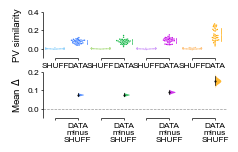

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Shuffle_ds_ds,Data_ds_ds,34,34,mean difference,baseline,0.076175,95,0.068393,0.083564,0.0,1.164153e-10,0.0,1.060089e-19,-19.528073
1,Shuffle_ds1_ds1,Data_ds1_ds1,34,34,mean difference,baseline,0.076288,95,0.068194,0.084433,0.0,1.164153e-10,0.0,1.842515e-18,-17.767001
2,Shuffle_ds2_ds2,Data_ds2_ds2,34,34,mean difference,baseline,0.090545,95,0.080736,0.099564,0.0,1.164153e-10,0.0,4.586471e-19,-18.607390
3,Shuffle_swr_swr,Data_swr_swr,34,34,mean difference,baseline,0.150722,95,0.128664,0.174027,0.0,1.164153e-10,0.0,1.487088e-14,-13.022203


In [34]:
###################################################################################################
## 2var dabest for shuffle versus data
###################################################################################################
idata = all_sim_dat
compare_shuffle = True

innerkey = ['shuffle','data']
outerkey = ['ds_ds','ds1_ds1','ds2_ds2','swr_swr']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']

col_groups = {'shuffle':'Shuffle',
              'data':'Data'
             }
####################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
####################################################################################################

if compare_shuffle:
    df_idx = [
                ['Shuffle_ds_ds',  'Data_ds_ds'],
                ['Shuffle_ds1_ds1','Data_ds1_ds1'],
                ['Shuffle_ds2_ds2','Data_ds2_ds2'],
                ['Shuffle_swr_swr','Data_swr_swr'],
             ]
    my_color_palette = [LIGHTBLUE,LIGHTGREEN,LIGHTPURPLE,LIGHTORNG2,BLUE,GREEN,PURPLE,ORNG]
    swarm_ylim = (-.1,.4)
    contrast_ylim =(-.05,.2)
    swarm_maj_loc = .2
    contrast_maj_loc = .1
    str_indx = 0
    max_char = 5
else:
    df_idx = [
                ['Data_ds2_ds2','Data_swr_swr'],
             ]
    my_color_palette = [PURPLE,ORNG]
    swarm_ylim = (-.1,.4)
    contrast_ylim =(-.05,.1)
    swarm_maj_loc = .2
    contrast_maj_loc = .1
    str_indx = -1
    max_char = 4
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 0.75*len(sbf.flatten(df_idx)),3.5
diff_type = 'mean'
swlab = 'PV similarity'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################


#######################################################################################################
size_scale = 2
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = sbf.generate_dabest_xtlabs(df_idx,max_char=max_char,str_indx=str_indx)
print(sw_xtlabs)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [36]:
######Save the figure###########################################################################
savefig = True
ctype_str = '_'.join(celltype)
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(np.unique(sw_xtlabs))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/CosSim/'
ftitle = 'Pearson_data_vs_shuffle_merged_sessions_' + '_'.join((group_type,
                                                              event_str,
                                                              ctype_str,
                                                              fsize_str
                                                            ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

Saving Pearson_data_vs_shuffle_merged_sessions_chr2_archT_DATA_SHUFF_pdg_p3_p1_6.0x3.5.svg to /Dupret_Lab/analysis/smchugh_analysis/figures/CosSim/
Time saved: 2024-07-19 16:33:25


In [37]:
##################################################################################################
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
##################################################################################################
def generate_train_inds(nEvents,train_prop=0.8,train_number=None,nprs=100,pprint=True):

    np.random.seed(nprs)
    
    if train_number is not None:
        train_size = int(train_number)
    else:
        train_size = int(train_prop * nEvents)
        
    test_size = nEvents - train_size
    if pprint:
        print('Total events:', nEvents)
        print('Training size:',train_size)
        print('Test size:',    test_size)

    return np.sort(np.random.choice(np.arange(nEvents),train_size,replace=False)).tolist()
###################################################################################################
def generate_test_inds(nEvents,train_inds):
    
    s = set(train_inds)
    li1 = np.arange(nEvents)
    
    return [x for x in li1 if x not in s]
####################################################################################################
def plot_confusion(confusion_norm,xticklabs,fmt=".0f"):
    '''
    
    '''
    ax = sns.heatmap(confusion_norm, annot=True, fmt=fmt, cmap='viridis', cbar=False)
    xlab = 'True labels'
    ylab = 'Predicted labels'
    ax.set_xticklabels(xticklabs)
    ax.set_yticklabels(xticklabs)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
####################################################################################################

In [38]:
chooser = 1
clf_list = [RandomForestClassifier(n_estimators=50, max_depth=2, random_state=0),
            LogisticRegression(max_iter=500),
            GaussianNB(),
            SVC(kernel='linear'),
           ]

clf_type_list = ['RFC','LogReg','GNB','SVC']
clf = clf_list[chooser]
clf_type = clf_type_list[chooser]
print(clf_type)

LogReg


In [59]:
############################################################################################
# Classifier
############################################################################################
iDict = bool_IFR_dict # new_IFR_dict # bool_IFR_dict #

event_list = ['ds','swr']
cond_list = ['prepulse','pulse','postpulse']
labels = np.arange(len(event_list))
print(labels)

train_prop = 0.75
nprs = 100 #int(np.random.randint(1,1000))

train_number = None
match_train_number = True
binarize = True

n_event_type = len(event_list)
n_mice = len(new_mouseID)
############################################################################################
all_clf_dat = {}
############################################################################################
for cond_indx,cond in enumerate(cond_list):
    
    output_conf_norm = np.zeros((n_event_type,n_event_type,n_mice))
    output_f1_score = np.zeros((n_mice))
    print(output_conf_norm.shape,output_f1_score.shape)
    print()

    odata = {}
    for mindx,mouse in enumerate(new_mouseID):

        n_cells = iDict[event_list[0]][mindx][cond].shape[0]
        print('n_cells =',n_cells)

        train_data = np.array([]).reshape(n_cells,0)
        test_data = np.array([]).reshape(n_cells,0)

        train_labels = np.array([])
        test_labels =  np.array([])

        max_bin = find_max_bin_1d(iDict,
                                  mindx,
                                  event_list,
                                  cond=cond)
        
        num_train_inds = int(max_bin * train_prop)
        num_test_inds = int(max_bin - num_train_inds)
        print('There are {0:} bins. training bins={1:}. Testing bins={2:}'.format(max_bin,num_train_inds,num_test_inds))
        
        for ev_indx,event in enumerate(event_list):

            label = ev_indx
            print(event,'label =',label)

            idata = iDict[event][mindx][cond]
            n_cells,n_events = idata.shape

            train_inds = generate_train_inds(n_events,
                                             train_prop=train_prop,
                                             train_number=train_number,
                                             nprs=nprs,
                                             pprint=False)
            
            test_inds =  generate_test_inds(n_events,train_inds)

            temp_train_labels = np.repeat(label,len(train_inds))
            temp_test_labels =  np.repeat(label,len(test_inds))

            temp_train_data = idata[:,train_inds]
            temp_test_data =  idata[:,test_inds]
            
            if binarize:
                temp_train_data = temp_train_data.astype(bool)
                temp_test_data =  temp_test_data.astype(bool)

            if match_train_number:
                print('match train and test number')
                temp_train_data = select_random_subset(temp_train_data,num_train_inds,axis=1)
                temp_test_data =  select_random_subset(temp_test_data,num_test_inds,axis=1)
                temp_train_labels = np.repeat(label,num_train_inds)
                temp_test_labels =  np.repeat(label,num_test_inds)

            train_data = np.concatenate((train_data,temp_train_data),axis=1)
            test_data =  np.concatenate((test_data, temp_test_data),axis=1)

            train_labels = np.concatenate((train_labels,temp_train_labels),axis=0)
            test_labels =  np.concatenate((test_labels, temp_test_labels),axis=0)
            print()

            #num_train_inds,num_test_inds = len(train_inds),len(test_inds)
        ########################################################################################################
        X_train = train_data.T
        y_train = train_labels

        X_test = test_data.T
        y_test = test_labels
        ########################################################################################################
        print('Training data, X = {0:}, y = {1:}'.format(X_train.shape,y_train.shape))
        print('Testing data, X = {0:},  y = {1:}'.format(X_test.shape,y_test.shape))
        print()
        #########################################################################################################
        if X_train.shape[1] > 1 and X_test.shape[0] > 1:

            # fit model
            my_clf = clf.fit(X_train, y_train)
            y_pred = my_clf.predict(X_test)

            print('model f1 = {0:.2f}'.format(metrics.f1_score(y_test, y_pred, average="macro") ))

            confusion_norm = confusion_matrix(y_test,y_pred,labels=labels,normalize='true')
            #plot_confusion(confusion_norm.T,event_list,fmt=".2f")
            #plt.show()
            
            output_conf_norm[:,:,mindx] = confusion_norm
            output_f1_score[mindx] = metrics.f1_score(y_test, y_pred, average="macro")
            
        for ev_indx,ev in enumerate(event_list):
            odata[ev]   = output_conf_norm[ev_indx,ev_indx,:]

        odata['both'] = output_f1_score
        print()
    all_clf_dat[cond] = odata
#################################################################################################################

[0 1]
(2, 2, 34) (34,)

n_cells = 45
There are 424 bins. training bins=318. Testing bins=106
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (636, 45), y = (636,)
Testing data, X = (212, 45),  y = (212,)

model f1 = 0.46

n_cells = 25
There are 102 bins. training bins=76. Testing bins=26
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (152, 25), y = (152,)
Testing data, X = (52, 25),  y = (52,)

model f1 = 0.63

n_cells = 43
There are 210 bins. training bins=157. Testing bins=53
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (314, 43), y = (314,)
Testing data, X = (106, 43),  y = (106,)

model f1 = 0.47

n_cells = 30
There are 316 bins. training bins=237. Testing bins=79
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (474, 30), y = (474,)
Testing data, X = (158, 3

model f1 = 0.44

n_cells = 29
There are 547 bins. training bins=410. Testing bins=137
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (820, 29), y = (820,)
Testing data, X = (274, 29),  y = (274,)

model f1 = 0.51

(2, 2, 34) (34,)

n_cells = 45
There are 424 bins. training bins=318. Testing bins=106
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (636, 45), y = (636,)
Testing data, X = (212, 45),  y = (212,)

model f1 = 0.63

n_cells = 25
There are 102 bins. training bins=76. Testing bins=26
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (152, 25), y = (152,)
Testing data, X = (52, 25),  y = (52,)

model f1 = 0.73

n_cells = 43
There are 210 bins. training bins=157. Testing bins=53
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (314, 43), y = (314,)
Testing data,


n_cells = 25
There are 102 bins. training bins=76. Testing bins=26
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (152, 25), y = (152,)
Testing data, X = (52, 25),  y = (52,)

model f1 = 0.63

n_cells = 43
There are 210 bins. training bins=157. Testing bins=53
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (314, 43), y = (314,)
Testing data, X = (106, 43),  y = (106,)

model f1 = 0.54

n_cells = 30
There are 316 bins. training bins=237. Testing bins=79
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (474, 30), y = (474,)
Testing data, X = (158, 30),  y = (158,)

model f1 = 0.52

n_cells = 37
There are 394 bins. training bins=295. Testing bins=99
ds label = 0
match train and test number

swr label = 1
match train and test number

Training data, X = (590, 37), y = (590,)
Testing data, X = (198, 37),  y = (198,)

model f

In [60]:
all_clf_dat['postpulse']['both']

array([0.49330549, 0.634375  , 0.53913043, 0.51971513, 0.54317063,
       0.51560961, 0.48095238, 0.57645306, 0.51053211, 0.56435049,
       0.51131222, 0.57777778, 0.50632095, 0.51071563, 0.5347751 ,
       0.61439469, 0.50343126, 0.50819672, 0.54944186, 0.53213213,
       0.52901128, 0.45920139, 0.58334598, 0.54045494, 0.53052756,
       0.49488481, 0.50560864, 0.47322846, 0.4989648 , 0.47327518,
       0.4340511 , 0.47592231, 0.45964912, 0.5074039 ])

In [61]:
test_prop = 0.5

for key,val in all_clf_dat.items():
    for key2,val2 in val.items():
        print(key,key2,stats.ttest_1samp(val2,test_prop))

prepulse ds TtestResult(statistic=0.6449795090980737, pvalue=0.5233994954500911, df=33)
prepulse swr TtestResult(statistic=1.2813423786768652, pvalue=0.20900443938169208, df=33)
prepulse both TtestResult(statistic=1.6566419954729599, pvalue=0.1070711719573219, df=33)
pulse ds TtestResult(statistic=10.850999719698597, pvalue=2.0143708721493394e-12, df=33)
pulse swr TtestResult(statistic=10.536122248948761, pvalue=4.308225755138623e-12, df=33)
pulse both TtestResult(statistic=13.013912208454425, pvalue=1.513624774688843e-14, df=33)
postpulse ds TtestResult(statistic=0.2404561790968516, pvalue=0.8114642056257919, df=33)
postpulse swr TtestResult(statistic=2.233138318170171, pvalue=0.032437582347327736, df=33)
postpulse both TtestResult(statistic=2.7184200480769807, pvalue=0.010372663148705566, df=33)


In [62]:
def cat_plot_clf(df,palette=(gray2,LIGHTPURPLE,ORNG,PURPLE),msize=2,ylim=(0,1),ytick_width=0.25,figsize=(4,4)):
    '''
    
    '''
    sns.reset_orig()
    ################################################################################
    
    mean_lw = 1.5
    lw = 0.5
    ls = '-'
    l_offset = .4
    alpha = 1.0

    xlab = ''
    ylab = 'Classifier accuracy'
    tfsize = 7
    pad = 1.5
    #################################################################################
    fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(figsize))

    ## Create scatterplot
    ax = sns.swarmplot(data=df,
                       x="sleep_event",
                       y="Data",
                       alpha=alpha,
                       size=msize,
                       palette=palette)
    ## Plot means
    df_mean = df.groupby('sleep_event', sort=False)['Data'].mean()
    _ = [ax.hlines(y, i-l_offset, i+l_offset, zorder=10, color='k',linewidth=mean_lw, 
                   linestyle=ls,alpha=.5) for i, y in df_mean.reset_index()['Data'].items()]

    # Set y-axis limit and tick width
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(Ticker.MultipleLocator(ytick_width))

    # Set x and y ticklabels fontsize
    ax.tick_params(axis='both', 
                   which='major',
                   labelsize=tfsize)

    # set axis bounds
    xlim = (0,len(np.unique(df.sleep_event))-1)
    ax = sbf.set_axis_bounds(ax,xlim,ylim,sp_len=3)

    # adjust plot
    ax = sbf.adjust_plot_pub(ax,
                            xlab=xlab,
                            ylab=ylab,
                            lw=lw,
                            raster=False,
                            nms=[80,80],
                            binwidth=2,
                            xtwidth=20,
                            xscale=1,
                            yscale=1,
                            xt_fmt='.0f',
                            yt_fmt='.2f',
                            fscale=[6,7],
                            grid=False,
                            pad=pad)
    
    return fig,ax
    ################################################################################################

prepulse_both
pulse_both
postpulse_both
102
102


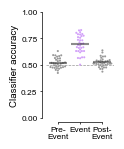

prepulse 0.51
pulse 0.69
cond1 xbar=0.514, cond2 xbar=0.691
t(33)=-11.58, p=0.000


In [63]:
################################################################################
idata = all_clf_dat
################################################################################
innerkey = ['prepulse','pulse','postpulse']
outerkey = ['both']

col_head = ['id','sleep','event','Data','sleep_event']
col_groups = {'prepulse':'prepulse',
              'pulse':'pulse',
              'postpulse':'postpulse'
             }
################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
################################################################################
figsize = (len(np.unique(df.sleep_event))*0.75,3.5)
fig,ax = cat_plot_clf(df,
                      palette=(gray2,LIGHTPURPLE,gray2,PURPLE),
                      msize=1.5,
                      ylim=(0,1),
                      ytick_width=0.25,
                      figsize=figsize)
ax.axhline(0.5,linewidth=0.5,linestyle='--',color=gray2)

## replace x-axis labels
lab_list = [x for x in ['Pre-\nEvent', 'Event','Post-\nEvent'] ]
ax.set_xticklabels(lab_list, minor=False)

plt.show()
################################################################################################
print('{0:} {1:.2f}'.format('prepulse',all_clf_dat['prepulse']['both'].mean()))
print('{0:} {1:.2f}'.format('pulse',all_clf_dat['pulse']['both'].mean()))
tval,pval = sbf.smc_ttest([all_clf_dat['prepulse']['both'],
                           all_clf_dat['pulse']['both']],
                           paired=True)
################################################################################################

In [64]:
######Save the figure###########################################################################
savefig = True
cell_str = '_'.join(celltype)
event_str = '_'.join(event_list)
fsize_str = 'x'.join((str(figsize[0]),str(figsize[1])))
opath = '/mnt/smchugh2/lfpd4/figures/Classifier/'
ftitle = clf_type + '_prepulse_vs_pulse_' + '_'.join((group_type,
                                                      event_str,
                                                      cell_str,
                                                      fsize_str
                                                      ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

Saving LogReg_prepulse_vs_pulse_chr2_archT_ds_swr_pdg_p3_p1_2.25x3.5.svg to /Dupret_Lab/analysis/smchugh_analysis/figures/Classifier/
Time saved: 2024-07-22 10:52:31


prepulse_both
pulse_both
postpulse_both
102
102


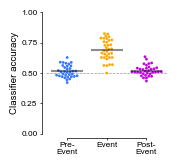

In [65]:
################################################################################
idata = all_clf_dat
################################################################################
innerkey = ['prepulse','pulse','postpulse']
outerkey = ['both']

col_head = ['id','sleep','event','Data','sleep_event']
col_groups = {'prepulse':'prepulse',
              'pulse':'pulse',
              'postpulse':'postpulse'
             }

df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
################################################################################
fig,ax = cat_plot_clf(df,palette=(BLUE,ORNG,PURPLE),msize=2,ylim=(0,1),ytick_width=0.25)
ax.axhline(0.5,linewidth=0.5,linestyle='--',color=gray2)
## replace x-axis labels
#lab_list = ['pre_ds','pre_swr','ds2','swr']
#lab_list = ['ds1','ds2','swr']
ax.set_xticklabels(lab_list, minor=False)

plt.show()
################################################################################################

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(figsize[0]),str(figsize[1])))
opath = '/mnt/smchugh2/lfpd4/figures/Classifier/'
ftitle = clf_type + '_ds_vs_swr_p1_p3_' + '_'.join((group_type,
                                                      fsize_str
                                                      ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
ikey = 'prepulse'

print(np.nanmean(all_clf_dat[ikey]['both']))
print(sbf.stdErr(all_clf_dat[ikey]['both']))

prepulse_ds
prepulse_swr
prepulse_both
pulse_ds
pulse_swr
pulse_both
postpulse_ds
postpulse_swr
postpulse_both
306
306


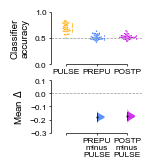

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,pulse_both,prepulse_both,34,34,mean difference,baseline,-0.177211,95,-0.207301,-0.148366,0.0,1.164153e-10,0.0,3.606095e-13,11.583649
1,pulse_both,postpulse_both,34,34,mean difference,baseline,-0.170893,95,-0.203181,-0.138939,0.0,2.328306e-10,1.0,4.855718e-12,10.487047


In [67]:
###################################################################################################
idata = all_clf_dat

outerkey = ['ds','swr','both']
innerkey = ['prepulse','pulse','postpulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']

col_groups = {'prepulse':'prepulse',
              'pulse':'pulse',
              'postpulse':'postpulse'
             }
####################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['prepulse_ds2','prepulse_swr'],
            ['pulse_ds2','pulse_swr'],
         ]

df_idx = [
            ['pulse_swr','pulse_ds'],
         ]

df_idx = [
            ['pulse_both','prepulse_both','postpulse_both'],
         ]
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 1.0*len(sbf.flatten(df_idx)),4
diff_type = 'mean'
swlab = 'Classifier\naccuracy'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
my_color_palette = [LIGHTBLUE,LIGHTORNG2,BLUE,ORNG,PURPLE,LIGHTORNG2,ORNG]
my_color_palette = [BLUE,ORNG,PURPLE,LIGHTORNG2,ORNG]
#######################################################################################################
size_scale = 2
swarm_ylim = (0,1)
contrast_ylim =(-.3,.1)
swarm_maj_loc = .5
contrast_maj_loc = .1
font_scale = (6,7,8)
pad = 1.5
lw = 0.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = sbf.generate_dabest_xtlabs(df_idx,max_char=5,str_indx=0)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)

swarm_ax.axhline(0.5,linestyle='--',color=gray2,linewidth=lw)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/Classifier/'
ftitle = 'Dabest_' + clf_type + '_ds_vs_swr_' + '_'.join((group_type,
                                                                cell_str,
                                                                fsize_str
                                                          ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
event_list = ['swr','ds']
cond = 'pulse'

all_event_weights = {}

for ev_indx,event in enumerate(event_list):

    all_weights = []
    for mindx,mouse in enumerate(new_mouseID[:1]):

        actmat = new_IFR_dict[event][mindx][cond]
        graph = get_graph_object(actmat)
        weights = np.array([d['weight'] for u,v,d in graph.edges(data=True)])
        print(mindx,mouse,event,weights.shape[0],np.nanmax(weights))
        all_weights.append(np.nanmax(weights))

    all_event_weights[event] = all_weights

In [ ]:
for key,val in all_event_weights.items():
    for mindx,mouse in enumerate(new_mouseID):
        print(mindx,mouse,key,np.nanmean(val[mindx]))

In [ ]:
#max_weight = np.array([d['weight'] for u,v,d in graph.edges(data=True)])

fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(40,8))
ax.plot(plt_data)

print(np.nanmax(plt_data))

In [ ]:
new_IFR_dict

In [ ]:
def generate_raster_from_IFR(idata,axoff=False,fwd=20,fht=10):
    '''
    
    '''
    from matplotlib import cm
    ######################################################################################
    lw=.5
    alpha=1.0
    sp_tick_height=.008
    rast_w=2.5
    v_ofs=0.01
    vert_offset = sp_tick_height + v_ofs
    rr,cc = 1,1
    sp_col = 'k'
    #######################################################################################
    fig, ax = plt.subplots(rr,cc,
                           figsize=sbf.cm2inch(fwd,fht),
                           gridspec_kw={'wspace':0,'hspace':0},
                           sharex=True)
    #######################################################################################
    
    n_cells = idata.shape[0]
    n_bins = idata.shape[1]
    
    all_ymin = 1
    clu_count = 0
    for clu_ in np.arange(n_cells):
        
        clu_offset = clu_count * vert_offset
        clu_count += 1
        
        ymin = (.98-sp_tick_height) - clu_offset
        #print(np.around(ymin,3))
        ymax = ymin + sp_tick_height
        
        if ymin < 0:
            print('ymin is off the screen for {0:}'.format(clu_))
        
        temp_dat = idata[clu_,:]
        
        #x_coords = np.array([x+np.random.uniform(-.2,.2) for x in np.nonzero(temp_dat)])
        x_coords = np.array([x for x in np.nonzero(temp_dat)])
        
        for indx,sp_ in enumerate(*x_coords):
            #print(sp_)
            ax.axvline(sp_,
                       ymin=ymin,
                       ymax=ymax,
                       linewidth=lw*rast_w,
                       color=sp_col)

    #all_ymin = np.nanmin([all_ymin,ymin])
    
    ax.set_xlim(0,idata.shape[1])
    #ax.set_ylim(all_ymin*2,1.2)
    if axoff:
        ax.set_axis_off()

    return fig,ax

In [ ]:
#################################################################################
## Generate plot based on IFRs with vline between two y points to indicate spikes
#################################################################################
#event = 'ds'

event_list = ['noevent','ds2','swr']
mindx = 8
cond = 'pulse'
use_max_bin = True
sort_by_rate = False
n_bins = 100
fwd,fht = 20,10

for ev_indx,event in enumerate(event_list):
    print(event)
    ###############################################################
    idata = new_IFR_dict[event][mindx][cond]
    print(idata.shape)
    ###############################################################
    if use_max_bin:
        idata = select_random_subset(idata,max_bin=n_bins)
    print(idata.shape)
    ###############################################################
    if sort_by_rate:
        vect_rate = np.sum(idata,axis=1)
        inds = np.argsort(vect_rate)[::-1]
        idata = idata[inds,:]
    #################################################################################
    fig,ax = generate_raster_from_IFR(idata,axoff=True,fwd=fwd,fht=fht)
    ax = sbf.adjust_plot_pub(ax)
    #################################################################################
    plt.show()
    #################################################################################

In [ ]:
event = 'swr'
cond = 'pulse'
y_offset = 5

idata = new_IFR_dict[event][mindx][cond][:,:]
n_cells = idata.shape[0]

odata = np.zeros(idata.shape)
for cindx in np.arange(n_cells):
    each_row = idata[cindx]
    inds = np.nonzero(each_row)
    odata[cindx,inds] = cindx + y_offset

In [ ]:
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(20,10),sharex=True)

for cindx in np.arange(n_cells): 
    ax.scatter(np.arange(odata.shape[1]),odata[cindx,:],c='k',marker=2,linewidths=0.4)

ax.set_ylim(15,n_cells+10)
ax.set_axis_off()
plt.show()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(20,10))
ax.imshow(idata,cmap='binary',aspect='auto')
ax.set_ylim(0,n_cells)
plt.show()

In [ ]:
## Calculate the percentage of events that a given cell is active in

idata = new_IFR_dict
event_list = ['noevent','ds1','ds2','swr']
cond_list = ['prepulse','pulse']

all_data = {}
for ev_indx,event in enumerate(event_list):
    cond_temp = {}
    for cond_indx,cond in enumerate(cond_list):
        each_mouse = []
        for mindx,mouse in enumerate(new_mouseID):
            temp_dat = idata[event][mindx][cond]
            n_cells = temp_dat.shape[0]

            temp_active = []
            for each_cell in np.arange(n_cells):
                try:
                    data_to_add = 100 * (np.squeeze(np.nonzero(temp_dat[each_cell,:])).shape[0] / temp_dat.shape[1])
                except IndexError:
                    data_to_add = np.nan
                #print(data_to_add)
                temp_active.append(data_to_add)
            print(event,mouse,temp_dat.shape)
            each_mouse.extend(temp_active)
        cond_temp[cond] = np.array(each_mouse)
    all_data[event] = cond_temp

In [ ]:
for mindx,mouse in enumerate(new_mouseID):
    print(mouse)
    for ev_indx,event in enumerate(event_list):
        print(event,np.nanmean(all_data[event][cond][mindx]))
    print()

In [ ]:

for key,val in all_data.items():
    print(key,val['pulse'].shape,np.nanmean(val['pulse']),np.nanmin(val['pulse']),np.nanmax(val['pulse']))
print()
for key,val in all_pc_active_per_session.items():
    print(key,val['pulse'].shape,np.nanmean(val['pulse']),np.nanmin(val['pulse']),np.nanmax(val['pulse']))

In [ ]:
###################################################################################################
idata = all_data
###################################################################################################
innerkey = sbf.keys_to_list(idata)
print(innerkey)

outerkey = ['prepulse','pulse']

col_head = ['id','Event_Type','Sess_Type','Data','Group_sess']
col_groups = {'ds':'ds',
              'swr':'swr',
              'noevent':'baseline',
              'both':'both',
              'ds1':'ds1',
              'ds2':'ds2',
             }
####################################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['ds_prepulse','swr_prepulse'],
            ['ds_pulse','swr_pulse'],
         ]

df_idx = [
            ['baseline_pulse','ds1_pulse','ds2_pulse','swr_pulse'],
         ]

'''df_idx = [
            ['ds2_pulse','swr_pulse'],
         ]'''
#####################################################################################################
paired = None #'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )
######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 1.25*len(sbf.flatten(df_idx)),4
diff_type = 'mean'
swlab = 'Cells active (%)'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
my_color_palette = get_event_palette(df_idx)
#######################################################################################################
size_scale = 2
swarm_ylim = (-5,60)
contrast_ylim =(-5,20)
swarm_maj_loc = 20
contrast_maj_loc = 10
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = generate_dabest_xtlabs(df_idx,max_char=4)
print(sw_xtlabs,con_xtlabs)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
def compare_entropy(matrix1,matrix2):

    '''
    matrix1 = np.array([[1, 0, 3],
                        [0, 5, 0],
                        [0, 0, 0]])

    matrix2 = np.array([[0, 2, 0],
                        [0, 0, 0],
                        [4, 0, 0]])
    '''
    from scipy.stats import entropy
    
    non_zero_elements1 = matrix1.flatten()[matrix1.flatten() != 0]
    non_zero_elements2 = matrix2.flatten()[matrix2.flatten() != 0]

    entropy1 = entropy(non_zero_elements1)
    entropy2 = entropy(non_zero_elements2)

    sparsity1 = 1 - (len(non_zero_elements1) / len(matrix1.flatten()))
    sparsity2 = 1 - (len(non_zero_elements2) / len(matrix2.flatten()))

    max_entropy1 = np.log(len(non_zero_elements1))
    max_entropy2 = np.log(len(non_zero_elements2))

    normalized_entropy1 = entropy1 / max_entropy1
    normalized_entropy2 = entropy2 / max_entropy2

    print("Normalized Entropy (Matrix 1):", normalized_entropy1)
    print("Normalized Entropy (Matrix 2):", normalized_entropy2)
    
    return normalized_entropy1,normalized_entropy2

In [ ]:
iDict = new_IFR_dict
rand_subset = True

event_1 = 'ds'
event_2 = 'swr'
cond = 'pulse'

odata = {}

temp_ev1 = []
temp_ev2 = []
for mindx,mouse in enumerate(new_mouseID):

    max_bin = find_max_bin_1d(iDict,
                              mindx,
                              event_list=[event_1,event_2],
                              cond=cond)
    print(mouse,max_bin)

    A = iDict[event_1][mindx][cond]
    B = iDict[event_2][mindx][cond]
    print(A.shape,B.shape,max_bin)

    if rand_subset:
        A = select_random_subset(A,max_bin,axis=1)
        B = select_random_subset(B,max_bin,axis=1)
    print(A.shape,B.shape)

    normalized_entropy1,normalized_entropy2 = compare_entropy(A,B)
    
    temp_ev1.append(normalized_entropy1)
    temp_ev2.append(normalized_entropy2)
    
    print()
    
odata[event_1] = np.array(temp_ev1)
odata[event_2] = np.array(temp_ev2)

In [ ]:
event_list = [event_1,event_2]

for ev_indx,event in enumerate(event_list):
    print(event,cond,np.nanmean(odata[event]),sbf.stdErr(odata[event]))

tval,pval = sbf.smc_ttest([odata[event_1],odata[event_2]],cond_list=event_list,paired=True)

In [ ]:
event = 'swr'
event_list = ['ds','swr']
cond = 'pulse'
cond_list = ['prepulse','pulse']

n_mice = len(new_mouseID)
fwd,fht = 10,4*len(new_mouseID)
xlim = (0,15)


fig,ax = plt.subplots(n_mice,1,figsize=sbf.cm2inch(fwd,fht),sharex=True)

for mindx,mouse in enumerate(new_mouseID):
    for ev_indx,event in enumerate(event_list):
        idata = new_IFR_dict[event][mindx][cond]
        test_max = np.nanmax(idata,axis=0)
        #print(test_max.shape)
        #print(idata.shape)
        ax[mindx].hist(test_max,bins=11,density=True,alpha=0.5)
    ax[mindx].set_xlim(xlim)
    ax[mindx].set_title(mouse + '_' + str(test_max.shape[0]) + '_events')

plt.tight_layout()
plt.show()

In [ ]:
for key,val in all_mice_clust.items():
    for key2,val2 in val.items():
        print(key,key2,val2.shape)

#all_mice_clust['swr']['pulse'].shape

In [ ]:
################################################################################
idata = all_mice_clust
################################################################################
innerkey = ['ds','swr']
outerkey = ['pulse']

col_head = ['id','sleep','event','Data','sleep_event']
col_groups = {'ds':'ds',
              'swr':'swr'
             }
################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
################################################################################
figsize = (len(np.unique(df.sleep_event))*1.25,4)
fig,ax = cat_plot_clf(df,palette=(gray2,LIGHTPURPLE,ORNG,PURPLE),msize=1.5,ylim=(0,1),ytick_width=0.25,figsize=figsize)
ax.axhline(0.5,linewidth=0.5,linestyle='--',color=gray2)

## replace x-axis labels
lab_list = [x for x in ['ds', 'swr'] ]
ax.set_xticklabels(lab_list, minor=False)

plt.show()
################################################################################################

In [ ]:
event = 'ds1'

for mindx,mouse in enumerate(new_mouseID):
    actmat = new_IFR_dict[event][mindx]['pulse']
    print(mindx,mouse,actmat.shape)

In [ ]:
mindx = 15
event_list = ['ds','swr']
cond = 'pulse'

G_pair = {}
G_pop = {}
for ev_indx,event in enumerate(event_list):
    actmat = new_IFR_dict[event][mindx][cond]
    G_pair[event],G_pop[event] = ggg.GLMgraph_lin(actmat.T, symm=0)
    print(event,cond,actmat.shape)

In [ ]:
event = 'ds'
G = G_pair[event]

fwd,fht = 3,3
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
minn = -.05
maxx = .05
xlab = '# principal cells'
ylab = '# principal cells'

ax = sns.heatmap(G, cmap='seismic', center=0, vmin=minn, vmax=maxx)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=6)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=6, rotation=None)

ax.set_xticks([0,G.shape[0]], ['0', str(G.shape[0])])
ax.set_yticks([0,G.shape[0]], ['0', str(G.shape[0])])

sns.despine()
ax = sbf.adjust_plot_pub(ax,xlab=xlab,ylab=ylab,grid=False,fscale=(6,7))
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_ylabel('Coactivity [$\\beta$]',fontsize=7)

plt.show()

fig = ax.get_figure()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = '_'.join(('Heatmap',
                   new_mouseID[mindx],
                   event,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
# graph
fwd,fht = 4,4
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
ggg.plotWeightedGraph(G, graphType='spring', scale=0.04, norm=1, Labels=0, nodeC=[.3, .3, .3],
                      nodeSize=5, posC=RED, negC=BLUE, Alpha=0.8)

plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = '_'.join(('Weight_graph',
                   new_mouseID[mindx],
                   event,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
event = 'ds'
G = G_pair[event]

In [ ]:
print(new_mouseID[mindx],event)

reduced_n = 8
IND = [0,1,2,3,4,5,6,7]

nprs = 25
np.random.seed(nprs)
#IND = np.random.randint(0,G.shape[0],reduced_n)

adjmat = G.copy()

IX = np.ix_(IND,IND)
GGG = adjmat[IX]

G2 = nx.Graph(GGG)
avgS = np.mean(GGG.sum(0)) # average neurons co-firing strength
avgClu = np.mean(list(ggg.clustering(G2,weight='weight').values())) # average clustering
pred,dist = ggg.weightedPLpos_pred(GGG.copy())
avgPL = np.nanmean(dist) # average PL

# PLOTTING
fwd,fht = 2.5,2.5
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))

ax = sns.heatmap(GGG, cmap='seismic', center=0, vmin=-.1 ,vmax=.1)#,
            #cbar_kws={'label':})
plt.axis('off')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_ylabel('Coactivity [$\\beta$]',fontsize=7)
plt.show()
fig = ax.get_figure()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = '_'.join(('Heatmap_subset',
                   new_mouseID[mindx],
                   event,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
# graph
fwd,fht = 2.5,2.5
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
ggg.plotWeightedGraph(GGG, graphType='circ', scale=.3, nodeSize=5, Labels=False,
                     nodeC='k', posC=RED, )
print('Event %4s Co-firing Strength %.2f | Geo path length %.1f | Clustering coeff %.3f'%(event,avgS,avgPL,avgClu))

plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = '_'.join(('Weight_graph_subset',
                   new_mouseID[mindx],
                   event,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
### Raster
from matplotlib.ticker import FormatStrFormatter

#fwd,fht = 3,3.2
fwd,fht = 3,6

mindx = 15
event = 'swr'
cond = 'pulse'

actmat = new_IFR_dict[event][mindx][cond]
print(actmat.shape)

start_ind = 60
end_ind = start_ind + 120
actmat_ = actmat[:,start_ind:end_ind]
print(actmat_.shape)
spk2d = [np.where(actmat_[cid,:]) for cid in range(actmat_.shape[0])]

np.random.seed(11)
colors_ = ['red'] + ['blue'] + ['k' for _ in range(len(spk2d)-2)]
lengths_ = [.6,.6] + [.4 for _ in range(len(spk2d)-2)]
idx_ = np.random.choice(range(len(spk2d)), len(spk2d), replace=False).astype(int)
spk2d = np.squeeze([spk2d[i] for i in idx_])


fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht)) #,sharex=True)
y_maj_loc = 25
yt_fmat = '.0f'

color = 'k'
ax.eventplot(spk2d,color=colors_,linewidths=lw,linelengths=lengths_)
ax.set_ylim(-.4,actmat_.shape[0]);
ax.yaxis.set_major_locator(Ticker.MultipleLocator(y_maj_loc))

yticks = ax.get_yticks().tolist()
yticks = [format(y,yt_fmat) for y in yticks]
ax.set_yticklabels(yticks, rotation=0, fontsize=6)

sns.despine(bottom=True)
ax.set_xticks([]);

ax = sbf.adjust_plot_pub(ax,ylab='# principal cells',fscale=(6,7),grid=False)

plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = '_'.join(('Raster_plot',
                   new_mouseID[mindx],
                   event,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
#fwd,fht = 3,.6
fwd,fht = 3,.8

mean_rate = savgol(np.nansum(actmat_[1:,:],axis=0),9,1)

fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
ax.plot(mean_rate,linewidth=lw*2,color='k')
ax.fill_between(np.arange(mean_rate.shape[0]),np.zeros(mean_rate.shape[0]),mean_rate,color=PURPLE,alpha=0.6)
plt.axis('off')
plt.show()
print(int(np.max(mean_rate)))

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/ClustCoeff/'
ftitle = '_'.join(('Mean_rate_plot',
                   new_mouseID[mindx],
                   event,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
## PCA

import smPcaFunctions3 as spf

thrs = 0.9
norm = True
min_comp = 2

iDict = new_IFR_dict
event_list = ['ds1','ds2','swr']
cond = 'pulse'

pc_dict = {}
for key,val in iDict.items():
    print(key,len(val))
    tempdat = []
    for mindx,mouse in enumerate(new_mouseID):
        max_bin = find_max_bin_1d(iDict,
                                  mindx,
                                  event_list,
                                  cond=cond)
        idata = val[mindx][cond]
        idata = select_random_subset(idata,max_bin=max_bin,axis=1)
        pc_var = spf.calc_pca_single_matrix(idata,thrs=thrs,norm=norm,min_comp=min_comp)
        tempdat.append(pc_var)
        print(mindx,mouse,idata.shape,pc_var)
    pc_dict[key] = np.array(tempdat)

In [ ]:
key1 = 'ds2'
key2 = 'swr'

diff_score = [(a-b)/(abs(a)+abs(b)) for (a,b) in zip(pc_dict[key1],pc_dict[key2])]

diff_score = np.array(diff_score)

In [ ]:
cond_1 = key1
cond_2 = key2
data_1 = pc_dict[cond_1]
data_2 = pc_dict[cond_2]
print(data_1.mean(),data_2.mean())

tval,pval = sbf.smc_ttest([data_1,data_2],cond_list=[cond_1,cond_2],paired=True)

wilc,wilc_pval = stats.wilcoxon(data_1,data_2)

print('U={0:.1f}; p={1:.3f}'.format(wilc,wilc_pval))

In [ ]:
stats.ttest_1samp(diff_score,0)

In [ ]:
###################################################################################################
idata = pc_dict

innerkey = ['noevent','swr','ds','ds1','ds2']

col_head = ['id','ikey','Data','Group_sess']
col_groups = {
              'noevent': 'BASE',
              'ds':   'DS',
              'ds1':  'DS1',
              'ds2':  'DS2',
              'swr': 'SWR',
             }
####################################################################################################
df = sbf.dabest_long_df_1var(idata,innerkey,col_groups,col_head)
####################################################################################################
df_idx = [
            ['BASE','DS','SWR','DS_SWR','DS_BASE','SWR_BASE'],
         ]

df_idx = [
            ['BASE','DS','DS1','DS2','SWR'],
         ]

df_idx = [
            ['BASE','SWR','DS'],
         ]
'''df_idx = [
            ['DS1','DS2'],
         ]'''

'''df_idx = [
            ['SWR','DS1','DS2'],
         ]'''
#####################################################################################################
paired = 'baseline'
analysis_of_long_df = db2.load(df,
                              x="Group_sess", 
                              y="Data",
                              idx=((df_idx)),
                              paired=paired,
                              id_col="id"
                              )

######################################################################################################
show_pairs = False
######################################################################################################
fwd,fht = 1.25*len(sbf.flatten(df_idx)),4

fwd,fht = 2.5,3.5
diff_type = 'mean'
swlab = 'Dimensionality'
if diff_type == 'mean':
    eslab = 'Mean ' + r'$\Delta$'
    stats_test = analysis_of_long_df.mean_diff.statistical_tests
elif diff_type == 'median':
    eslab = 'Median ' + r'$\Delta$'
    stats_test = analysis_of_long_df.median_diff.statistical_tests
#######################################################################################################
my_color_palette = get_event_palette(df_idx)
#######################################################################################################
size_scale = 2
swarm_ylim = (0,1)#None#(-.05,.6)
contrast_ylim = (-.1,.2)
swarm_maj_loc = .5
contrast_maj_loc = .1
font_scale = (6,7,8)
pad = 1.5
bw_method = .5 #sbf.calc_mean_bw(idata,innerkey,outerkey)
########################################################################################################
fig,swarm_ax,contrast_ax = sbf.smdabest_plot(analysis_of_long_df,
                                             diff_type=diff_type,
                                             figsize=[fwd,fht],
                                             size_scale=size_scale,
                                             swarm_ylim=swarm_ylim,
                                             contrast_ylim=contrast_ylim,
                                             my_color_palette=my_color_palette,
                                             swlab=swlab,
                                             eslab=eslab,
                                             fs=font_scale,
                                             show_pairs=show_pairs,
                                             maj_loc=[swarm_maj_loc,contrast_maj_loc],
                                             bw_method=bw_method
                                            )
########################################################################################################
sw_xtlabs,con_xtlabs = generate_dabest_xtlabs(df_idx)
swarm_ax.set_xticklabels(sw_xtlabs)
contrast_ax.set_xticklabels(con_xtlabs)
########################################################################################################
plt.show()
########################################################################################################
analysis_of_long_df.mean_diff.statistical_tests
########################################################################################################

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(sw_xtlabs)

opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/PCA/' + group_type + '/'
ftitle = '_'.join(('PCA',
                   event_str,
                   cond,
                   ctype_str,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
def pca_on_dict(iDict,new_mouseID,cond='pulse',event_list=['ds','swr'],thrs=0.8,norm=True,min_comp=2):
    '''
    
    '''
    pc_dict = {}
    for key,val in iDict.items():
        #print(key,len(val))
        tempdat = []
        for mindx,mouse in enumerate(new_mouseID):
            max_bin = find_max_bin_1d(iDict,
                                      mindx,
                                      event_list,
                                      cond=cond)
            #print(mouse,max_bin)
            idata = val[mindx][cond]
            idata = select_random_subset(idata,max_bin=max_bin,axis=1)
            pc_var = spf.calc_pca_single_matrix(idata,thrs=thrs,norm=norm,min_comp=min_comp)
            tempdat.append(pc_var)
            #print(idata.shape,pc_var)
        pc_dict[key] = np.array(tempdat)
        
    return pc_dict

In [68]:
cell_count = []
for mindx,mouse in enumerate(new_mouseID):
    cell_count.append(new_IFR_dict['noevent'][mindx]['pulse'].shape[0])
    print(new_IFR_dict['noevent'][mindx]['pulse'].shape)
    
print(np.nanmean(cell_count),sbf.stdErr(cell_count))

(45, 6304)
(25, 5339)
(43, 3194)
(30, 4059)
(37, 3471)
(28, 6118)
(24, 4484)
(28, 2801)
(30, 3567)
(37, 5409)
(24, 3841)
(23, 3768)
(38, 6704)
(48, 3403)
(46, 7048)
(55, 6452)
(23, 4956)
(28, 4927)
(42, 5564)
(46, 3147)
(38, 3488)
(36, 4714)
(62, 3803)
(41, 3518)
(57, 3545)
(53, 5523)
(37, 4728)
(40, 5180)
(46, 5468)
(25, 10312)
(35, 3620)
(22, 6373)
(44, 4007)
(29, 6131)
37.205882352941174 1.8181987606301273


In [ ]:
## Produce plot for continuous variance explained PCA

thrs_vals = np.arange(0.70,0.96,0.01)
norm = True
parametric = False
paired = True
alternative = 'greater' #'two-sided'

iDict = new_IFR_dict#new_IFR_dict

event_list=['ds2','swr']

pval_list = []
for thrs in thrs_vals:
    pc_dict = pca_on_dict(iDict,new_mouseID,cond='pulse',event_list=event_list,thrs=thrs,norm=norm,min_comp=2)
    
    cond_1 = event_list[0]
    cond_2 = event_list[1]
    data_1 = pc_dict[cond_1]
    data_2 = pc_dict[cond_2]

    if parametric:
        tval,pval = sbf.smc_ttest([data_1,data_2],cond_list=[cond_1,cond_2],paired=paired)
    else:
        tval,pval = stats.wilcoxon(data_1,data_2,alternative=alternative)
    pval_list.append(pval)

pval_list = np.array(pval_list)

In [ ]:
print(pval_list.shape,thrs_vals.shape)

In [ ]:
sns.reset_orig()

fwd,fht = 4,4
xlim = (0.7,0.95)
ylim = (0,.1)
xtick_width = 0.05
ytick_width = 0.05
lw = 0.5

xlab = 'Variance explained (%)'
ylab = 'Probability'

fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))

ax.plot(thrs_vals,pval_list,linewidth=lw,color='k')
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(Ticker.MultipleLocator(xtick_width))
ax.yaxis.set_major_locator(Ticker.MultipleLocator(ytick_width))

ax.axhline(0.05,linewidth=lw,linestyle='--',color=BLUE)

ax = sbf.set_axis_bounds(ax,xlim=xlim,ylim=ylim)
ax = sbf.adjust_plot_pub(ax,
                         xt_fmt='.2f',
                         yt_fmt='.2f',
                         xlab=xlab,
                         ylab=ylab,
                         grid=False,
                         fscale=(6,7))
plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(sw_xtlabs)
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/PCA/' + group_type + '/'
ftitle = '_'.join(('PCA_pvals_75_99_one_tailed',
                   event_str,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
thrs_vals = np.arange(0,0.96,0.01)
norm = False

iDict = new_IFR_dict # bool_IFR_dict #new_IFR_dict

event_list=['ds1','ds2','swr']

n_thrs_vals = len(thrs_vals)
n_mice = 34
n_events = len(event_list)

output_matrix = np.zeros((n_thrs_vals,n_mice,n_events))
for thrs_indx,thrs in enumerate(thrs_vals):
    pc_dict = pca_on_dict(iDict,new_mouseID,cond='pulse',event_list=event_list,thrs=thrs,norm=norm,min_comp=2)
    
    for ev_indx,event in enumerate(event_list):
        output_matrix[thrs_indx,:,ev_indx] = np.array(pc_dict[event])
    
output_matrix.shape

In [ ]:
event_palette = {'noevent':gray2, 'ds1':GREEN, 'ds2':PURPLE, 'swr':ORNG}

output_matrix.shape


fwd,fht = 4,4
xlim = (0,25)
#xlim = (0.2,1)
ylim = (.7,1.0)
xtick_width = 5
ytick_width = .1
lw = 0.5
marker = None
markersize = 1

xlab = 'Number of components'
ylab = 'Variance explained (%)'

fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
for ev_indx,event in enumerate(event_list):
    idata = np.nanmean(output_matrix[:,:,ev_indx],axis=-1)
    xpts = idata
    ypts = thrs_vals
    pos_err,neg_err = sbf.calc_err_bars(output_matrix[:,:,ev_indx],axis=1,savgol=False,npts=1)
    #print(pos_err,neg_err)
    ax.plot(xpts,ypts,linewidth=lw,color=event_palette[event],marker=marker,markersize=markersize)
    #ax.errorbar(xpts,ypts,xerr=pos_err,linewidth=lw,color=event_palette[event],marker=None)
    #pos_err,neg_err = sbf.calc_err_bars(idata,axis=1,savgol=False,npts=npts)
    #ax.fill_between(xpts,neg_err,pos_err,color=cellcol[ctype],alpha=0.2)
    
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.xaxis.set_major_locator(Ticker.MultipleLocator(xtick_width))
ax.yaxis.set_major_locator(Ticker.MultipleLocator(ytick_width))

ax = sbf.set_axis_bounds(ax,xlim=xlim,ylim=ylim)
ax = sbf.adjust_plot_pub(ax,
                         xt_fmt='.0f',
                         yt_fmt='.1f',
                         xlab=xlab,
                         ylab=ylab,
                         grid=False,
                         fscale=(6,7))
plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(sw_xtlabs)
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/PCA/' + group_type + '/'
ftitle = '_'.join(('PCA_ncomp_vs_var_expl_0_100',
                   event_str,
                   cond,
                   group_type,
                   fsize_str
                  ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
total = pval_list.shape[0]
prop = pval_list[pval_list < 0.05].shape[0]
print(prop,total,prop/total)

In [ ]:
new_mouseID

In [ ]:
mindx = 1

for key,val in bool_IFR_dict.items():
    print(key)
    for mindx,mouse in enumerate(new_mouseID):
        for key2,val2 in val[mindx].items():
            print(mindx,mouse,key2,val2.shape)

In [ ]:
mindx = 4
for key,val in bool_IFR_dict.items():
    print(key)
    for key2,val2 in val[mindx].items():
        print(mindx,mouse,key2,val2.shape)

In [ ]:
n_bins = 12
n_rows = 12

event = 'swr'
mindx = 5
okey = 'pulse'

idata = bool_IFR_dict[event][mindx][okey]

idata = select_random_subset(idata,n_bins,axis=1,nprs=86)
idata = select_random_subset(idata,n_rows,axis=0,nprs=2)

print(idata.shape)

idata = idata + 0

n_train_trials = int(n_bins * 0.75)
n_cells = idata.shape[0]

cell_col = None

rr,cc = 1,1
fwd,fht = 7,0.1
fig,ax = plt.subplots(rr,cc,figsize=sbf.cm2inch(fwd,fht))

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)

the_table = ax.table(cellText=idata,
                     cellColours=cell_col,
                     cellLoc='center',
                     rowLoc='center',
                     loc='top')

cell_col = "#eaeded"
row_list = np.arange(n_cells)
col_list = np.arange(n_train_trials)

for each_row in row_list:
    for each_col in col_list:
        the_table[(each_row, each_col)].set_facecolor(cell_col)

cell_col = '#fcf3cf' #'#d6eaf8'  #fcf3cf 
col_list = np.arange(n_train_trials,n_bins)
for each_row in row_list:
    for each_col in col_list:
        the_table[(each_row, each_col)].set_facecolor(cell_col)

the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/Classifier/'
ftitle = 'Table_diagram_' + '_'.join((group_type,
                               fsize_str
                              ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
##############################################################################
# PV Similarity each mouse alone
##############################################################################
iDict = bool_IFR_dict
event_pair_list = [
                    ['noevent','noevent'],
                    ['swr','swr'],
                    ['ds','ds']
                  ]
print(event_pair_list)
#############################################################################
rand_subset = True
binarize = True
shuffle_list = [False,True]
cond = 'pulse'
##############################################################################
sim_metric_list = [ggg.corr_metric,ggg.cosine_metric]
sim_metric = sim_metric_list[0] # ggg.cosine_metric
output_dat = 'mean'
##############################################################################
all_pv_mice_indiv = []
for mindx,mouse in enumerate(new_mouseID):
    sim_dat = {}
    for ev_indx,event_pair in enumerate(event_pair_list):

        print(event_pair)
        event_1 = event_pair[0]
        event_2 = event_pair[1]

        max_bin = find_max_bin_1d(iDict,
                                  mindx,
                                  event_list=['ds','swr'],
                                  cond=cond)
        print('max_bin is',max_bin)

        A = iDict[event_1][mindx][cond]
        B = iDict[event_2][mindx][cond]
        print(A.shape,B.shape,max_bin)

        if rand_subset:
            A = select_random_subset(A,max_bin,axis=1)
            B = select_random_subset(B,max_bin,axis=1)

        if binarize:
            A = A.astype(bool)
            B = B.astype(bool)

        if sim_metric == ggg.cosine_metric:
            print('cosine')   
        elif sim_metric == ggg.corr_metric:
             print('pearson')
        else:
            print('jaccard')

        print(A.shape,B.shape,A[0,:].mean(), B[0,:].mean())
        sim_mat = sim_metric(A.T,B.T)
        print('sim_mat shape',sim_mat.shape)

        try:
            upper_tri,_ = scf.gen_upper_tri(sim_mat)
        except IndexError:
            upper_tri = np.zeros((1,1))

        okey = '_'.join((event_1,event_2))
        sim_dat[okey] = upper_tri
    all_pv_mice_indiv.append(sim_dat)
#########################################################################################

In [ ]:
mids

In [ ]:
mids = np.unique([x[:5] for x in new_mouseID])

#############################################################################################
all_combined_dat = {}
#############################################################################################
for ev_indx,key_pair in enumerate(event_pair_list):
    #combined_each_mouse_dat = [{} for x in range(n_mice)]
    combined_each_mouse_dat = {x:np.array([]) for x in mids}
    
    event_pair = '_'.join((key_pair[0],
                           key_pair[1]))
    print(event_pair)
    combined_each_mouse_dat['msm04'] = all_pv_mice_indiv[0][event_pair]

    combined_each_mouse_dat['msm08'] = all_pv_mice_indiv[1][event_pair]

    combined_each_mouse_dat['msm10'] = np.concatenate((all_pv_mice_indiv[2][event_pair],
                                                 all_pv_mice_indiv[3][event_pair],
                                                 all_pv_mice_indiv[4][event_pair],
                                                 all_pv_mice_indiv[5][event_pair],
                                                 all_pv_mice_indiv[6][event_pair],
                                                 all_pv_mice_indiv[7][event_pair],
                                                 all_pv_mice_indiv[8][event_pair],
                                                 all_pv_mice_indiv[9][event_pair],
                                                ))
    
    combined_each_mouse_dat['msm11'] = np.concatenate((all_pv_mice_indiv[10][event_pair],
                                                 all_pv_mice_indiv[11][event_pair],
                                                 all_pv_mice_indiv[12][event_pair],
                                                 all_pv_mice_indiv[13][event_pair],
                                                 all_pv_mice_indiv[14][event_pair],
                                                 all_pv_mice_indiv[15][event_pair],
                                                 all_pv_mice_indiv[16][event_pair],
                                                ))

    combined_each_mouse_dat['msm12'] = np.concatenate((all_pv_mice_indiv[17][event_pair],
                                                 all_pv_mice_indiv[18][event_pair],
                                                 all_pv_mice_indiv[19][event_pair],
                                                 all_pv_mice_indiv[20][event_pair],
                                                 all_pv_mice_indiv[21][event_pair],
                                                 all_pv_mice_indiv[22][event_pair],
                                                 all_pv_mice_indiv[23][event_pair],
                                                 all_pv_mice_indiv[24][event_pair],
                                                 all_pv_mice_indiv[25][event_pair],
                                                 all_pv_mice_indiv[26][event_pair],
                                                 all_pv_mice_indiv[27][event_pair],
                                                 all_pv_mice_indiv[28][event_pair],
                                                ))

    combined_each_mouse_dat['msm13'] = np.concatenate((all_pv_mice_indiv[29][event_pair],
                                                 all_pv_mice_indiv[30][event_pair],
                                                 all_pv_mice_indiv[31][event_pair],
                                                ))

    combined_each_mouse_dat['msm16'] = np.concatenate((all_pv_mice_indiv[32][event_pair],  
                                                ))

    combined_each_mouse_dat['msm17'] = np.concatenate((all_pv_mice_indiv[33][event_pair],  
                                                ))
    
    all_combined_dat[event_pair] = combined_each_mouse_dat

In [ ]:
################################################################################
idata = all_combined_dat
################################################################################
innerkey = ['noevent_noevent','swr_swr','ds_ds']
outerkey = sbf.keys_to_list(all_combined_dat['swr_swr'])

col_head = ['id','event','mouseid','Data','event_mouseid']
col_groups = {'noevent_noevent':'No-Event',
              'swr_swr':'SWR',
              'ds_ds':'DS'
             }
################################################################################
df = sbf.dabest_long_df_2var(idata,innerkey,outerkey,col_groups,col_head)
################################################################################

In [ ]:
df = []

In [ ]:
sns.pointplot(data=df,x='event',y='Data',hue='mouseid',errorbar=('ci',99))

In [ ]:
plt.show()

In [ ]:
#############################################################################################
n_mice = 8
mids = [x[:5] for x in np.unique(mouseID)]
#############################################################################################
all_combined_dat = {}
#############################################################################################
for ev_indx,key_pair in enumerate(event_pair_list):
    combined_each_mouse_dat = [{} for x in range(n_mice)]
    
    event_pair = '_'.join((key_pair[0],
                           key_pair[1]))
    print(event_pair)
    combined_each_mouse_dat[0] = all_pv_mice_indiv[0][event_pair]

    combined_each_mouse_dat[1] = all_pv_mice_indiv[1][event_pair]

    combined_each_mouse_dat[2] = np.concatenate((all_pv_mice_indiv[2][event_pair],
                                                 all_pv_mice_indiv[3][event_pair],
                                                 all_pv_mice_indiv[4][event_pair],
                                                 all_pv_mice_indiv[5][event_pair],
                                                 all_pv_mice_indiv[6][event_pair],
                                                 all_pv_mice_indiv[7][event_pair],
                                                 all_pv_mice_indiv[8][event_pair],
                                                 all_pv_mice_indiv[9][event_pair],
                                                ))
    
    combined_each_mouse_dat[3] = np.concatenate((all_pv_mice_indiv[10][event_pair],
                                                 all_pv_mice_indiv[11][event_pair],
                                                 all_pv_mice_indiv[12][event_pair],
                                                 all_pv_mice_indiv[13][event_pair],
                                                 all_pv_mice_indiv[14][event_pair],
                                                 all_pv_mice_indiv[15][event_pair],
                                                 all_pv_mice_indiv[16][event_pair],
                                                ))

    combined_each_mouse_dat[4] = np.concatenate((all_pv_mice_indiv[17][event_pair],
                                                 all_pv_mice_indiv[18][event_pair],
                                                 all_pv_mice_indiv[19][event_pair],
                                                 all_pv_mice_indiv[20][event_pair],
                                                 all_pv_mice_indiv[21][event_pair],
                                                 all_pv_mice_indiv[22][event_pair],
                                                 all_pv_mice_indiv[23][event_pair],
                                                 all_pv_mice_indiv[24][event_pair],
                                                 all_pv_mice_indiv[25][event_pair],
                                                 all_pv_mice_indiv[26][event_pair],
                                                 all_pv_mice_indiv[27][event_pair],
                                                 all_pv_mice_indiv[28][event_pair],
                                                ))

    combined_each_mouse_dat[5] = np.concatenate((all_pv_mice_indiv[29][event_pair],
                                                 all_pv_mice_indiv[30][event_pair],
                                                 all_pv_mice_indiv[31][event_pair],
                                                ))

    combined_each_mouse_dat[6] = np.concatenate((all_pv_mice_indiv[32][event_pair],  
                                                ))

    combined_each_mouse_dat[7] = np.concatenate((all_pv_mice_indiv[33][event_pair],  
                                                ))
    
    all_combined_dat[event_pair] = combined_each_mouse_dat

In [ ]:
for key,val in all_combined_dat.items():
    for mindx in range(n_mice):
        a = val[mindx]
        print(a.shape)
        #odata[]
#a.shape

In [ ]:
mindx = 0
ci_int = 0.95 #st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
# st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

odata = np.zeros((8,3))
oerr = np.zeros((8,3))
for mindx in range(8):
    dat_to_plot = []
    err_to_plot = []
    for key,val in all_combined_dat.items():
        #print(key)
        #print(key,val[mindx].shape,np.nanmean(val[mindx]))
        dat_to_plot.append(np.nanmean(val[mindx]))
        err_to_plot.append(sbf.stdErr(2.58*val[mindx]))
    odata[mindx,:] = dat_to_plot
    oerr[mindx,:] = err_to_plot

    #plt.show()

fwd,fht = 4,4 
fig,ax = plt.subplots(1,1,figsize=sbf.cm2inch(fwd,fht))
xpts = ['No Event', 'SWR', 'DS']

for each_mouse in range(odata.shape[0]):
    
    ax.errorbar(xpts,
                odata[each_mouse,:],
                linewidth=lw,
                yerr=oerr[each_mouse,:],
                marker='o',
                markersize=2,
                color='k',
                mew=1
            )

ax.errorbar(xpts,np.nanmean(odata,axis=0),
            linewidth=lw*2,
            yerr = np.nanstd(odata,axis=0)/np.sqrt(odata.shape[0]),
            color=RED,alpha=0.8,
            marker='o',mfc=RED,mec=RED, ms=3, mew=1)


ylim = (0,0.30)
ylab = 'Population vector\nsimilarity (r)'
ax.set_ylim(ylim)
ax = sbf.set_axis_bounds(ax,(0,2),(0,.3))
ax = sbf.adjust_plot_pub(ax,grid=False,ylab=ylab,yt_fmt='0.1f',fscale=(6,7))
ax.set_xticklabels(xpts)

plt.show()

In [ ]:
######Save the figure###########################################################################
savefig = True
fsize_str = 'x'.join((str(fwd),str(fht)))
event_str = '_'.join(xpts)
opath = '/Dupret_Lab/analysis/smchugh_analysis/figures/CosSim/'
ftitle = 'Each_mouse_PV_similarity_' + '_'.join((group_type,
                                                 event_str,
                                                 fsize_str
                                                ))
################################################################################################
if savefig:
    sbf.savefig(fig,opath,ftitle,ext='.svg')
################################################################################################

In [ ]:
import pingouin as pg

df = pd.DataFrame(data=odata,columns=['NoEvent','SWR','DS'])

aov = pg.rm_anova(df)
display(aov)
post_hoc = df.ptests(paired=True, stars=False, padjust="holm")
display(post_hoc)

In [ ]:
###

for mindx in range(n_mice):
    print(mindx)
    temp_dat = np.array([all_combined_dat['noevent_noevent'][mindx],
                         all_combined_dat['swr_swr'][mindx],
                         all_combined_dat['ds_ds'][mindx]
                        ])
    df = pd.DataFrame(data=temp_dat.T,columns=['NoEvent','SWR','DS'])
    aov = pg.rm_anova(df)
    display(aov)
    post_hoc = df.ptests(paired=True, stars=False, padjust="holm")
    display(post_hoc)
    print(temp_dat.shape)

In [ ]:

for mindx in range(8):
    print(mindx,combined_each_mouse_dat[mindx].shape)

In [ ]:
key_list = sbf.keys_to_list(all_pv_mice_indiv[0])
print(key_list)
previous_okey = ''

key = 'swr_swr'

odata
tempdat = []
for mindx,sim_dat in enumerate(all_pv_mice_indiv):
    okey = new_mouseID[mindx][:5]
    print(mindx,new_mouseID[mindx],okey,previous_okey)
    '''val = all_pv_mice_indiv[mindx][key]
    if okey != previous_okey:
        print(mindx,'no match',val.shape)
        tempdat = val
        tempdat = 
    else:
        print(mindx,'no match')
        
    previous_okey = okey
    previous_val = val'''
    
    

In [ ]:
all_pc_active_per_session

In [ ]:
event_list = sbf.keys_to_list(all_pc_active_per_session)
event_list

In [ ]:
#############################################################################################
n_mice = 8
mids = [x[:5] for x in np.unique(mouseID)]
#############################################################################################
all_combined_dat = {}
#############################################################################################
for ev_indx,key_pair in enumerate(event_list):
    combined_each_mouse_dat = [{} for x in range(n_mice)]
    
    combined_each_mouse_dat[0] = all_pc_active_per_session[0][event_pair]

    combined_each_mouse_dat[1] = all_pc_active_per_session[1][event_pair]

    combined_each_mouse_dat[2] = np.concatenate((all_pc_active_per_session[2][event_pair],
                                                 all_pc_active_per_session[3][event_pair],
                                                 aall_pc_active_per_session[4][event_pair],
                                                 all_pc_active_per_session[5][event_pair],
                                                 all_pc_active_per_session[6][event_pair],
                                                 all_pc_active_per_session[7][event_pair],
                                                 all_pc_active_per_session[8][event_pair],
                                                 all_pc_active_per_session[9][event_pair],
                                                ))
    
    combined_each_mouse_dat[3] = np.concatenate((all_pc_active_per_session[10][event_pair],
                                                 all_pc_active_per_session[11][event_pair],
                                                 all_pc_active_per_session[12][event_pair],
                                                 all_pc_active_per_session[13][event_pair],
                                                 all_pc_active_per_session[14][event_pair],
                                                 all_pv_mice_indiv[15][event_pair],
                                                 all_pv_mice_indiv[16][event_pair],
                                                ))

    combined_each_mouse_dat[4] = np.concatenate((all_pv_mice_indiv[17][event_pair],
                                                 all_pv_mice_indiv[18][event_pair],
                                                 all_pv_mice_indiv[19][event_pair],
                                                 all_pv_mice_indiv[20][event_pair],
                                                 all_pv_mice_indiv[21][event_pair],
                                                 all_pv_mice_indiv[22][event_pair],
                                                 all_pv_mice_indiv[23][event_pair],
                                                 all_pv_mice_indiv[24][event_pair],
                                                 all_pv_mice_indiv[25][event_pair],
                                                 all_pv_mice_indiv[26][event_pair],
                                                 all_pv_mice_indiv[27][event_pair],
                                                 all_pv_mice_indiv[28][event_pair],
                                                ))

    combined_each_mouse_dat[5] = np.concatenate((all_pv_mice_indiv[29][event_pair],
                                                 all_pv_mice_indiv[30][event_pair],
                                                 all_pv_mice_indiv[31][event_pair],
                                                ))

    combined_each_mouse_dat[6] = np.concatenate((all_pv_mice_indiv[32][event_pair],  
                                                ))

    combined_each_mouse_dat[7] = np.concatenate((all_pv_mice_indiv[33][event_pair],  
                                                ))
    
    all_combined_dat[event_pair] = combined_each_mouse_dat